<a href="https://colab.research.google.com/github/evillag/uncertainty_gan/blob/main/TestBench.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%pip install tf_keras

## Note: In case that you want the plots in format .tex run the 2 following celds

Once the celd finished click on restart sesion.

In [ ]:
!pip install matplotlib==3.5.1
!pip install tikzplotlib==0.9.6

When the session has already started, execute the following cell.

In [ ]:
import tikzplotlib
import matplotlib

TIKZ = True

In [ ]:
IN_COLAB = True

output_dir = 'results/'
!mkdir results

try:
  import google.colab
  # Using Google Drive
  from google.colab import drive
  drive.mount('/content/drive')

  # Dataset download and extraction
  !unzip -qq drive/MyDrive/cern/data/rich.zip

  # Model checkpoint download and extraction
  !unzip -qq drive/MyDrive/cern/data/checkpoints_dropout_0.01.zip

  # Model embeddings download and extraction
  !unzip -qq drive/MyDrive/cern/data/embeddings.zip

  # Results folder creation
  !mkdir /content/drive/MyDrive/cern/data/results

  output_dir = f'/content/drive/MyDrive/cern/data/{output_dir}'

except:
  IN_COLAB = False

print(f'IN_COLAB: {IN_COLAB}')

Mounted at /content/drive
mkdir: cannot create directory ‘/content/drive/MyDrive/cern/data/results’: File exists
IN_COLAB: True


In [ ]:
%rm -rf mcd
%rm -rf feature_densities
%rm -rf test_bench
!git clone https://github.com/evillag/uncertainty_gan.git
!mv uncertainty_gan/mcd .
!mv uncertainty_gan/feature_densities .
!mv uncertainty_gan/test_bench .
%rm -rf uncertainty_gan/

%rm -rf experiments
%rm -rf src
%rm -rf lhcb-rich-gan-uncertainty-conare/
!git clone https://gitlab.com/evillag/lhcb-rich-gan-uncertainty-conare.git
!mv lhcb-rich-gan-uncertainty-conare/experiments .
!mv lhcb-rich-gan-uncertainty-conare/src .
%rm -rf lhcb-rich-gan-uncertainty-conare/
%rm -rf sample_data/

Cloning into 'uncertainty_gan'...
remote: Enumerating objects: 339, done.
remote: Counting objects: 100% (192/192), done.
remote: Compressing objects: 100% (171/171), done.
remote: Total 339 (delta 102), reused 53 (delta 20), pack-reused 147 (from 1)
Receiving objects: 100% (339/339), 61.21 MiB | 22.81 MiB/s, done.
Resolving deltas: 100% (178/178), done.
Cloning into 'lhcb-rich-gan-uncertainty-conare'...
remote: Enumerating objects: 240, done.
remote: Counting objects: 100% (30/30), done.
remote: Compressing objects: 100% (25/25), done.
remote: Total 240 (delta 5), reused 0 (delta 0), pack-reused 210 (from 1)
Receiving objects: 100% (240/240), 3.83 MiB | 21.89 MiB/s, done.
Resolving deltas: 100% (99/99), done.


In [ ]:
# dataset downloading and extraction
!wget --show-progress -O rich.zip https://www.dropbox.com/scl/fi/vy885v97hvgirtwtbk8r6/rich.zip?rlkey=zwg284rv7q0lrr9z1pk88g5yx&st=1s4wciep&dl=0
!unzip -qq rich.zip
!rm rich.zip

# checkpoints2
!wget --show-progress -O checkpoints.zip https://www.dropbox.com/scl/fi/466pwb9aoizlxdrcwmu2p/checkpoints_dropout_0.01.zip?rlkey=eqx2c82md4qber0nilii3drq4&st=6m5qqjgg&dl=0
!unzip -qq checkpoints.zip
!rm checkpoints.zip

# embeddings
!wget --show-progress -O embeddings.zip https://www.dropbox.com/scl/fi/qjwk4u5i55603zwubqbjw/embeddings.zip?rlkey=7ucyd46sa11nplaen0qz47cd4&st=8upo51x9&dl=0
!unzip -qq embeddings.zip
!rm embeddings.zip


--2024-10-02 02:40:00--  https://www.dropbox.com/scl/fi/vy885v97hvgirtwtbk8r6/rich.zip?rlkey=zwg284rv7q0lrr9z1pk88g5yx
Resolving www.dropbox.com (www.dropbox.com)... 162.125.5.18, 2620:100:601d:18::a27d:512
Connecting to www.dropbox.com (www.dropbox.com)|162.125.5.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://ucf2b09d678cada5f960524dc035.dl.dropboxusercontent.com/cd/0/inline/CbrIuYP3qjf-h_D-vksY5hAdFqOAwU2lUBL6jmva-BqCz9CZqsIsXe6sZ86Z86wawr7JomwabbuFxFGWmH3COZJU5ga5Ba6LETJm3JKfPAKhWPa7I133Ds5_oJ22CzHcq44/file# [following]
--2024-10-02 02:40:01--  https://ucf2b09d678cada5f960524dc035.dl.dropboxusercontent.com/cd/0/inline/CbrIuYP3qjf-h_D-vksY5hAdFqOAwU2lUBL6jmva-BqCz9CZqsIsXe6sZ86Z86wawr7JomwabbuFxFGWmH3COZJU5ga5Ba6LETJm3JKfPAKhWPa7I133Ds5_oJ22CzHcq44/file
Resolving ucf2b09d678cada5f960524dc035.dl.dropboxusercontent.com (ucf2b09d678cada5f960524dc035.dl.dropboxusercontent.com)... 162.125.5.15, 2620:100:6019:15::a27d:40f
Connecting to ucf2b09d678

# Imports

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import pandas as pd

from scipy.spatial.distance import jensenshannon
from scipy.stats import linregress, kstest

In [ ]:
from feature_densities.feature_density_evaluator import evaluate_model as fd_evaluate_model
from feature_densities.feature_density_evaluator import create_embeddings_model
from feature_densities.feature_density_evaluator import get_histogram
from mcd.MCDEvaluator import evaluate_model as mcd_evaluate_model
from test_bench import get_checkpoint_name, load_particle_datasets, subsample_dataset
from test_bench.model import MonteCarloDropoutModel

tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
print(f'GPU available? {tf.config.list_physical_devices("GPU")}')

GPU available? [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


# Test Bench for the Monte Carlo Dropout and Feature Density methods

1. Select sample data
2. Create a model
3. Generate a single target with single inference mode
4. Estimate MCD uncertainty
5. Estimate FD uncertainty

## Experiment Params

In [ ]:
# Parameters
PARTICLE = 'pion'
CHECKPOINT_DP = 0.01
DROPOUT_TYPE = 'bernoulli_structured'
CHECKPOINT_BASE = 'checkpoints/'
DATA_DIR = 'rich/'
SUB_SAMPLE_SIZE = 100000
DLL_COLUMNS = ['RichDLLe', 'RichDLLK', 'RichDLLmu', 'RichDLLp', 'RichDLLbt']

# Experiment repetitions
N = 30

# MCD parameters
MCD_ENSEMBLE_SIZE = 300

# FD parameters
embeddings_dir = f'embeddings/'

# Load previous results (Optional)

Uncomment to load previous execution results.

In [ ]:
# output_dir = f'/content/drive/MyDrive/cern/data/results/'

# x_sample = np.load(output_dir + f'{PARTICLE}_x_real.npy')
# y_sample = np.load(output_dir + f'{PARTICLE}_y_real.npy')
# t_generated = np.load(output_dir + f'{PARTICLE}_t_generated.npy')

# mcd_uncertainty = np.load(output_dir + f'{PARTICLE}_mcd_uncertainty.npy')
# fd_uncertainty_normalized = np.load(output_dir + f'{PARTICLE}_fd_uncertainty_normalized.npy')
# #fd_uncertainty_integration = np.load(output_dir + f'{PARTICLE}_fd_uncertainty_integration.npy')

# Load data and Sample selection

In [ ]:
dataset = load_particle_datasets(PARTICLE, DATA_DIR)

Reading and concatenating datasets:
	rich/pion_-_down_2016_.csv
	rich/pion2_-_up_2016_.csv
	rich/pion2_-_down_2016_.csv
	rich/pion_+_down_2016_.csv
	rich/pion2_+_up_2016_.csv
	rich/pion2_+_down_2016_.csv
	rich/pion_+_up_2016_.csv
	rich/pion_-_up_2016_.csv
splitting to train/val/test
fitting the scaler
scaler train sample size: 2000000
scaler n_quantiles: 100000, time = 1.9191768169403076
scaling train set
scaling test set
converting dtype to <class 'numpy.float32'>
feats_train shape	(948377, 3)
targets_train shape	(948377, 5)
feats_val shape  	(525269, 3)
targets_val shape	(525269, 5)
feats_train_orig shape	(948377, 3)
targets_train_orig shape	(948377, 5)
feats_val_orig shape  	(525269, 3)
targets_val_orig shape	(525269, 5)



In [ ]:
# Draw a sample of the datasets
x_sample, y_sample, x_sample_orig, y_sample_orig = subsample_dataset(dataset['feats_val'], dataset['targets_val'], dataset['feats_val_orig'],  dataset['targets_val_orig'] , SUB_SAMPLE_SIZE / dataset['feats_val'].shape[0])
x_sample.shape, y_sample.shape,  x_sample_orig.shape, y_sample_orig.shape

(TensorShape([100000, 3]),
 TensorShape([100000, 5]),
 TensorShape([100000, 3]),
 TensorShape([100000, 5]))

# Model creation

In [ ]:
model = MonteCarloDropoutModel(
    PARTICLE,
    dropout_rate=CHECKPOINT_DP,
    checkpoint_dir=CHECKPOINT_BASE + get_checkpoint_name(PARTICLE, CHECKPOINT_DP, DROPOUT_TYPE),
    debug=True
)
generator = model.get_generator()

Generating model for pion with a dropout rate of 0.01
Layer 0
Layer 1
Layer 2
Layer 3
Layer 4

Generator:

Model: "virtual_ensemble_model"
________________________________________________________________________________________________
 Layer (type)                              Output Shape                          Param #        
 Inputs (InputLayer)                       [(None, 3)]                           0              
                                                                                                
 NoiseInjection (NoiseInjection)           (None, 67)                            0              
                                                                                                
 Layer_0_Dense (Dense)                     (None, 128)                           8704           
                                                                                                
 Layer_0_LeakyReLU (LeakyReLU)             (None, 128)                           0   

## Single model prediction

In [ ]:
generator.single_model_inference_mode()
t_generated = generator.predict(x_sample)
t_generated.shape

3125/3125 [==============================] - 8s 2ms/step


(100000, 5)

In [ ]:
# Save real and generated targets
np.save(output_dir + f'{PARTICLE}_x_real.npy', x_sample)
np.save(output_dir + f'{PARTICLE}_y_real.npy', y_sample)
np.save(output_dir + f'{PARTICLE}_t_generated.npy', t_generated)

### Plotting functions

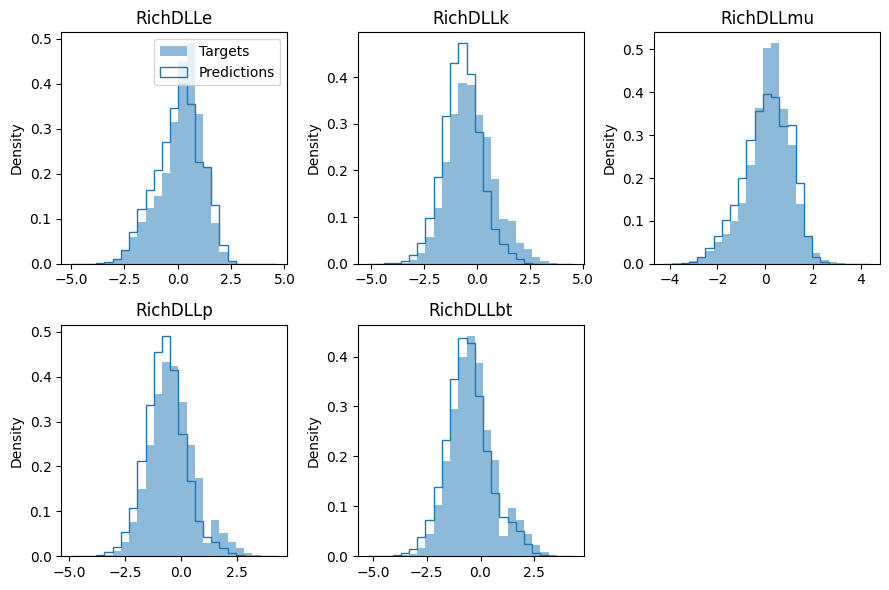

In [ ]:
def plot_target_histrogams(real_targets, generated_targets, dll_columns=DLL_COLUMNS):
  fig, axes = plt.subplots(2, 3, figsize=(9, 6))

  for i, ax in enumerate(axes.flatten()[:-1]):
    particle_targets = np.array(real_targets[:, i])
    particle_predictions = np.array(generated_targets[:, i])

    mins = particle_targets.min(), particle_predictions.min()
    maxs = particle_targets.max(), particle_predictions.max()

    hist_range = min(mins), max(maxs)

    ax.set_title(dll_columns[i])
    ax.hist(particle_targets, 25, hist_range, True, alpha=.5, label='Targets')
    ax.hist(particle_predictions, 25, hist_range, True, histtype='step', color='tab:blue', label='Predictions')
    ax.set_ylabel('Density')

  axes[0, 0].legend()
  axes[-1, -1].axis(False)
  plt.tight_layout()
  plt.show()

plot_target_histrogams(y_sample, t_generated)

In [ ]:
def estimate_distances_and_plot_uncertainty_bins(y_real, y_generated, uncertainty_scores, uncertainty_type=None, bin_type='quantiles',
                                                 particle_index=0, metric='JS', n_rows=2, n_cols=5, dll_columns=DLL_COLUMNS):
  n_bins = n_rows * n_cols

  targets = np.array(y_real[:, particle_index])
  predictions = np.array(y_generated[:, particle_index])
  uncertainty_scores = np.array(uncertainty_scores)

  if uncertainty_type == 'MCD':
    uncertainty_scores = uncertainty_scores[:, particle_index]

  if bin_type == 'linear':
    bin_edges = np.linspace(uncertainty_scores.min(), uncertainty_scores.max(), n_bins + 1)
  else: # Quantiles
    bin_edges = np.quantile(uncertainty_scores, np.linspace(0, 1, n_bins + 1))

  # Digitize returns sample indices per bin
  bin_indices = np.digitize(uncertainty_scores, bin_edges) - 1

  fig, axes = plt.subplots(n_rows, n_cols, figsize=(3 * n_cols, 3 * n_rows))

  rounded_bin_edges = np.round(bin_edges, 3)

  mean_unc_scores = []
  distances = []

  for i, ax in enumerate(axes.flatten()):
    indices = bin_indices == i

    mins = targets[indices].min(), predictions[indices].min()
    maxs = targets[indices].max(), predictions[indices].max()

    hist_range = min(mins), max(maxs)

    targets_hist = ax.hist(targets[indices], 25, hist_range, True, alpha=.5, label='Targets')[0]
    predictions_hist = ax.hist(
        predictions[indices], 25, hist_range, True, histtype='step', color='tab:blue', label='Predictions')[0]
    mean_unc_scores += [uncertainty_scores[indices].mean()]

    ax.set_title(f'{rounded_bin_edges[i]} < unc. score < {rounded_bin_edges[i + 1]}')
    ax.set_ylabel('Density')
    ax.set_xlabel(f'{dll_columns[particle_index]}')

    if metric == 'JS':
      dist = jensenshannon(predictions_hist, targets_hist)
    else: # KS
      dist = kstest(predictions[indices], targets[indices]).statistic

    distances += [dist]
    print(f'{rounded_bin_edges[i]} < unc. score < {rounded_bin_edges[i + 1]}: Number of observations: {len(predictions[indices])}')

  plt.suptitle(f'{uncertainty_type} uncertainty score bins for {dll_columns[particle_index]}')
  axes[0, 0].legend()
  plt.tight_layout()
  try:
    TIKZ
    tikzplotlib.save(f'{uncertainty_type}_uncertainty_score_bins_for_{dll_columns[particle_index]}.tex')
  except:
    plt.show()
  print(f"{metric} Distances:\n" + ", ".join([str(dist) for dist in distances]))

  return mean_unc_scores, distances


def plot_distances(mean_unc_scores, distances, uncertainty_type, dll_columns=DLL_COLUMNS, particle_index = 0):
  plt.title(f'{uncertainty_type} reliability curve for {dll_columns[particle_index]}')
  plt.gca().set_axisbelow(True)
  plt.grid()
  plt.plot(mean_unc_scores, distances, '.-')
  plt.xlabel('Uncertainty score')
  plt.ylabel('Jensen–Shannon distance')
  plt.show()

  print('Correlation coefficient:', linregress(mean_unc_scores, distances).rvalue)

def plot_all_distances(all_mean_unc_scores, all_distances, uncertainty_type, dll_columns=DLL_COLUMNS, particle_index = 0, metric='JS'):
  plt.figure()
  plt.title(f'{uncertainty_type} reliability curves')
  plt.gca().set_axisbelow(True)
  plt.grid()

  correlation_coefficient = []

  for i in range(5):
    bin_ranges = all_mean_unc_scores[i]
    plt.plot(bin_ranges, all_distances[i], '.-', label=dll_columns[i])
    regress = linregress(bin_ranges, all_distances[i])
    correlation_coefficient += [regress.rvalue]
    print(f'Correlation coefficient for {dll_columns[i]}:', regress.rvalue)

  plt.xlabel('Uncertainty score')
  if metric == 'JS':
    plt.ylabel('Jensen–Shannon distance')
  else:
    plt.ylabel('Kolmogorov-Smirnov distance')
  plt.legend()

  try:
    TIKZ
    tikzplotlib.save(f'{uncertainty_type}_reliability_curves_{metric}.tex')
  except:
    plt.show()

  return

## Monte Carlo Dropout method

## Uncertainty estimation

In [ ]:
%%time

# 30 Repetitions of the MCD ensemble mode
mcd_ensemble_uncertainties = []

for i in range(N):
  print(f'Run {i + 1}')
  mcd_ensemble_uncertainties.append(
      mcd_evaluate_model(model, x_sample, MCD_ENSEMBLE_SIZE)[0])



Run 1
Generating ensemble(300) predictions


100%|██████████| 300/300 [00:07<00:00, 39.26it/s]


Run 2
Generating ensemble(300) predictions


100%|██████████| 300/300 [00:07<00:00, 39.51it/s]


Run 3
Generating ensemble(300) predictions


100%|██████████| 300/300 [00:07<00:00, 39.13it/s]


Run 4
Generating ensemble(300) predictions


100%|██████████| 300/300 [00:07<00:00, 38.60it/s]


Run 5
Generating ensemble(300) predictions


100%|██████████| 300/300 [00:07<00:00, 39.18it/s]


Run 6
Generating ensemble(300) predictions


100%|██████████| 300/300 [00:07<00:00, 39.52it/s]


Run 7
Generating ensemble(300) predictions


100%|██████████| 300/300 [00:07<00:00, 38.97it/s]


Run 8
Generating ensemble(300) predictions


100%|██████████| 300/300 [00:07<00:00, 38.90it/s]


Run 9
Generating ensemble(300) predictions


100%|██████████| 300/300 [00:07<00:00, 39.25it/s]


Run 10
Generating ensemble(300) predictions


100%|██████████| 300/300 [00:07<00:00, 39.38it/s]


Run 11
Generating ensemble(300) predictions


100%|██████████| 300/300 [00:07<00:00, 38.89it/s]


Run 12
Generating ensemble(300) predictions


100%|██████████| 300/300 [00:07<00:00, 39.09it/s]


Run 13
Generating ensemble(300) predictions


100%|██████████| 300/300 [00:07<00:00, 39.30it/s]


Run 14
Generating ensemble(300) predictions


100%|██████████| 300/300 [00:07<00:00, 39.26it/s]


Run 15
Generating ensemble(300) predictions


100%|██████████| 300/300 [00:07<00:00, 39.07it/s]


Run 16
Generating ensemble(300) predictions


100%|██████████| 300/300 [00:07<00:00, 38.86it/s]


Run 17
Generating ensemble(300) predictions


100%|██████████| 300/300 [00:07<00:00, 38.92it/s]


Run 18
Generating ensemble(300) predictions


100%|██████████| 300/300 [00:07<00:00, 38.72it/s]


Run 19
Generating ensemble(300) predictions


100%|██████████| 300/300 [00:07<00:00, 38.70it/s]


Run 20
Generating ensemble(300) predictions


100%|██████████| 300/300 [00:07<00:00, 38.68it/s]


Run 21
Generating ensemble(300) predictions


100%|██████████| 300/300 [00:07<00:00, 38.40it/s]


Run 22
Generating ensemble(300) predictions


100%|██████████| 300/300 [00:07<00:00, 38.43it/s]


Run 23
Generating ensemble(300) predictions


100%|██████████| 300/300 [00:07<00:00, 38.24it/s]


Run 24
Generating ensemble(300) predictions


100%|██████████| 300/300 [00:07<00:00, 38.98it/s]


Run 25
Generating ensemble(300) predictions


100%|██████████| 300/300 [00:07<00:00, 38.77it/s]


Run 26
Generating ensemble(300) predictions


100%|██████████| 300/300 [00:07<00:00, 38.67it/s]


Run 27
Generating ensemble(300) predictions


100%|██████████| 300/300 [00:07<00:00, 38.29it/s]


Run 28
Generating ensemble(300) predictions


100%|██████████| 300/300 [00:07<00:00, 39.88it/s]


Run 29
Generating ensemble(300) predictions


100%|██████████| 300/300 [00:07<00:00, 38.98it/s]


Run 30
Generating ensemble(300) predictions


100%|██████████| 300/300 [00:07<00:00, 38.99it/s]

CPU times: user 3min 51s, sys: 1.27 s, total: 3min 52s
Wall time: 3min 51s


In [ ]:
stacked_mcd_ensemble = tf.stack(mcd_ensemble_uncertainties)
average_mcd_ensemble = tf.reduce_mean(stacked_mcd_ensemble, axis=0)

In [ ]:
%%time
# 30 Repetitions of the MCD single inference mode

mcd_single_uncertainties = []

for i in range(N):
  print(f'Run {i + 1}')
  mcd_single_uncertainties.append(
      mcd_evaluate_model(model, x_sample, MCD_ENSEMBLE_SIZE, mode="single")[0])


Run 1
Generating ensemble(300) predictions


100%|██████████| 300/300 [00:03<00:00, 80.37it/s]


Run 2
Generating ensemble(300) predictions


100%|██████████| 300/300 [00:04<00:00, 70.45it/s]


Run 3
Generating ensemble(300) predictions


100%|██████████| 300/300 [00:04<00:00, 71.00it/s]


Run 4
Generating ensemble(300) predictions


100%|██████████| 300/300 [00:04<00:00, 71.96it/s]


Run 5
Generating ensemble(300) predictions


100%|██████████| 300/300 [00:04<00:00, 72.18it/s]


Run 6
Generating ensemble(300) predictions


100%|██████████| 300/300 [00:04<00:00, 72.39it/s]


Run 7
Generating ensemble(300) predictions


100%|██████████| 300/300 [00:04<00:00, 72.89it/s]


Run 8
Generating ensemble(300) predictions


100%|██████████| 300/300 [00:04<00:00, 73.08it/s]


Run 9
Generating ensemble(300) predictions


100%|██████████| 300/300 [00:04<00:00, 73.22it/s]


Run 10
Generating ensemble(300) predictions


100%|██████████| 300/300 [00:04<00:00, 73.07it/s]


Run 11
Generating ensemble(300) predictions


100%|██████████| 300/300 [00:04<00:00, 72.67it/s]


Run 12
Generating ensemble(300) predictions


100%|██████████| 300/300 [00:04<00:00, 72.52it/s]


Run 13
Generating ensemble(300) predictions


100%|██████████| 300/300 [00:04<00:00, 72.32it/s]


Run 14
Generating ensemble(300) predictions


100%|██████████| 300/300 [00:04<00:00, 72.00it/s]


Run 15
Generating ensemble(300) predictions


100%|██████████| 300/300 [00:04<00:00, 71.81it/s]


Run 16
Generating ensemble(300) predictions


100%|██████████| 300/300 [00:04<00:00, 71.51it/s]


Run 17
Generating ensemble(300) predictions


100%|██████████| 300/300 [00:04<00:00, 71.23it/s]


Run 18
Generating ensemble(300) predictions


100%|██████████| 300/300 [00:04<00:00, 71.07it/s]


Run 19
Generating ensemble(300) predictions


100%|██████████| 300/300 [00:04<00:00, 71.25it/s]


Run 20
Generating ensemble(300) predictions


100%|██████████| 300/300 [00:04<00:00, 71.22it/s]


Run 21
Generating ensemble(300) predictions


100%|██████████| 300/300 [00:04<00:00, 71.12it/s]


Run 22
Generating ensemble(300) predictions


100%|██████████| 300/300 [00:04<00:00, 71.31it/s]


Run 23
Generating ensemble(300) predictions


100%|██████████| 300/300 [00:04<00:00, 71.28it/s]


Run 24
Generating ensemble(300) predictions


100%|██████████| 300/300 [00:04<00:00, 71.35it/s]


Run 25
Generating ensemble(300) predictions


100%|██████████| 300/300 [00:04<00:00, 71.50it/s]


Run 26
Generating ensemble(300) predictions


100%|██████████| 300/300 [00:04<00:00, 71.54it/s]


Run 27
Generating ensemble(300) predictions


100%|██████████| 300/300 [00:04<00:00, 71.58it/s]


Run 28
Generating ensemble(300) predictions


100%|██████████| 300/300 [00:04<00:00, 71.45it/s]


Run 29
Generating ensemble(300) predictions


100%|██████████| 300/300 [00:04<00:00, 71.34it/s]


Run 30
Generating ensemble(300) predictions


100%|██████████| 300/300 [00:04<00:00, 71.46it/s]


In [ ]:
stacked_mcd_single = tf.stack(mcd_single_uncertainties)
average_mcd_single = tf.reduce_mean(stacked_mcd_single, axis=0)

In [ ]:
mcd_final_uncertainty = np.abs(average_mcd_ensemble - average_mcd_single)
mcd_final_uncertainty.shape

(100000, 5)

In [ ]:
# Save MCD uncertainties
np.save(output_dir + f'{PARTICLE}_mcd_uncertainty.npy', mcd_final_uncertainty)

### Plot MCD uncertainties

#### JS / Quantile bins

0.0 < unc. score < 0.01: Number of observations: 10000
0.01 < unc. score < 0.02: Number of observations: 10000
0.02 < unc. score < 0.02: Number of observations: 10000
0.02 < unc. score < 0.03: Number of observations: 10000
0.03 < unc. score < 0.03: Number of observations: 10000
0.03 < unc. score < 0.04: Number of observations: 10000
0.04 < unc. score < 0.04: Number of observations: 10000
0.04 < unc. score < 0.05: Number of observations: 10000
0.05 < unc. score < 0.06: Number of observations: 10000
0.06 < unc. score < 0.17: Number of observations: 9999


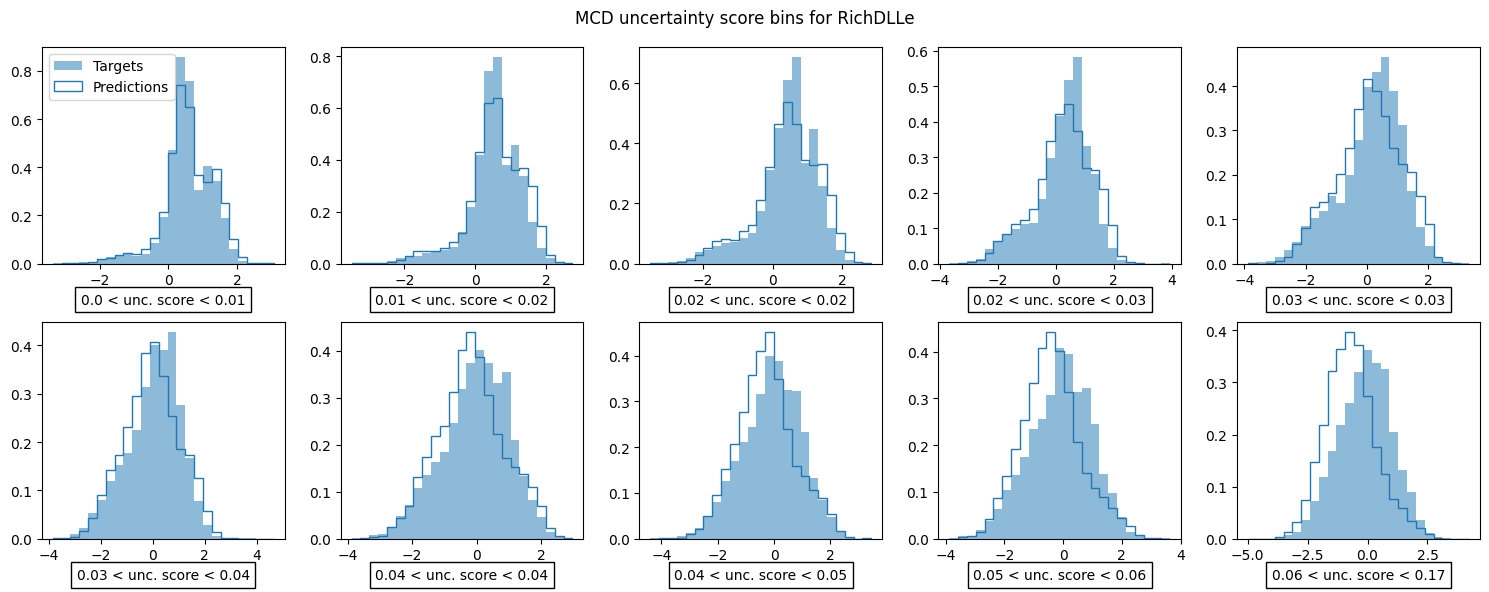

JS Distances:
0.06739856679354299, 0.0940685866887766, 0.10609134157230868, 0.10565553166848557, 0.1083766072177995, 0.10353981203786726, 0.10648495697437454, 0.11138439943785308, 0.14805072959963922, 0.21010808048736934
0.0 < unc. score < 0.02: Number of observations: 10000
0.02 < unc. score < 0.02: Number of observations: 10000
0.02 < unc. score < 0.03: Number of observations: 10000
0.03 < unc. score < 0.04: Number of observations: 10000
0.04 < unc. score < 0.04: Number of observations: 10000
0.04 < unc. score < 0.05: Number of observations: 10000
0.05 < unc. score < 0.06: Number of observations: 10000
0.06 < unc. score < 0.07: Number of observations: 10000
0.07 < unc. score < 0.09: Number of observations: 10000
0.09 < unc. score < 0.34: Number of observations: 9999


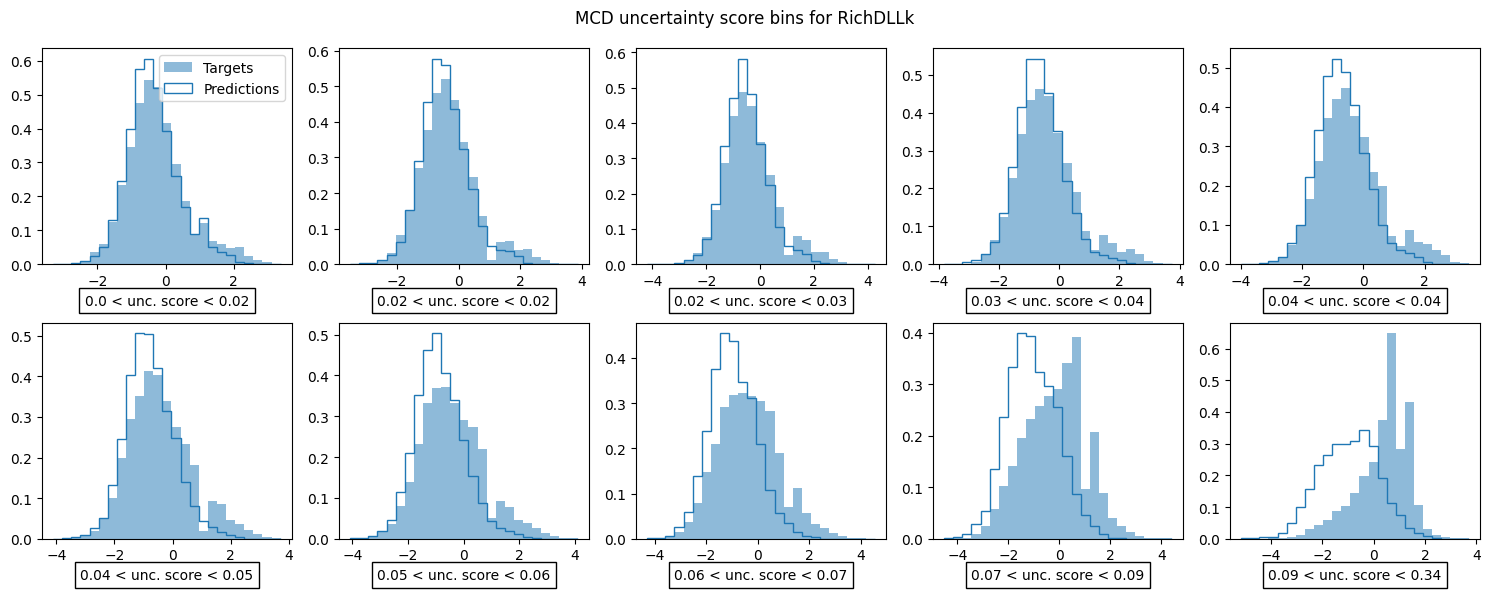

JS Distances:
0.08996183613435131, 0.10804735854780374, 0.11024393567580083, 0.12327397861757004, 0.1407901212173964, 0.16213714108720573, 0.17548776467132718, 0.2224131521328677, 0.29189917751157524, 0.4188068489058234
0.0 < unc. score < 0.01: Number of observations: 10000
0.01 < unc. score < 0.01: Number of observations: 10000
0.01 < unc. score < 0.01: Number of observations: 10000
0.01 < unc. score < 0.01: Number of observations: 10000
0.01 < unc. score < 0.02: Number of observations: 10000
0.02 < unc. score < 0.02: Number of observations: 10000
0.02 < unc. score < 0.03: Number of observations: 10000
0.03 < unc. score < 0.04: Number of observations: 10000
0.04 < unc. score < 0.05: Number of observations: 10000
0.05 < unc. score < 0.18: Number of observations: 9999


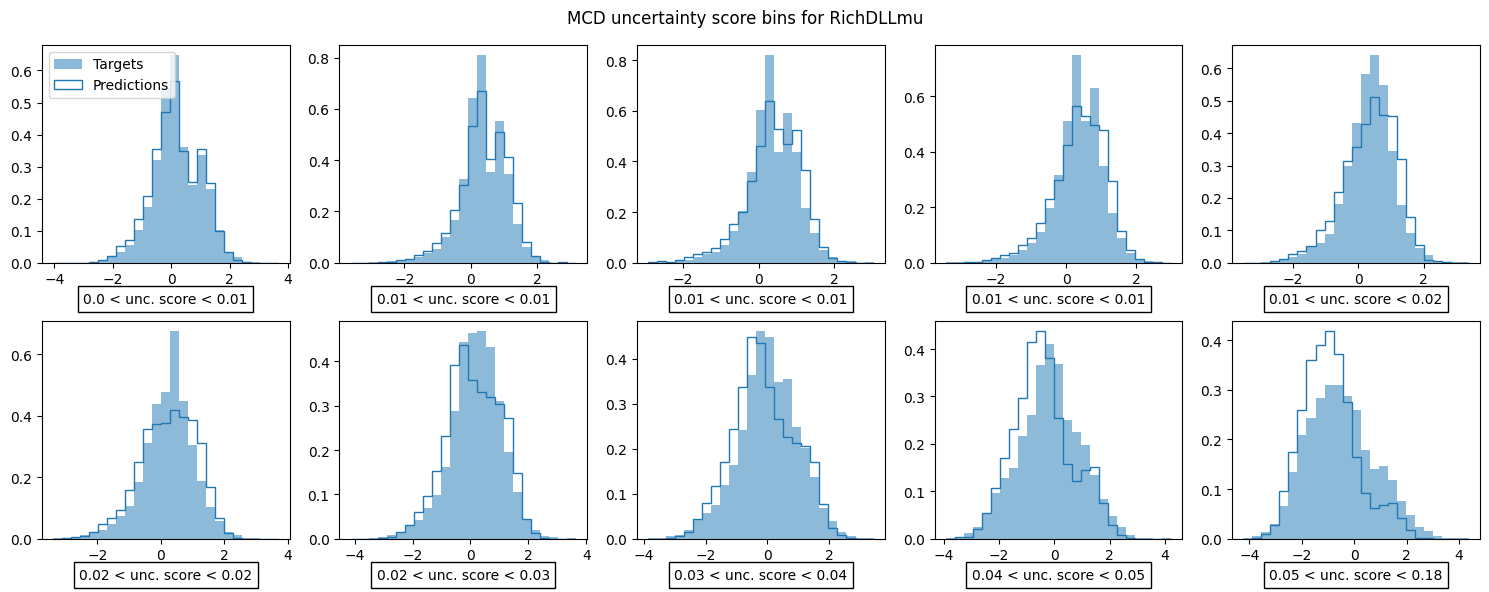

JS Distances:
0.05279073311502419, 0.07102800736725157, 0.09149187929744304, 0.08939814419624308, 0.10562582015125616, 0.11289434642697335, 0.10295860068571241, 0.10102912414415097, 0.12366866581252178, 0.153468281997768
0.0 < unc. score < 0.02: Number of observations: 10000
0.02 < unc. score < 0.03: Number of observations: 10000
0.03 < unc. score < 0.04: Number of observations: 10000
0.04 < unc. score < 0.05: Number of observations: 10000
0.05 < unc. score < 0.05: Number of observations: 10000
0.05 < unc. score < 0.06: Number of observations: 10000
0.06 < unc. score < 0.07: Number of observations: 10000
0.07 < unc. score < 0.08: Number of observations: 10000
0.08 < unc. score < 0.09: Number of observations: 10000
0.09 < unc. score < 0.31: Number of observations: 9999


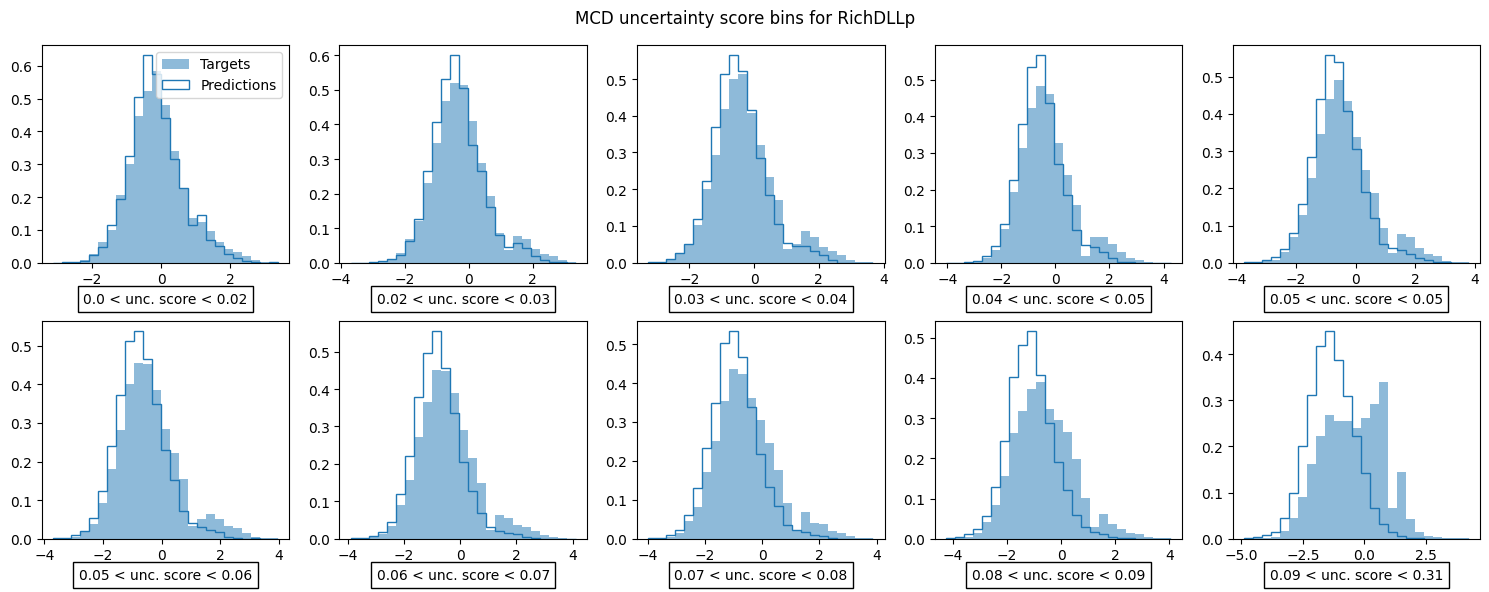

JS Distances:
0.06001275606637269, 0.07482070223878072, 0.09942659371622302, 0.11996593005831226, 0.11285489243223319, 0.13104984291540483, 0.14578182609911264, 0.15771677421079727, 0.19361116033639214, 0.30798708439401346
0.0 < unc. score < 0.02: Number of observations: 10000
0.02 < unc. score < 0.04: Number of observations: 10000
0.04 < unc. score < 0.04: Number of observations: 10000
0.04 < unc. score < 0.05: Number of observations: 10000
0.05 < unc. score < 0.06: Number of observations: 10000
0.06 < unc. score < 0.07: Number of observations: 10000
0.07 < unc. score < 0.08: Number of observations: 10000
0.08 < unc. score < 0.1: Number of observations: 10000
0.1 < unc. score < 0.12: Number of observations: 10000
0.12 < unc. score < 0.46: Number of observations: 9999


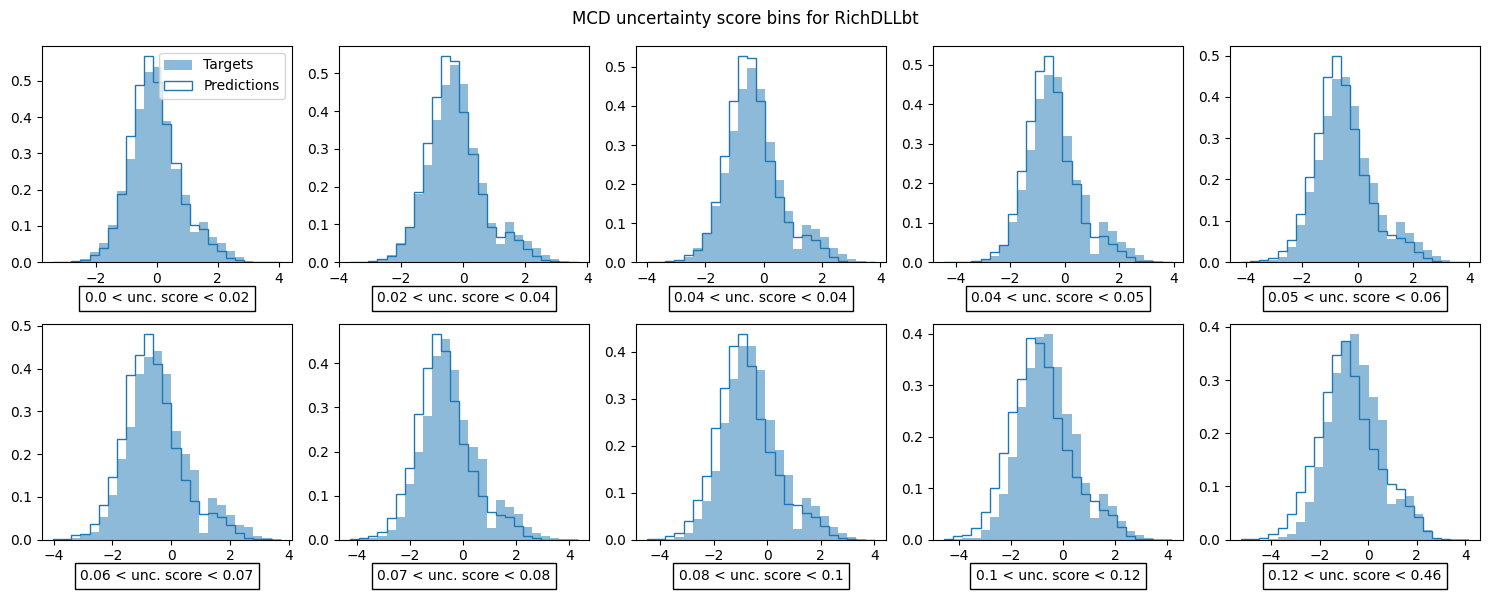

JS Distances:
0.06059304116706581, 0.06737568849364137, 0.08763842873427442, 0.1037140245963609, 0.09797284775873032, 0.11916834986860314, 0.13183499604346693, 0.135730198175054, 0.1369353633344536, 0.13923197012929198


In [ ]:
all_mcd_bin_edges, all_mcd_js_distances = [], []

metric = 'JS'
#metric = 'KS'

for i in range(5):
  mcd_bin_edges, mcd_js_distances = estimate_distances_and_plot_uncertainty_bins(
      y_sample, t_generated, mcd_final_uncertainty, uncertainty_type = 'MCD', bin_type='quantiles', particle_index = i, metric=metric)
  all_mcd_bin_edges += [mcd_bin_edges]
  all_mcd_js_distances += [mcd_js_distances]

Correlation coefficient for RichDLLe: 0.962856708185521
Correlation coefficient for RichDLLk: 0.9551050410573204
Correlation coefficient for RichDLLmu: 0.8515990057982638
Correlation coefficient for RichDLLp: 0.9826798818033122
Correlation coefficient for RichDLLbt: 0.6655881457500141


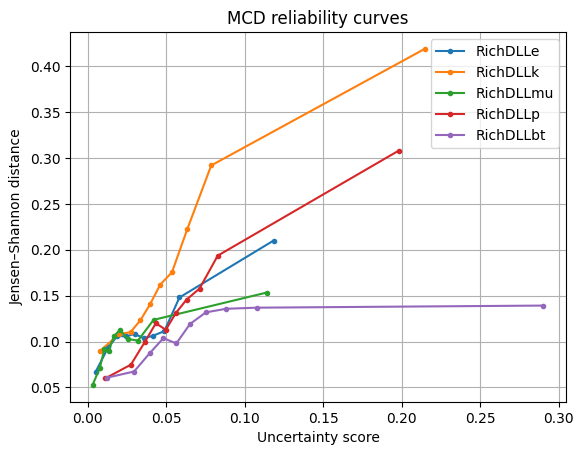

In [ ]:
plot_all_distances(all_mcd_bin_edges, all_mcd_js_distances, 'MCD', metric=metric)

#### KS / Quantile bins

0.0 < unc. score < 0.01: Number of observations: 10000
0.01 < unc. score < 0.02: Number of observations: 10000
0.02 < unc. score < 0.02: Number of observations: 10000
0.02 < unc. score < 0.03: Number of observations: 10000
0.03 < unc. score < 0.03: Number of observations: 10000
0.03 < unc. score < 0.04: Number of observations: 10000
0.04 < unc. score < 0.04: Number of observations: 10000
0.04 < unc. score < 0.05: Number of observations: 10000
0.05 < unc. score < 0.06: Number of observations: 10000
0.06 < unc. score < 0.17: Number of observations: 9999


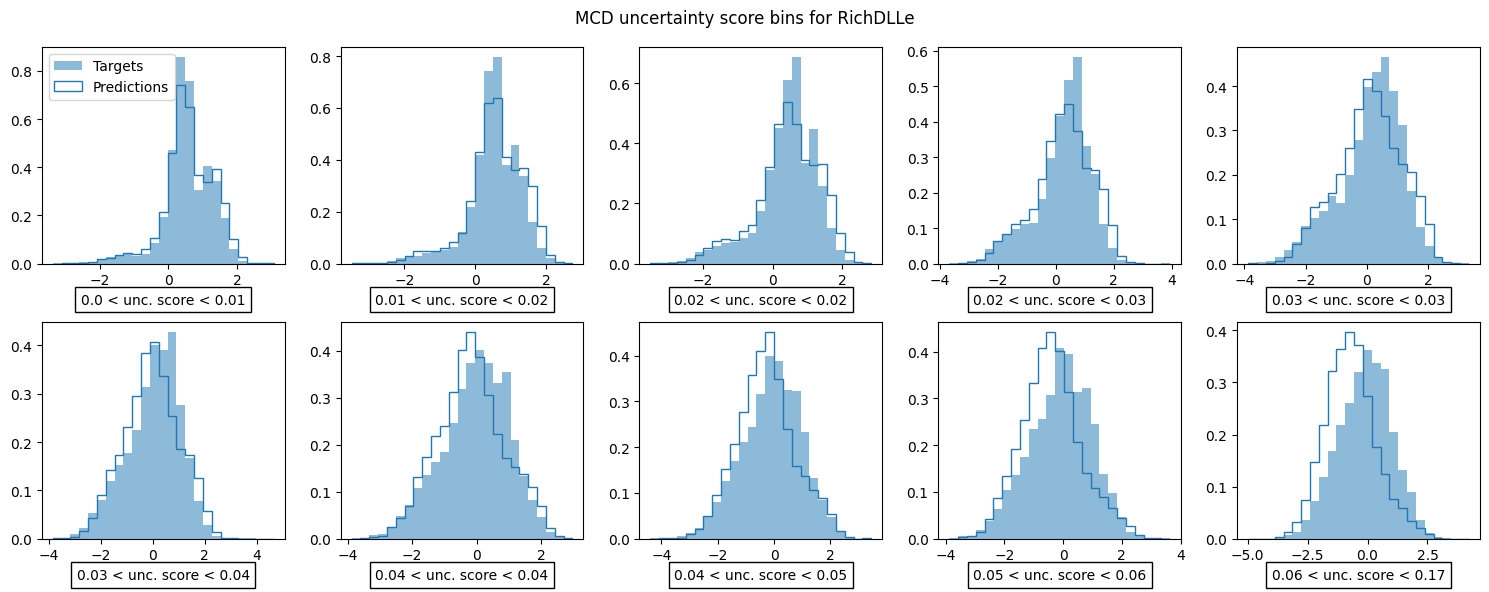

KS Distances:
0.0513, 0.0732, 0.0708, 0.0647, 0.0674, 0.0846, 0.1016, 0.1273, 0.1763, 0.2707270727072707
0.0 < unc. score < 0.02: Number of observations: 10000
0.02 < unc. score < 0.02: Number of observations: 10000
0.02 < unc. score < 0.03: Number of observations: 10000
0.03 < unc. score < 0.04: Number of observations: 10000
0.04 < unc. score < 0.04: Number of observations: 10000
0.04 < unc. score < 0.05: Number of observations: 10000
0.05 < unc. score < 0.06: Number of observations: 10000
0.06 < unc. score < 0.07: Number of observations: 10000
0.07 < unc. score < 0.09: Number of observations: 10000
0.09 < unc. score < 0.34: Number of observations: 9999


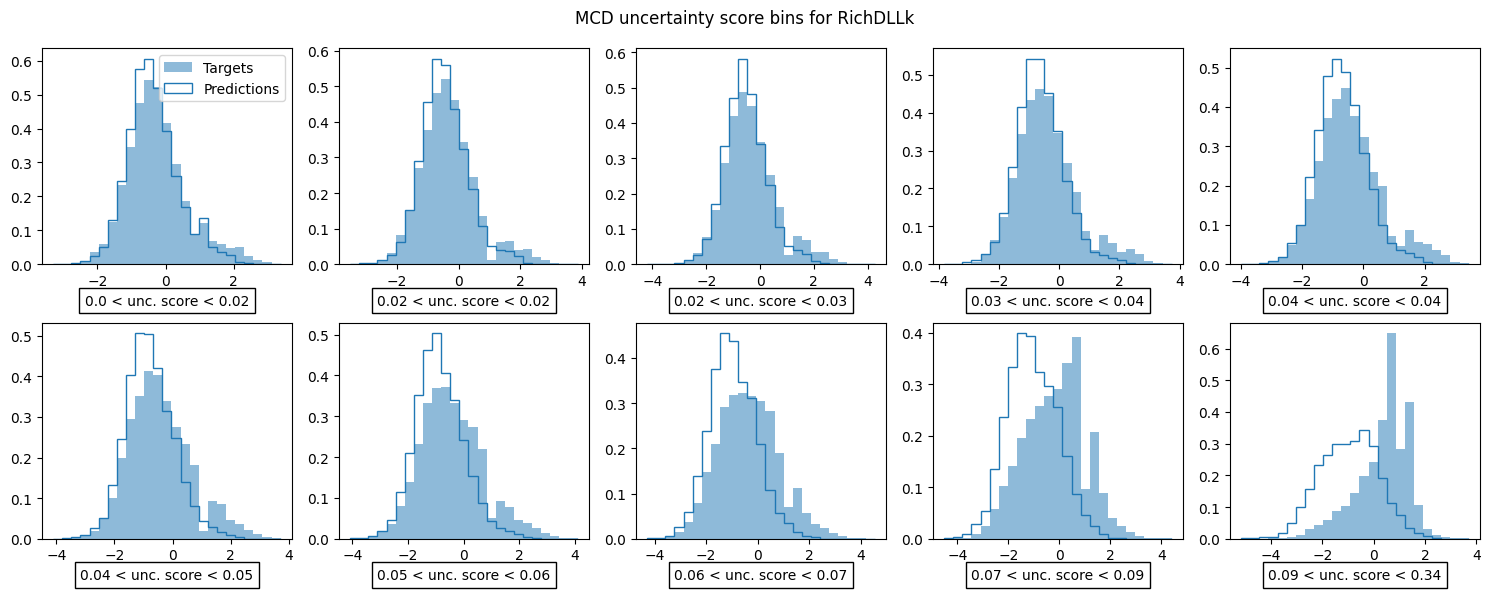

KS Distances:
0.0587, 0.0662, 0.0826, 0.1, 0.1258, 0.1458, 0.1823, 0.2372, 0.3317, 0.5183518351835184
0.0 < unc. score < 0.01: Number of observations: 10000
0.01 < unc. score < 0.01: Number of observations: 10000
0.01 < unc. score < 0.01: Number of observations: 10000
0.01 < unc. score < 0.01: Number of observations: 10000
0.01 < unc. score < 0.02: Number of observations: 10000
0.02 < unc. score < 0.02: Number of observations: 10000
0.02 < unc. score < 0.03: Number of observations: 10000
0.03 < unc. score < 0.04: Number of observations: 10000
0.04 < unc. score < 0.05: Number of observations: 10000
0.05 < unc. score < 0.18: Number of observations: 9999


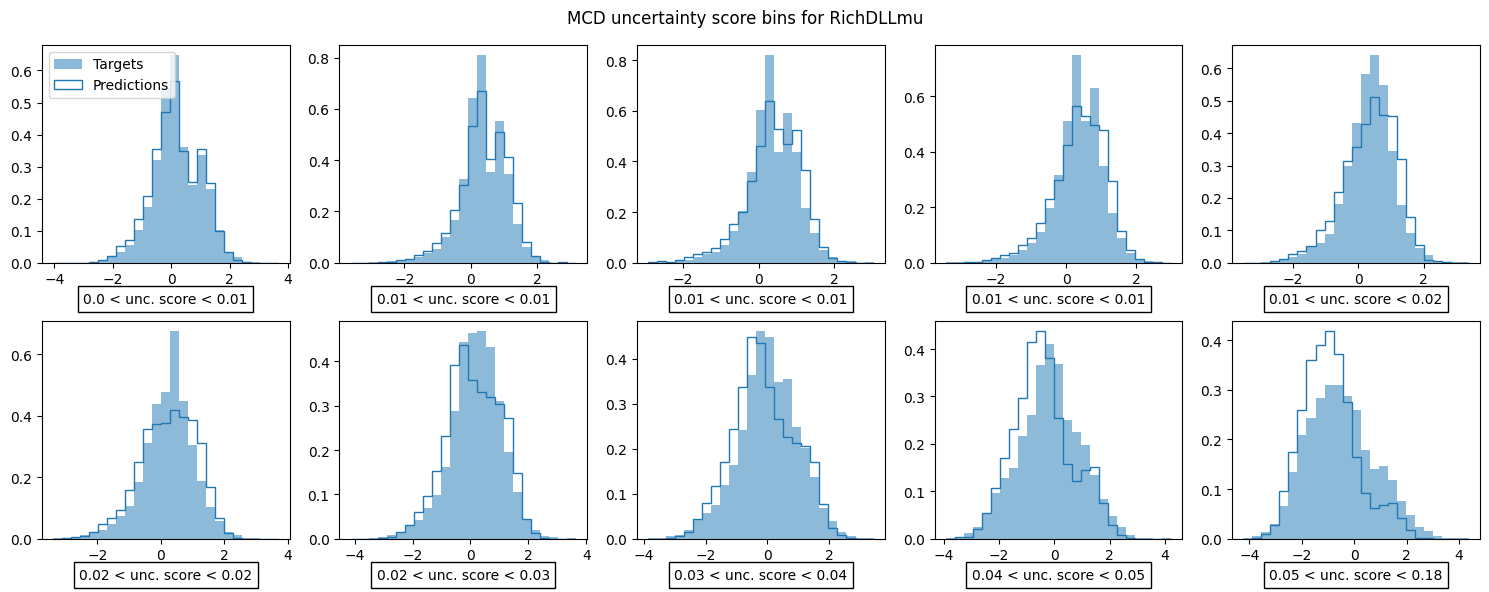

KS Distances:
0.0451, 0.0581, 0.0757, 0.0738, 0.0843, 0.076, 0.09, 0.11, 0.1479, 0.1767176717671767
0.0 < unc. score < 0.02: Number of observations: 10000
0.02 < unc. score < 0.03: Number of observations: 10000
0.03 < unc. score < 0.04: Number of observations: 10000
0.04 < unc. score < 0.05: Number of observations: 10000
0.05 < unc. score < 0.05: Number of observations: 10000
0.05 < unc. score < 0.06: Number of observations: 10000
0.06 < unc. score < 0.07: Number of observations: 10000
0.07 < unc. score < 0.08: Number of observations: 10000
0.08 < unc. score < 0.09: Number of observations: 10000
0.09 < unc. score < 0.31: Number of observations: 9999


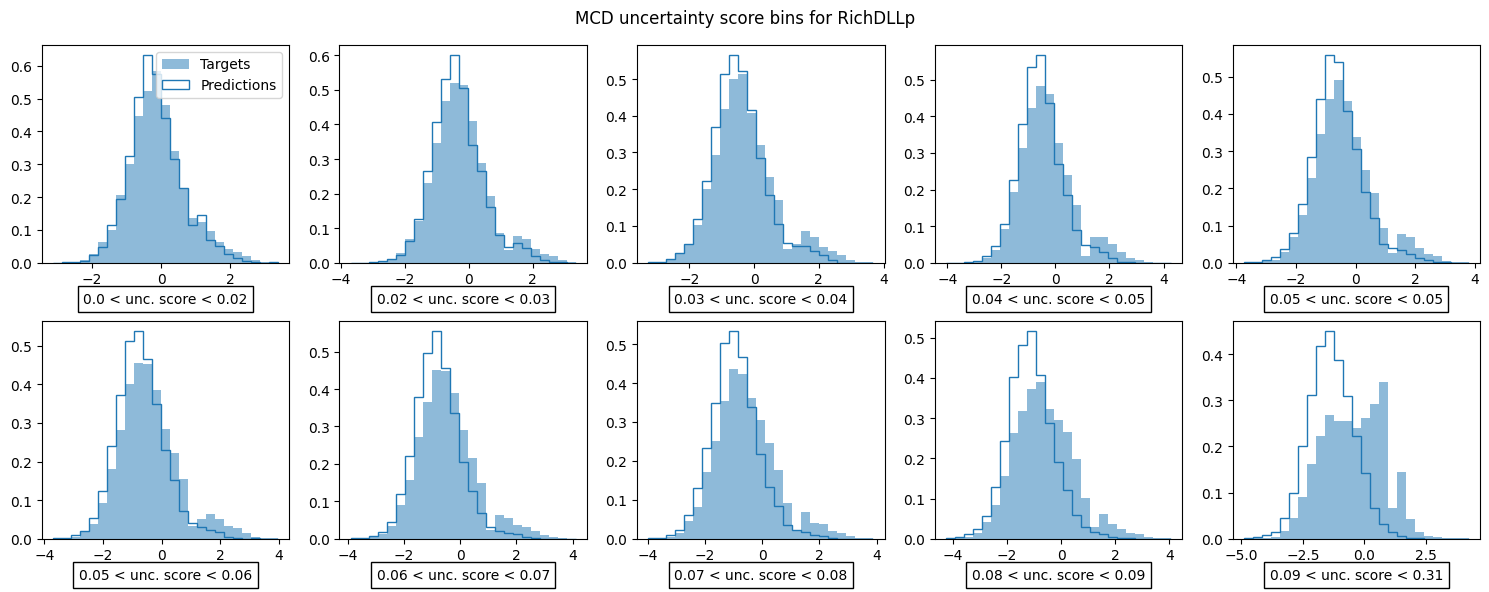

KS Distances:
0.046, 0.0688, 0.0848, 0.1093, 0.1162, 0.1294, 0.1567, 0.1706, 0.2162, 0.34233423342334235
0.0 < unc. score < 0.02: Number of observations: 10000
0.02 < unc. score < 0.04: Number of observations: 10000
0.04 < unc. score < 0.04: Number of observations: 10000
0.04 < unc. score < 0.05: Number of observations: 10000
0.05 < unc. score < 0.06: Number of observations: 10000
0.06 < unc. score < 0.07: Number of observations: 10000
0.07 < unc. score < 0.08: Number of observations: 10000
0.08 < unc. score < 0.1: Number of observations: 10000
0.1 < unc. score < 0.12: Number of observations: 10000
0.12 < unc. score < 0.46: Number of observations: 9999


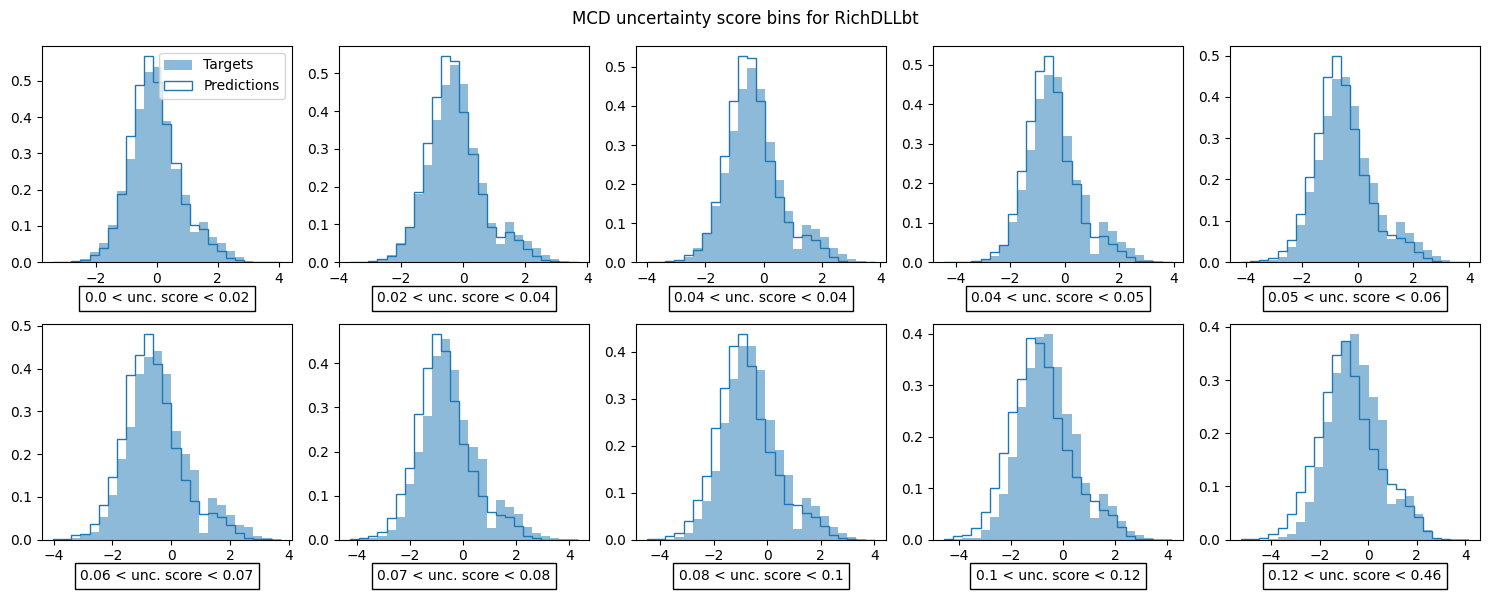

KS Distances:
0.0409, 0.0654, 0.0806, 0.0931, 0.1074, 0.1163, 0.1351, 0.1359, 0.146, 0.13031303130313032


In [ ]:
all_mcd_bin_edges, all_mcd_js_distances = [], []

# metric = 'JS'
metric = 'KS'

for i in range(5):
  mcd_bin_edges, mcd_js_distances = estimate_distances_and_plot_uncertainty_bins(
      y_sample, t_generated, mcd_final_uncertainty, uncertainty_type = 'MCD', bin_type='quantiles', particle_index = i, metric=metric)
  all_mcd_bin_edges += [mcd_bin_edges]
  all_mcd_js_distances += [mcd_js_distances]

Correlation coefficient for RichDLLe: 0.97038647276498
Correlation coefficient for RichDLLk: 0.9581469438937888
Correlation coefficient for RichDLLmu: 0.9117591647693591
Correlation coefficient for RichDLLp: 0.9758061141405108
Correlation coefficient for RichDLLbt: 0.5754176727893728


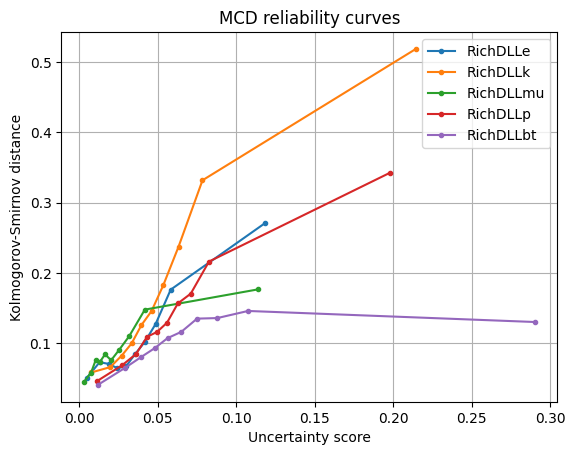

In [ ]:
plot_all_distances(all_mcd_bin_edges, all_mcd_js_distances, 'MCD', metric=metric)

## Feature Densities method

### Generation of FD embeddings

In [ ]:
# from feature_densities.feature_density_evaluator import create_embeddings_model
# embeddings_model = create_embeddings_model(model)
# train_embeddings, train_predictions = embeddings_model.predict(dataset['feats_train'])
# test_embeddings, test_predictions = embeddings_model.predict(dataset['feats_val'])

# !rm -r embeddings
# !mkdir embeddings

# np.save(embeddings_dir + f'{PARTICLE}_train_embeddings.npy', train_embeddings)
# np.save(embeddings_dir + f'{PARTICLE}_train_predictions.npy', train_predictions)
# np.save(embeddings_dir + f'{PARTICLE}_test_embeddings.npy', test_embeddings)
# np.save(embeddings_dir + f'{PARTICLE}_test_predictions.npy', test_predictions)

### Uncertainty estimation

In [ ]:
train_embeddings = np.load(embeddings_dir + f'{PARTICLE}_train_embeddings.npy')
train_embeddings.shape

(948325, 128)

In [ ]:
print('Generating an embeddings model')
layer = 8
embeddings_model = create_embeddings_model(model, layer)

print('Generating histograms')
n_bins = 30
probs, hists = get_histogram(train_embeddings, n_bins)

Generating an embeddings model
Generating histograms


In [ ]:
%%time

fd_uncertainties = []

for i in range(30):
  print(f'Run {i + 1}')
  fd_unc, _ = fd_evaluate_model(embeddings_model, x_sample, probs, hists, n_bins, likelihood_method='histograms')
  fd_uncertainties.append(fd_unc)


Run 1
Calculating sample's embeddings
Estimating sample's feature densities
Run 2
Calculating sample's embeddings
Estimating sample's feature densities
Run 3
Calculating sample's embeddings
Estimating sample's feature densities
Run 4
Calculating sample's embeddings
Estimating sample's feature densities
Run 5
Calculating sample's embeddings
Estimating sample's feature densities
Run 6
Calculating sample's embeddings
Estimating sample's feature densities
Run 7
Calculating sample's embeddings
Estimating sample's feature densities
Run 8
Calculating sample's embeddings
Estimating sample's feature densities
Run 9
Calculating sample's embeddings
Estimating sample's feature densities
Run 10
Calculating sample's embeddings
Estimating sample's feature densities
Run 11
Calculating sample's embeddings
Estimating sample's feature densities
Run 12
Calculating sample's embeddings
Estimating sample's feature densities
Run 13
Calculating sample's embeddings
Estimating sample's feature densities
Run 14
C

In [ ]:
stacked_fd_uncertainty = tf.stack(fd_uncertainties)
fd_uncertainty_normalized = tf.reduce_mean(stacked_fd_uncertainty, axis=0)

print('Feature Densities using NORMALIZED uncertainty score for x_sample:')
fd_uncertainty_normalized.shape

Feature Densities using NORMALIZED uncertainty score for x_sample:


TensorShape([100000])

In [ ]:
# Save FD uncertainties normalized
np.save(output_dir + f'{PARTICLE}_fd_uncertainty_normalized.npy', fd_uncertainty_normalized)

### Plot FD uncertainties

#### JS / Quantile bins

0.706 < unc. score < 0.771: Number of observations: 10000
0.771 < unc. score < 0.797: Number of observations: 10000
0.797 < unc. score < 0.817: Number of observations: 10000
0.817 < unc. score < 0.835: Number of observations: 10000
0.835 < unc. score < 0.85: Number of observations: 10000
0.85 < unc. score < 0.864: Number of observations: 10000
0.864 < unc. score < 0.878: Number of observations: 10000
0.878 < unc. score < 0.892: Number of observations: 10000
0.892 < unc. score < 0.909: Number of observations: 10000
0.909 < unc. score < 0.963: Number of observations: 9999


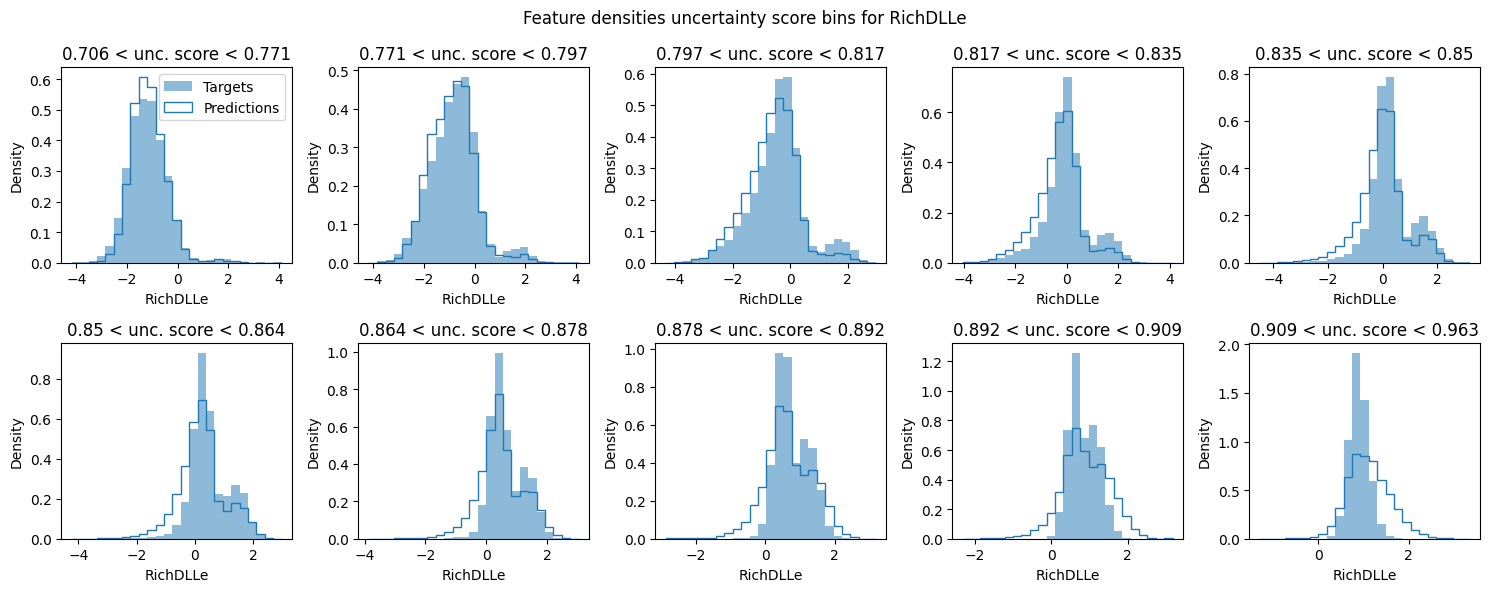

JS Distances:
0.06967677048093399, 0.06696491655457953, 0.10277812887651441, 0.13232209391400762, 0.15148955663075717, 0.17406358701559105, 0.19154659001751614, 0.2209572174754666, 0.2590672836228548, 0.33800657871143125
0.706 < unc. score < 0.771: Number of observations: 10000
0.771 < unc. score < 0.797: Number of observations: 10000
0.797 < unc. score < 0.817: Number of observations: 10000
0.817 < unc. score < 0.835: Number of observations: 10000
0.835 < unc. score < 0.85: Number of observations: 10000
0.85 < unc. score < 0.864: Number of observations: 10000
0.864 < unc. score < 0.878: Number of observations: 10000
0.878 < unc. score < 0.892: Number of observations: 10000
0.892 < unc. score < 0.909: Number of observations: 10000
0.909 < unc. score < 0.963: Number of observations: 9999


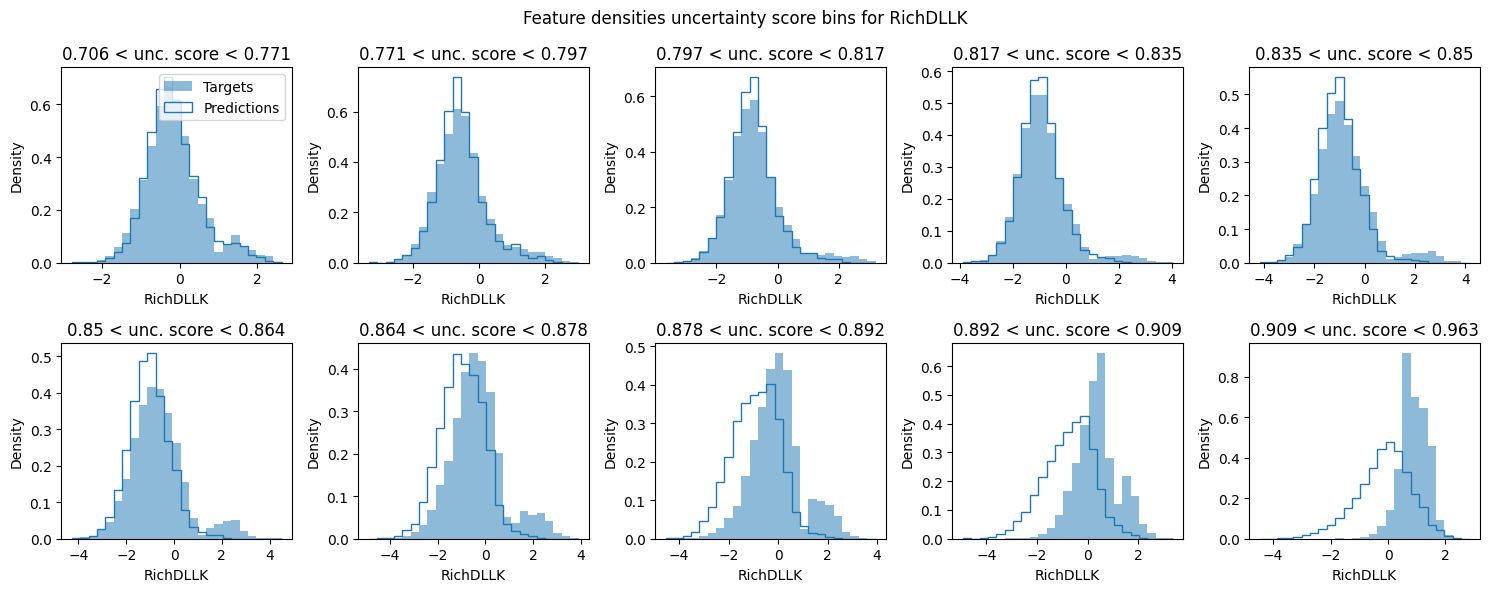

JS Distances:
0.06009354215668315, 0.07287723132165115, 0.08306974735187507, 0.09435332931302656, 0.11906916462684322, 0.16959957769234096, 0.22665462359852762, 0.3086336272466201, 0.40510062086155857, 0.48235280609406256
0.706 < unc. score < 0.771: Number of observations: 10000
0.771 < unc. score < 0.797: Number of observations: 10000
0.797 < unc. score < 0.817: Number of observations: 10000
0.817 < unc. score < 0.835: Number of observations: 10000
0.835 < unc. score < 0.85: Number of observations: 10000
0.85 < unc. score < 0.864: Number of observations: 10000
0.864 < unc. score < 0.878: Number of observations: 10000
0.878 < unc. score < 0.892: Number of observations: 10000
0.892 < unc. score < 0.909: Number of observations: 10000
0.909 < unc. score < 0.963: Number of observations: 9999


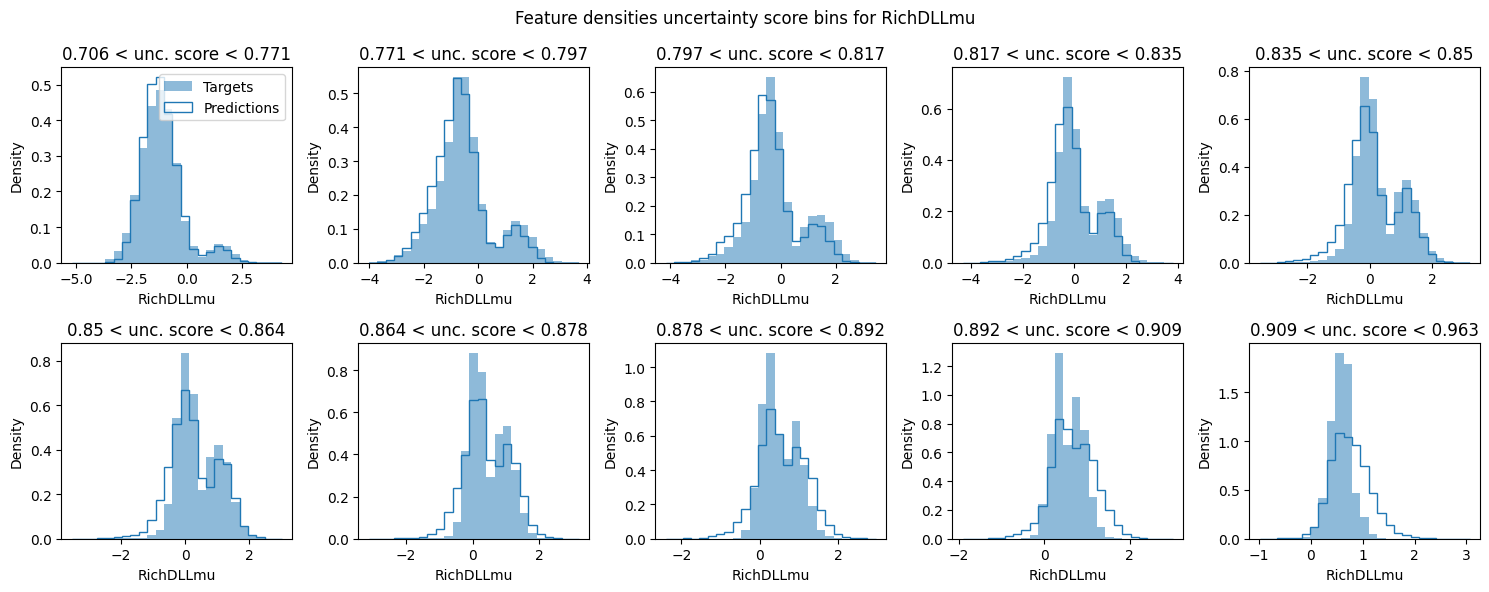

JS Distances:
0.07057280512617796, 0.08603150629823673, 0.12084422363335823, 0.13888284493556083, 0.13741175174836334, 0.15007498492617635, 0.16179587499245812, 0.18280856102601925, 0.23038708714982986, 0.2910343896149535
0.706 < unc. score < 0.771: Number of observations: 10000
0.771 < unc. score < 0.797: Number of observations: 10000
0.797 < unc. score < 0.817: Number of observations: 10000
0.817 < unc. score < 0.835: Number of observations: 10000
0.835 < unc. score < 0.85: Number of observations: 10000
0.85 < unc. score < 0.864: Number of observations: 10000
0.864 < unc. score < 0.878: Number of observations: 10000
0.878 < unc. score < 0.892: Number of observations: 10000
0.892 < unc. score < 0.909: Number of observations: 10000
0.909 < unc. score < 0.963: Number of observations: 9999


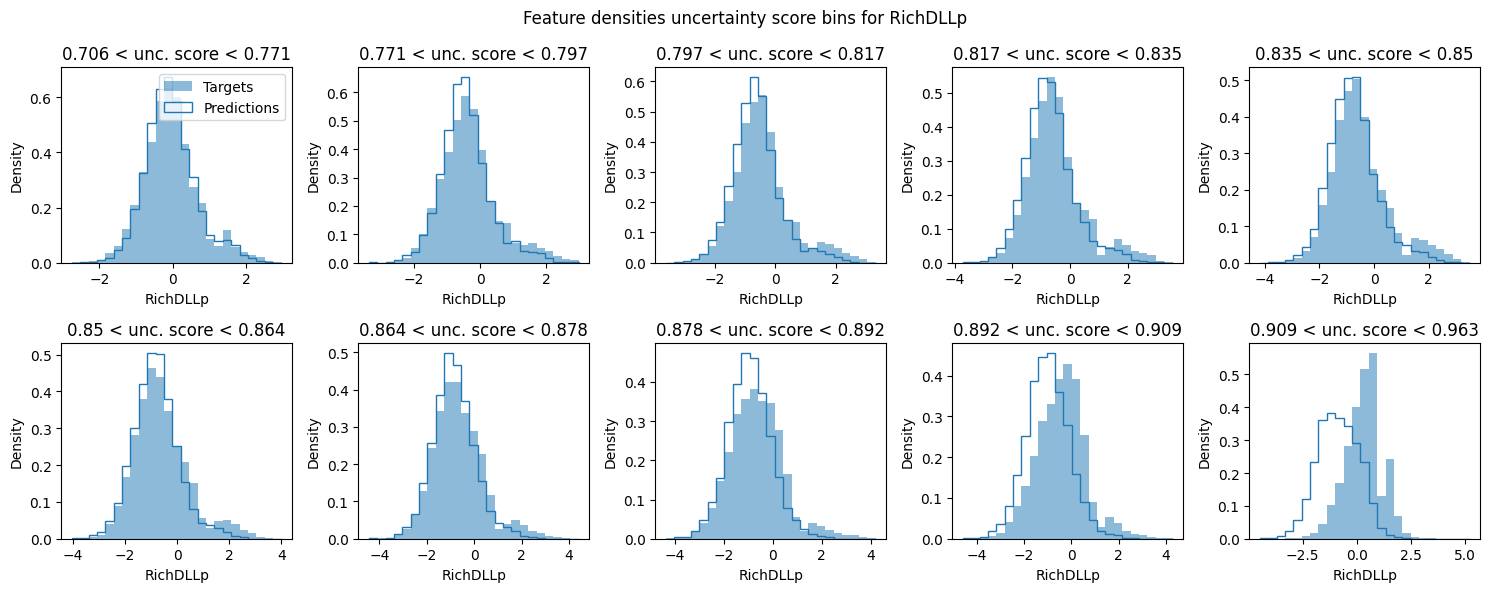

JS Distances:
0.05606579025251033, 0.0858117146688791, 0.10311730626276815, 0.1090582470176416, 0.10989556303872958, 0.1071856347076591, 0.10739927157038426, 0.14054408956869094, 0.21939622260001654, 0.4230493823265432
0.706 < unc. score < 0.771: Number of observations: 10000
0.771 < unc. score < 0.797: Number of observations: 10000
0.797 < unc. score < 0.817: Number of observations: 10000
0.817 < unc. score < 0.835: Number of observations: 10000
0.835 < unc. score < 0.85: Number of observations: 10000
0.85 < unc. score < 0.864: Number of observations: 10000
0.864 < unc. score < 0.878: Number of observations: 10000
0.878 < unc. score < 0.892: Number of observations: 10000
0.892 < unc. score < 0.909: Number of observations: 10000
0.909 < unc. score < 0.963: Number of observations: 9999


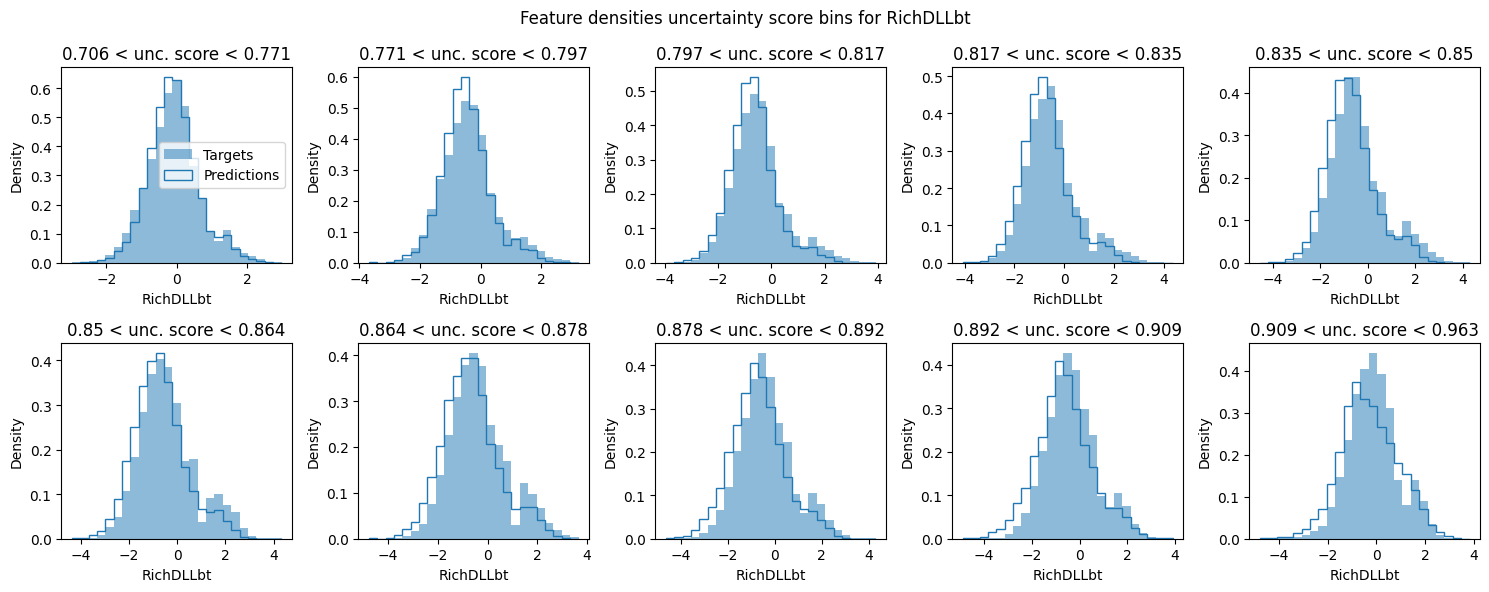

JS Distances:
0.05376135371748349, 0.08569249816945008, 0.09702914517716464, 0.10540687377474957, 0.11231701755021364, 0.11949471309544903, 0.12410969833400978, 0.1280883446036975, 0.129448361786938, 0.12724696537164792


In [ ]:
all_fd_bin_edges, all_fd_js_distances = [], []

metric = 'JS'
#metric = 'KS'

for i in range(5):
  fd_bin_edges, fd_js_distances = estimate_distances_and_plot_uncertainty_bins(
      y_sample, t_generated, fd_uncertainty_normalized, 'Feature densities', 'quantiles', particle_index = i, metric=metric)

  all_fd_bin_edges += [fd_bin_edges]
  all_fd_js_distances += [fd_js_distances]

Correlation coefficient for RichDLLe: 0.9586856666103347
Correlation coefficient for RichDLLK: 0.9028111523313973
Correlation coefficient for RichDLLmu: 0.949375795158595
Correlation coefficient for RichDLLp: 0.7772318080301693
Correlation coefficient for RichDLLbt: 0.9407019496648186


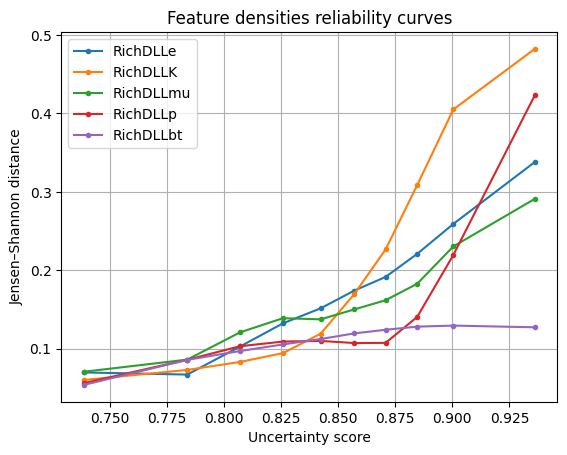

In [ ]:
plot_all_distances(all_fd_bin_edges, all_fd_js_distances, 'Feature densities', metric=metric)

#### KS / Quantile bins

0.14 < unc. score < 0.33: Number of observations: 10000
0.33 < unc. score < 0.4: Number of observations: 10000
0.4 < unc. score < 0.46: Number of observations: 10000
0.46 < unc. score < 0.5: Number of observations: 10000
0.5 < unc. score < 0.55: Number of observations: 10000
0.55 < unc. score < 0.6: Number of observations: 10000
0.6 < unc. score < 0.64: Number of observations: 10000
0.64 < unc. score < 0.69: Number of observations: 10000
0.69 < unc. score < 0.75: Number of observations: 10000
0.75 < unc. score < 0.94: Number of observations: 9999


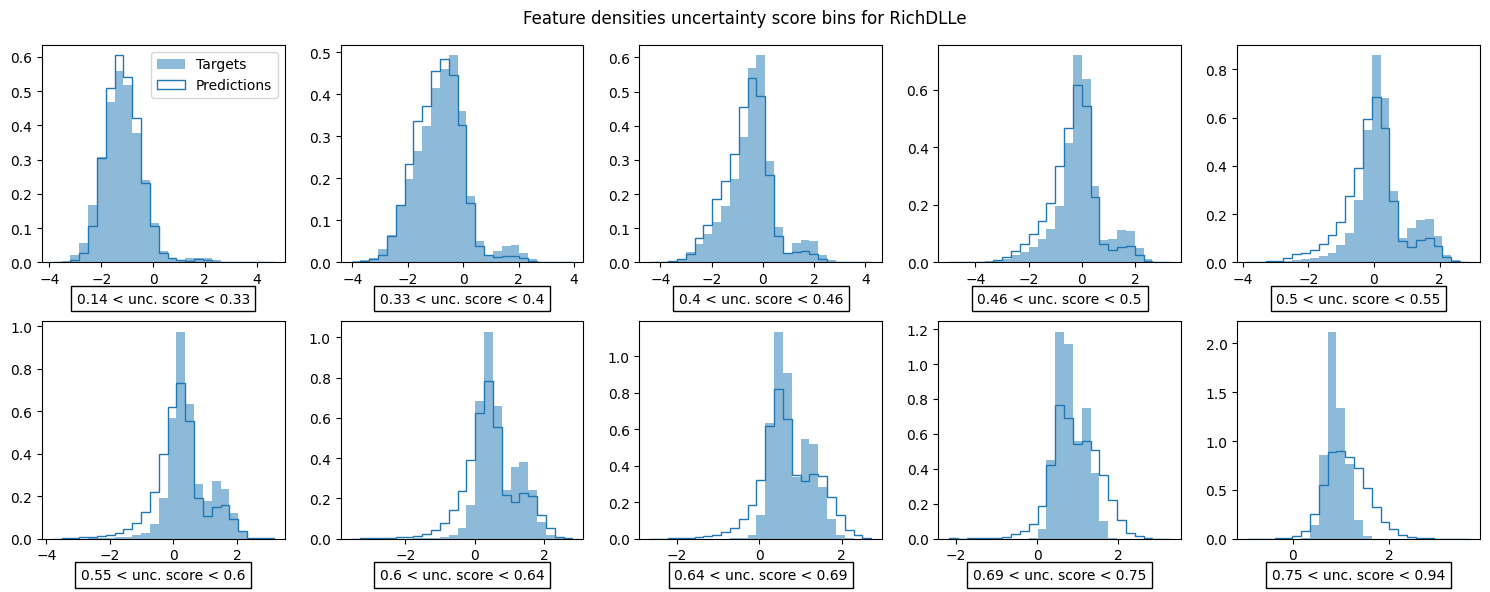

KS Distances:
0.0447, 0.0621, 0.1185, 0.1482, 0.1787, 0.1929, 0.1887, 0.1414, 0.168, 0.33813381338133813
0.14 < unc. score < 0.33: Number of observations: 10000
0.33 < unc. score < 0.4: Number of observations: 10000
0.4 < unc. score < 0.46: Number of observations: 10000
0.46 < unc. score < 0.5: Number of observations: 10000
0.5 < unc. score < 0.55: Number of observations: 10000
0.55 < unc. score < 0.6: Number of observations: 10000
0.6 < unc. score < 0.64: Number of observations: 10000
0.64 < unc. score < 0.69: Number of observations: 10000
0.69 < unc. score < 0.75: Number of observations: 10000
0.75 < unc. score < 0.94: Number of observations: 9999


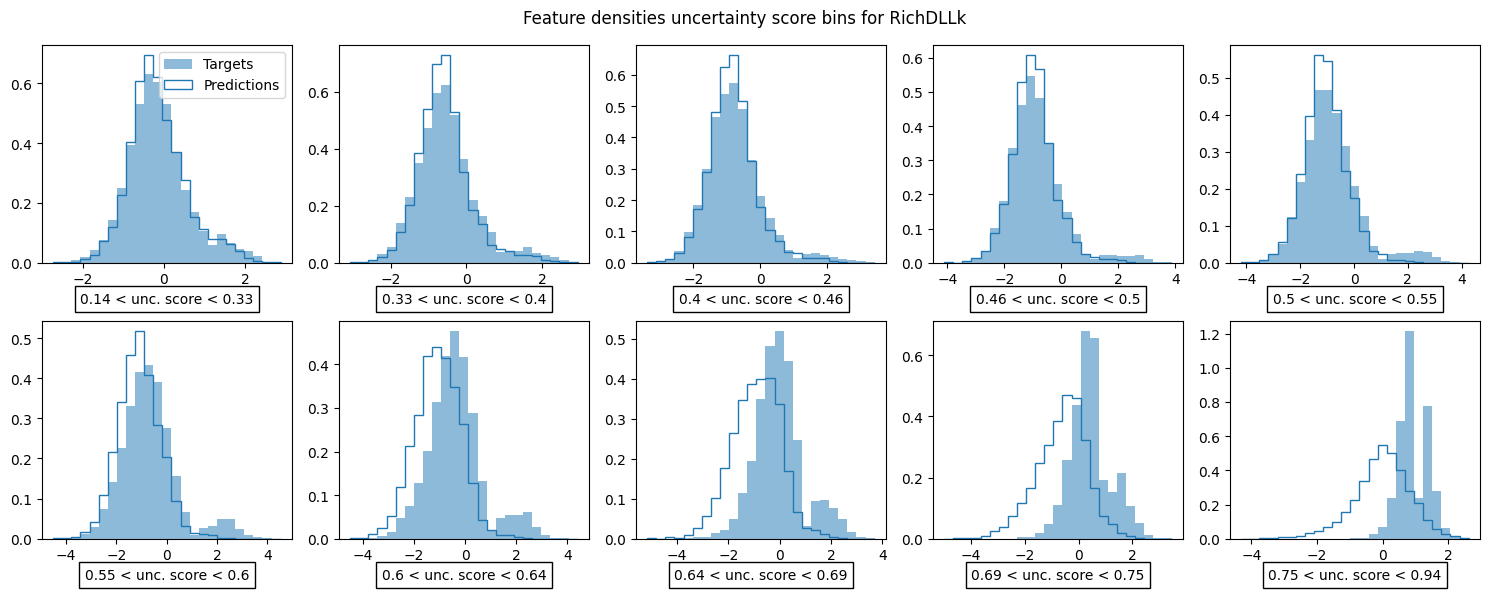

KS Distances:
0.0213, 0.06, 0.0515, 0.0578, 0.0967, 0.1787, 0.2822, 0.3632, 0.4934, 0.603060306030603
0.14 < unc. score < 0.33: Number of observations: 10000
0.33 < unc. score < 0.4: Number of observations: 10000
0.4 < unc. score < 0.46: Number of observations: 10000
0.46 < unc. score < 0.5: Number of observations: 10000
0.5 < unc. score < 0.55: Number of observations: 10000
0.55 < unc. score < 0.6: Number of observations: 10000
0.6 < unc. score < 0.64: Number of observations: 10000
0.64 < unc. score < 0.69: Number of observations: 10000
0.69 < unc. score < 0.75: Number of observations: 10000
0.75 < unc. score < 0.94: Number of observations: 9999


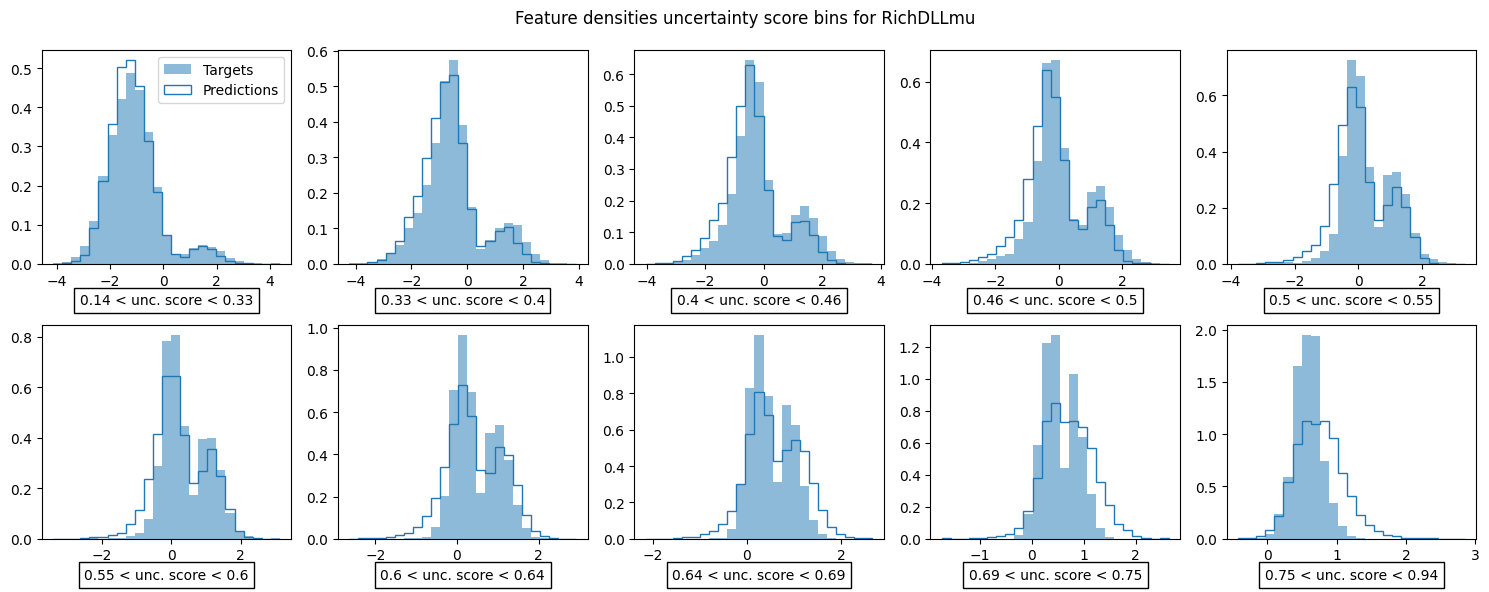

KS Distances:
0.0306, 0.0808, 0.134, 0.1345, 0.1431, 0.1256, 0.1074, 0.1216, 0.1804, 0.3163316331633163
0.14 < unc. score < 0.33: Number of observations: 10000
0.33 < unc. score < 0.4: Number of observations: 10000
0.4 < unc. score < 0.46: Number of observations: 10000
0.46 < unc. score < 0.5: Number of observations: 10000
0.5 < unc. score < 0.55: Number of observations: 10000
0.55 < unc. score < 0.6: Number of observations: 10000
0.6 < unc. score < 0.64: Number of observations: 10000
0.64 < unc. score < 0.69: Number of observations: 10000
0.69 < unc. score < 0.75: Number of observations: 10000
0.75 < unc. score < 0.94: Number of observations: 9999


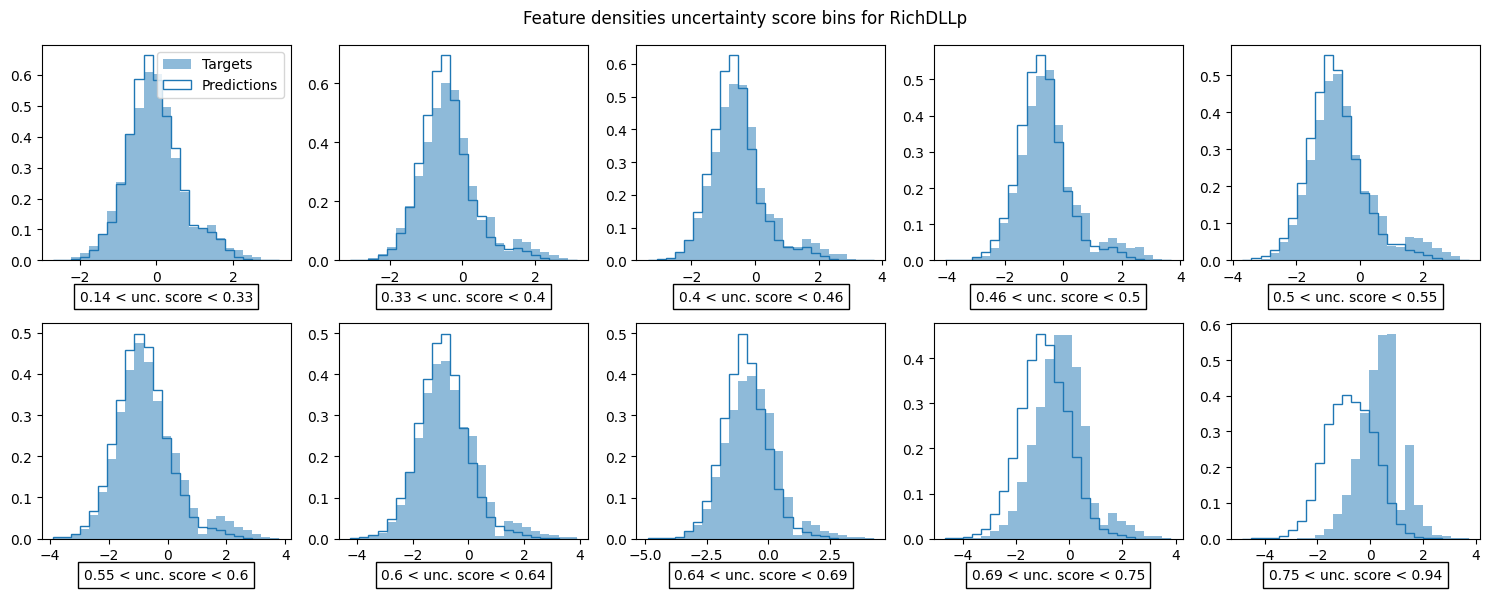

KS Distances:
0.0231, 0.084, 0.0997, 0.0986, 0.089, 0.0752, 0.0888, 0.1344, 0.2798, 0.504050405040504
0.14 < unc. score < 0.33: Number of observations: 10000
0.33 < unc. score < 0.4: Number of observations: 10000
0.4 < unc. score < 0.46: Number of observations: 10000
0.46 < unc. score < 0.5: Number of observations: 10000
0.5 < unc. score < 0.55: Number of observations: 10000
0.55 < unc. score < 0.6: Number of observations: 10000
0.6 < unc. score < 0.64: Number of observations: 10000
0.64 < unc. score < 0.69: Number of observations: 10000
0.69 < unc. score < 0.75: Number of observations: 10000
0.75 < unc. score < 0.94: Number of observations: 9999


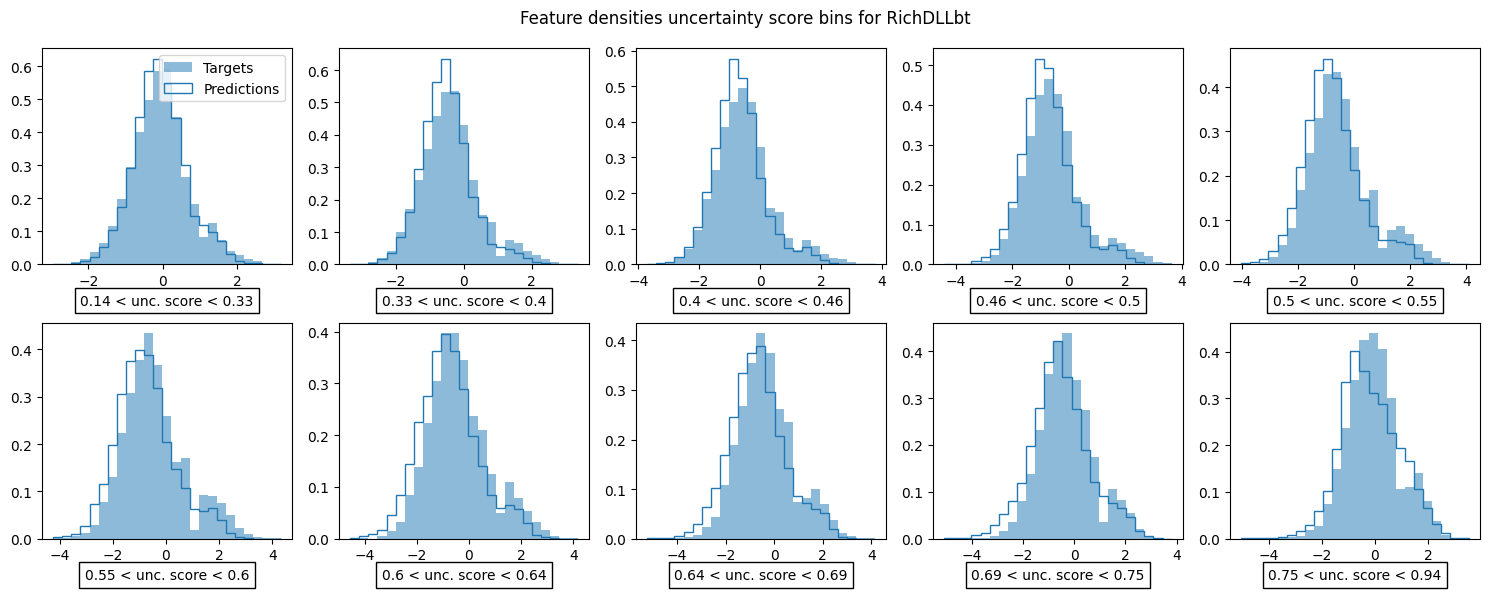

KS Distances:
0.0247, 0.0834, 0.1018, 0.1119, 0.1205, 0.1205, 0.1342, 0.1306, 0.1143, 0.10231023102310231


In [ ]:
all_fd_bin_edges, all_fd_js_distances = [], []

# metric = 'JS'
metric = 'KS'

for i in range(5):
  fd_bin_edges, fd_js_distances = estimate_distances_and_plot_uncertainty_bins(
      y_sample, t_generated, fd_uncertainty_normalized, 'Feature densities', 'quantiles', particle_index = i, metric=metric)

  all_fd_bin_edges += [fd_bin_edges]
  all_fd_js_distances += [fd_js_distances]

Correlation coefficient for RichDLLe: 0.8739245957979291
Correlation coefficient for RichDLLk: 0.9216401632319418
Correlation coefficient for RichDLLmu: 0.8359016527608365
Correlation coefficient for RichDLLp: 0.7928907772707648
Correlation coefficient for RichDLLbt: 0.6875030318085384


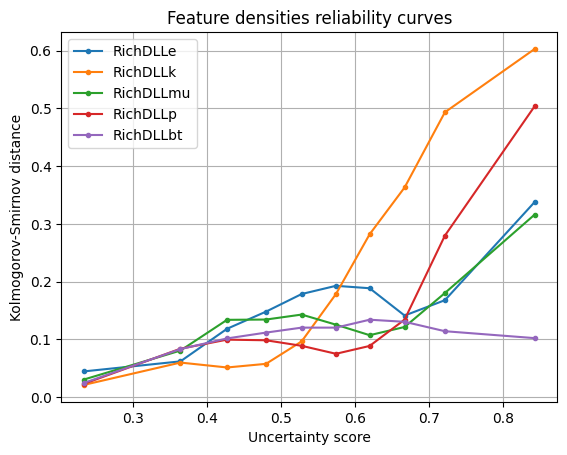

In [ ]:
plot_all_distances(all_fd_bin_edges, all_fd_js_distances, 'Feature densities', metric=metric)

## Experiment 30x30

Load Results

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
x_sample_orig = np.load('/content/drive/MyDrive/cern/data/results/30x30/article_results/pion_x_real_orig.npy')
x_sample = np.load('/content/drive/MyDrive/cern/data/results/30x30/article_results/pion_x_real.npy')

y_sample_orig = np.load('/content/drive/MyDrive/cern/data/results/30x30/article_results/pion_y_real_orig.npy')
y_sample = np.load('/content/drive/MyDrive/cern/data/results/30x30/article_results/pion_y_real.npy')

t_generated = np.load('/content/drive/MyDrive/cern/data/results/30x30/article_results/pion_t_generated.npy')

mcd_uncertainty = np.load('/content/drive/MyDrive/cern/data/results/30x30/article_results/pion_mcd_uncertainty_dp_0.1.npy').mean(0)
fd_uncertainty = np.load('/content/drive/MyDrive/cern/data/results/30x30/article_results/pion_fd_uncertainty_layer_8.npy').mean(0)

print('Features shape:', x_sample.shape)
print('Targets shape:', y_sample.shape)
print('Predictions shape:', t_generated.shape)
print('MCD uncertainties shape:', mcd_uncertainty.shape)
print('FD uncertainties shape:', fd_uncertainty.shape)

Features shape: (100000, 3)
Targets shape: (100000, 5)
Predictions shape: (100000, 5)
MCD uncertainties shape: (100000, 5)
FD uncertainties shape: (100000,)


### FD using JS

<ipython-input-9-f34132092fec>:35: MatplotlibDeprecationWarning: Passing the range parameter of hist() positionally is deprecated since Matplotlib 3.9; the parameter will become keyword-only in 3.11.
  targets_hist = ax.hist(targets[indices], 25, hist_range, True, alpha=.5, label='Targets')[0]
<ipython-input-9-f34132092fec>:36: MatplotlibDeprecationWarning: Passing the range parameter of hist() positionally is deprecated since Matplotlib 3.9; the parameter will become keyword-only in 3.11.
  predictions_hist = ax.hist(


0.888 < unc. score < 0.898: Number of observations: 3334
0.898 < unc. score < 0.902: Number of observations: 3333
0.902 < unc. score < 0.905: Number of observations: 3333
0.905 < unc. score < 0.908: Number of observations: 3334
0.908 < unc. score < 0.911: Number of observations: 3333
0.911 < unc. score < 0.913: Number of observations: 3333
0.913 < unc. score < 0.915: Number of observations: 3334
0.915 < unc. score < 0.917: Number of observations: 3333
0.917 < unc. score < 0.919: Number of observations: 3333
0.919 < unc. score < 0.921: Number of observations: 3333
0.921 < unc. score < 0.922: Number of observations: 3334
0.922 < unc. score < 0.924: Number of observations: 3333
0.924 < unc. score < 0.926: Number of observations: 3333
0.926 < unc. score < 0.927: Number of observations: 3334
0.927 < unc. score < 0.929: Number of observations: 3333
0.929 < unc. score < 0.93: Number of observations: 3333
0.93 < unc. score < 0.932: Number of observations: 3334
0.932 < unc. score < 0.933: Numbe

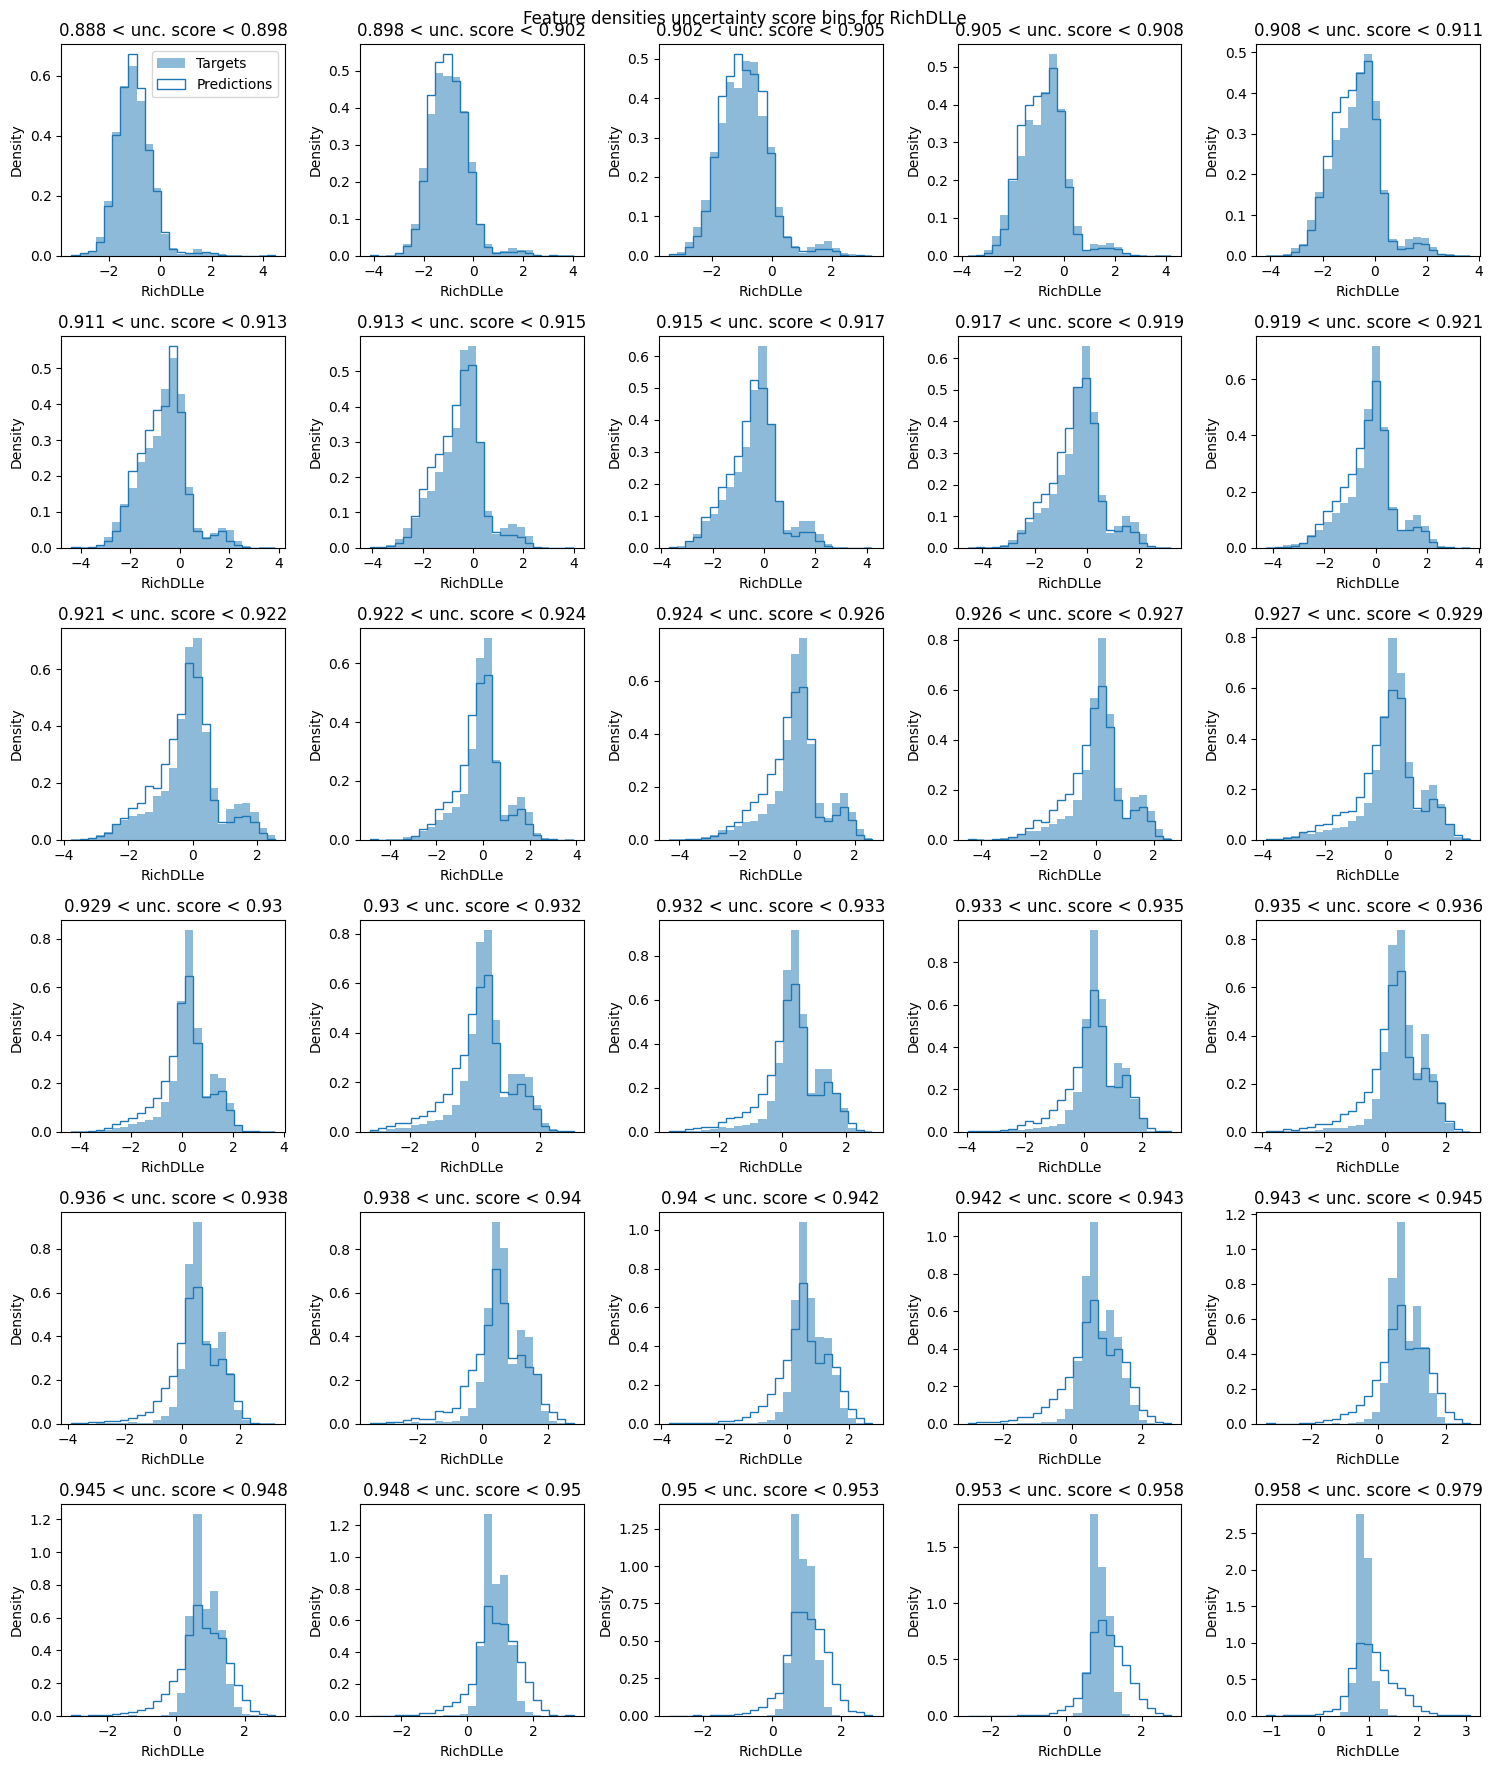

JS Distances:
0.044602504610264236, 0.0503815479300904, 0.06850363960724885, 0.07180167548368005, 0.06926104969638776, 0.07169767514957517, 0.0838703523067866, 0.08592602854053977, 0.08558086798494272, 0.09056155014573754, 0.10297789603073185, 0.10622364217221601, 0.12672544375528239, 0.1247251921867866, 0.12370618770319014, 0.12413833382141881, 0.14160615775144425, 0.15046993345380325, 0.16063463506379116, 0.16671709788475772, 0.18895741696393992, 0.19472752940114285, 0.22150276058646637, 0.23544419009747308, 0.2486435929585297, 0.26336501674812973, 0.283140183195094, 0.303495953123213, 0.3567317088609955, 0.4189882230164113
0.888 < unc. score < 0.898: Number of observations: 3334
0.898 < unc. score < 0.902: Number of observations: 3333
0.902 < unc. score < 0.905: Number of observations: 3333
0.905 < unc. score < 0.908: Number of observations: 3334
0.908 < unc. score < 0.911: Number of observations: 3333
0.911 < unc. score < 0.913: Number of observations: 3333
0.913 < unc. score < 0.9

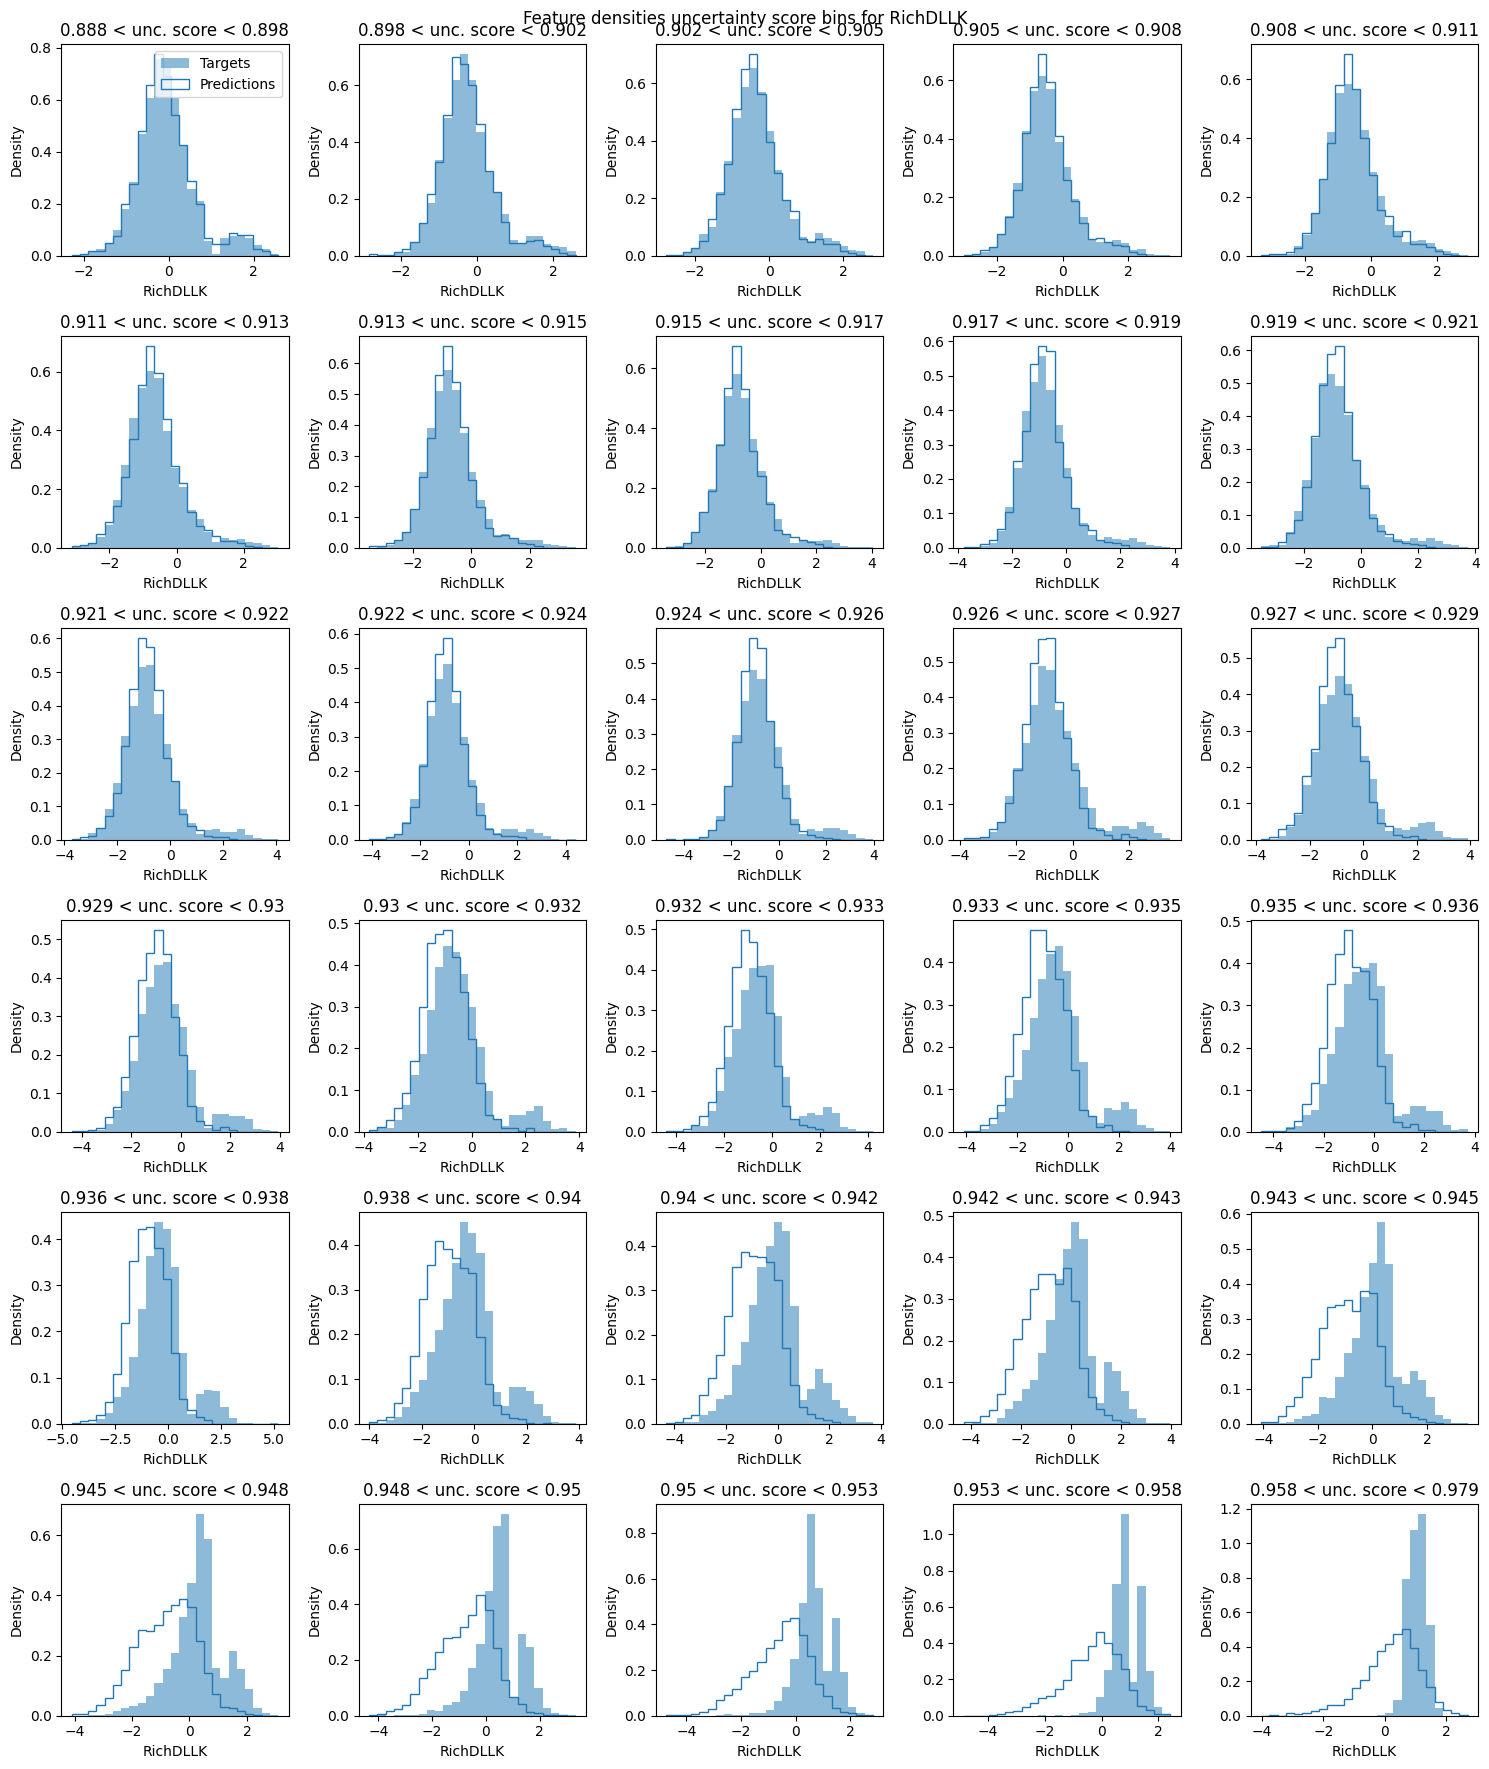

JS Distances:
0.05501889814942676, 0.05639687807690001, 0.05557619510166878, 0.05316312047942162, 0.06169763865546375, 0.06884091439466096, 0.0780394213847952, 0.0849369162050866, 0.10179682465540496, 0.10126130237375348, 0.11547444738827538, 0.11162503439554983, 0.12784482399272393, 0.1458180574583072, 0.15191238639211083, 0.1684317308732861, 0.17660306623524943, 0.1935454070526906, 0.2126713313586858, 0.21690447631481025, 0.25273126918047456, 0.25100170441049824, 0.28740715835070973, 0.3146007147908155, 0.3503052775280501, 0.38143927861494065, 0.44425313138801387, 0.4764905488000857, 0.5356337131977932, 0.5104309099661468
0.888 < unc. score < 0.898: Number of observations: 3334
0.898 < unc. score < 0.902: Number of observations: 3333
0.902 < unc. score < 0.905: Number of observations: 3333
0.905 < unc. score < 0.908: Number of observations: 3334
0.908 < unc. score < 0.911: Number of observations: 3333
0.911 < unc. score < 0.913: Number of observations: 3333
0.913 < unc. score < 0.915

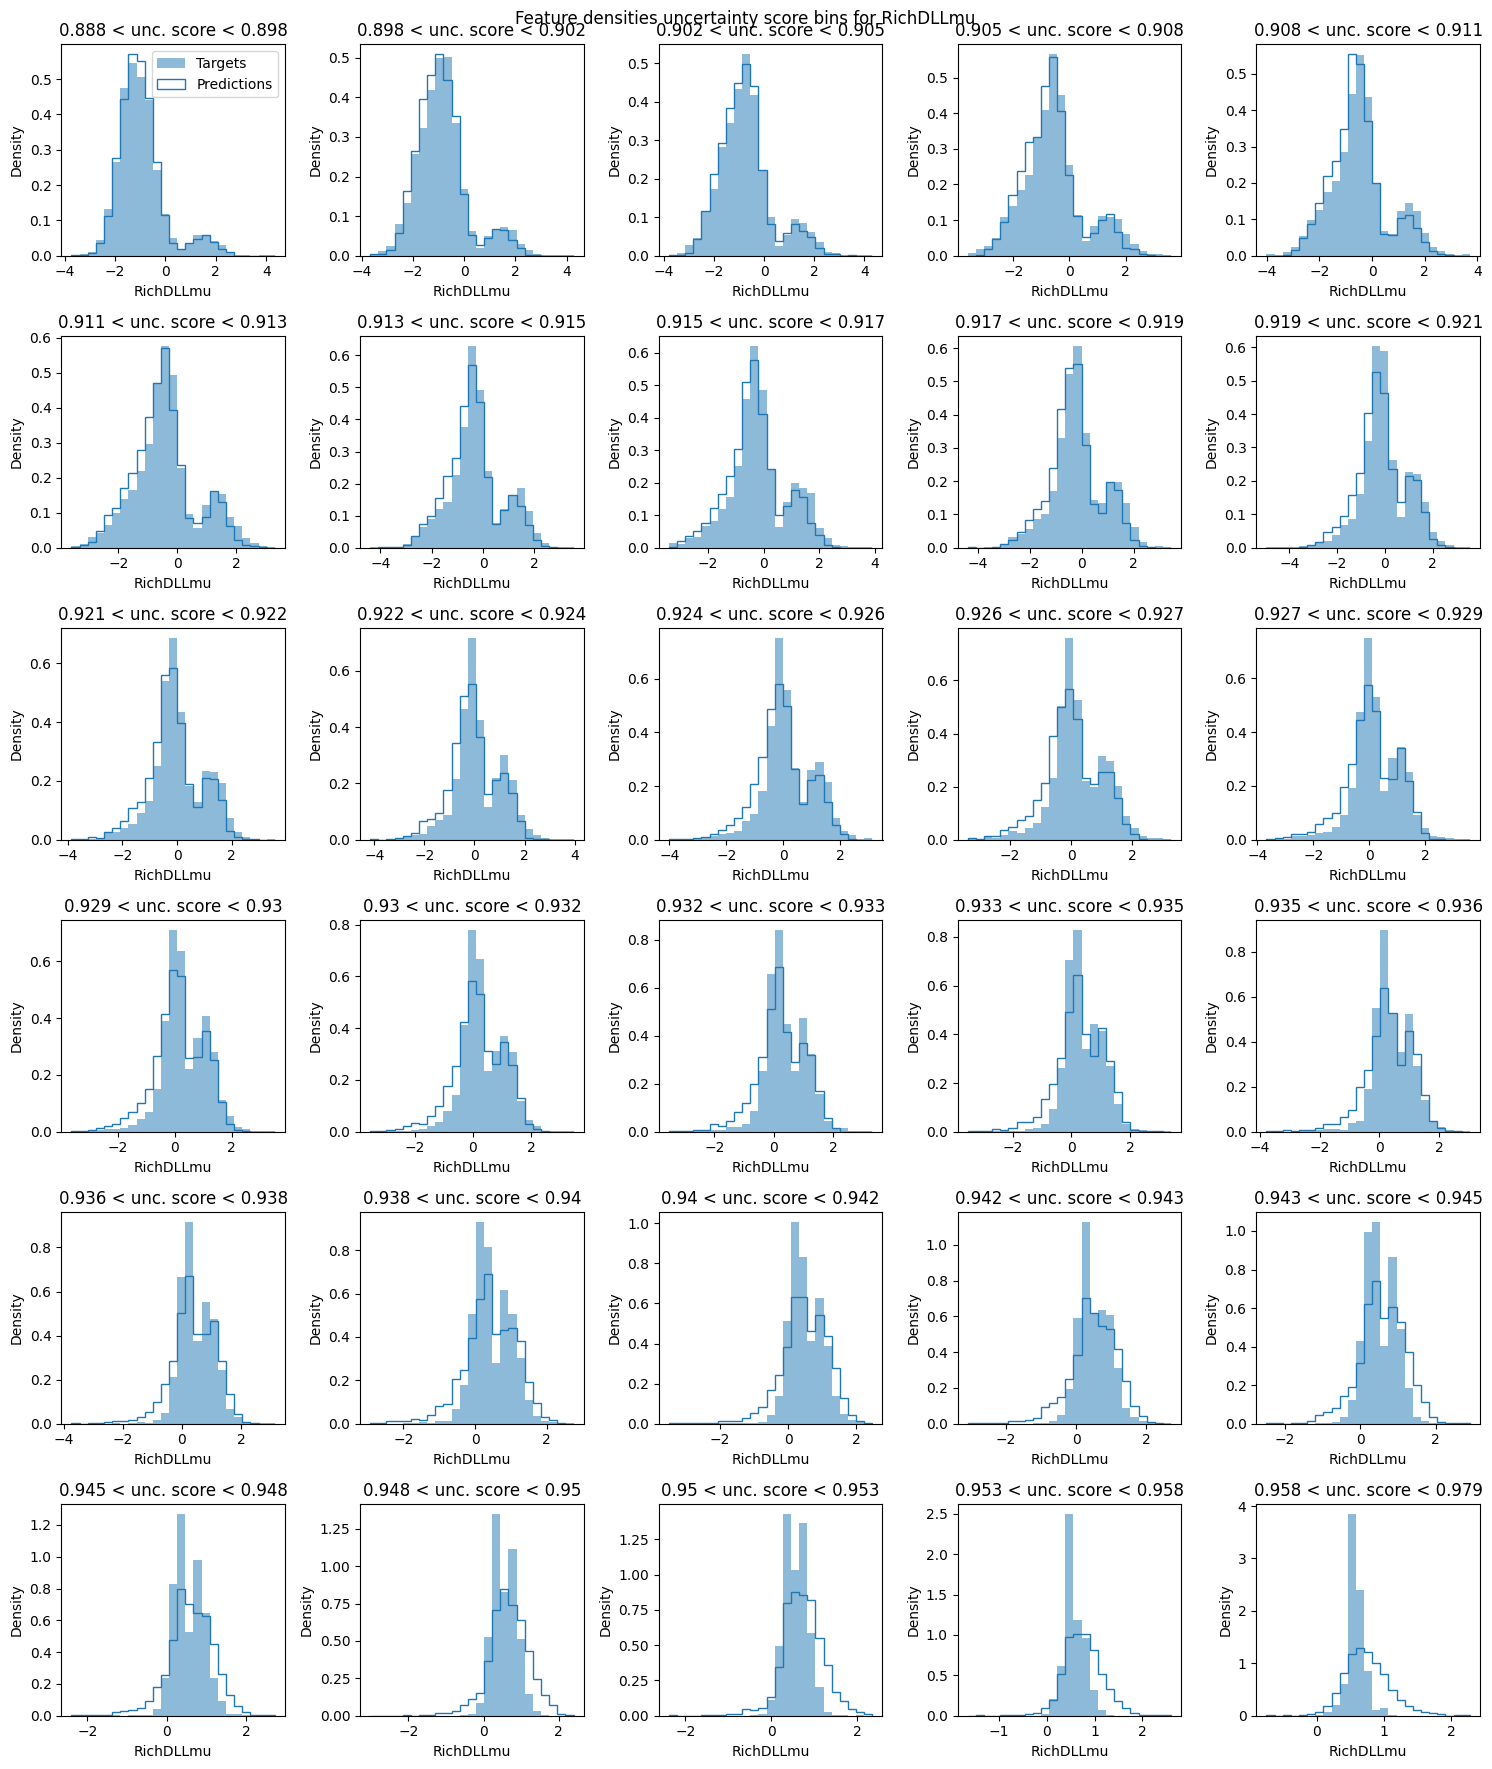

JS Distances:
0.04617725747671285, 0.06640955740720267, 0.06263288180419016, 0.08943948669263103, 0.08643396557017255, 0.08708590520711218, 0.08001261055411013, 0.1018206676415, 0.09183476865971132, 0.1030692296440237, 0.10072266349903435, 0.12471095437794331, 0.12321794430931081, 0.12700976761758942, 0.11853573786212603, 0.11946422098626581, 0.13382250054661232, 0.13792864280605419, 0.15006673541481394, 0.1529173019810137, 0.16546608393287063, 0.1778164073330513, 0.1802106199443522, 0.19626564638996155, 0.2158847999769599, 0.2300561947733227, 0.25463715315384905, 0.2681171469591083, 0.31343452559338936, 0.3912486412126158
0.888 < unc. score < 0.898: Number of observations: 3334
0.898 < unc. score < 0.902: Number of observations: 3333
0.902 < unc. score < 0.905: Number of observations: 3333
0.905 < unc. score < 0.908: Number of observations: 3334
0.908 < unc. score < 0.911: Number of observations: 3333
0.911 < unc. score < 0.913: Number of observations: 3333
0.913 < unc. score < 0.915:

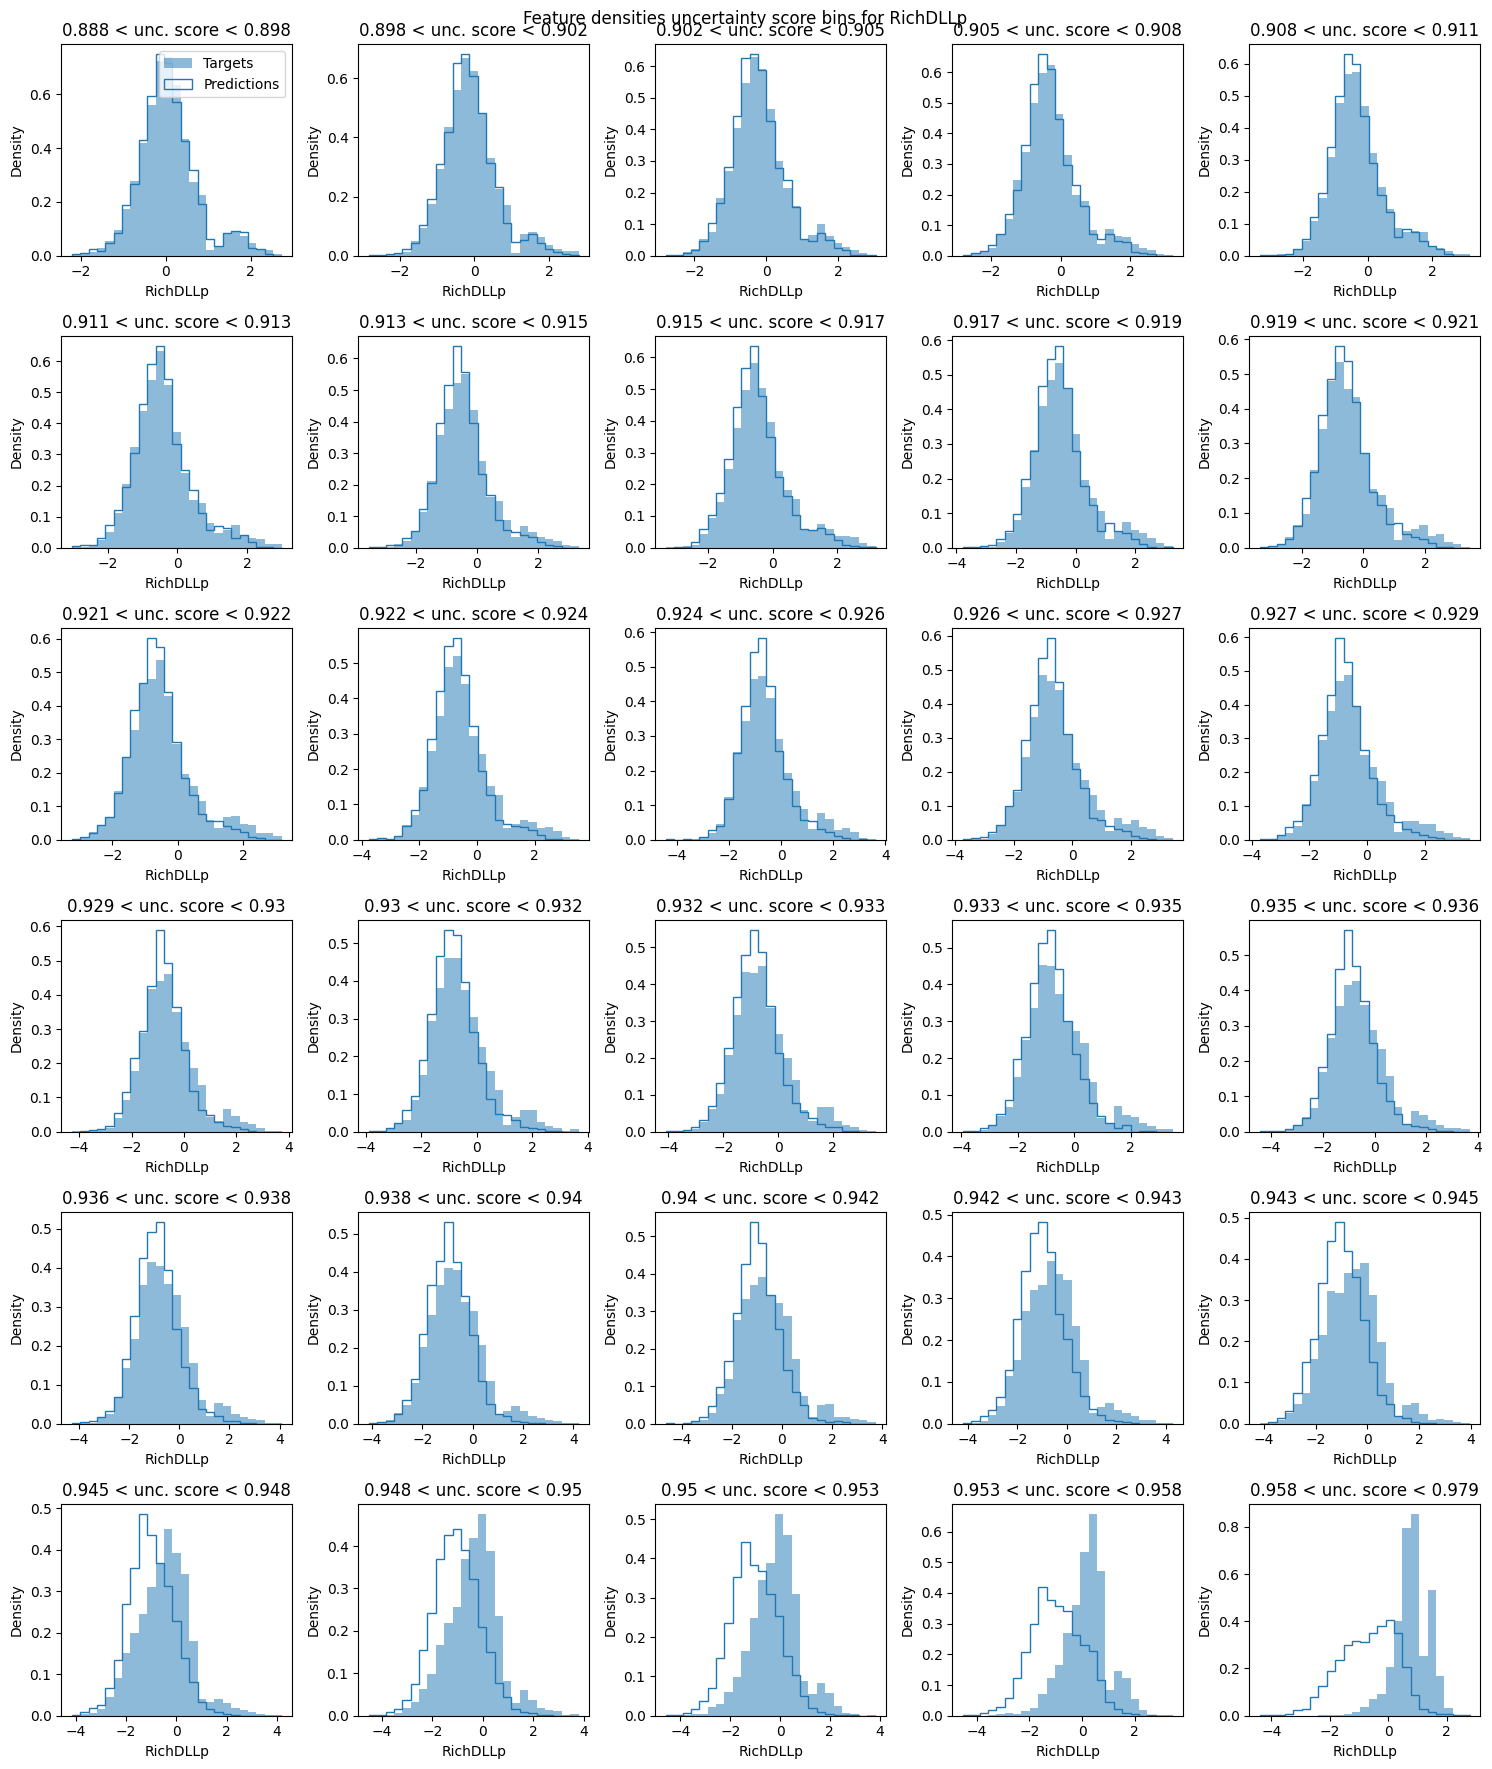

JS Distances:
0.05456652453171675, 0.07421813929156502, 0.056143443499929814, 0.06531388881919763, 0.05675414210304926, 0.07624925349750747, 0.09155463397393285, 0.08177699092000064, 0.10850618883880443, 0.10620235358457218, 0.09930187923646165, 0.1059758580612778, 0.11527600273695962, 0.11969256169018722, 0.11772279245885978, 0.1230785650910689, 0.12729994263744004, 0.11802569118724453, 0.1375713329688991, 0.13282211318053186, 0.1351778846500307, 0.13346151257641672, 0.15740801369411087, 0.172040973766595, 0.18838035053599855, 0.20744501737265816, 0.2549610822180489, 0.3080882079780342, 0.4111200233491512, 0.5622306395058813
0.888 < unc. score < 0.898: Number of observations: 3334
0.898 < unc. score < 0.902: Number of observations: 3333
0.902 < unc. score < 0.905: Number of observations: 3333
0.905 < unc. score < 0.908: Number of observations: 3334
0.908 < unc. score < 0.911: Number of observations: 3333
0.911 < unc. score < 0.913: Number of observations: 3333
0.913 < unc. score < 0.9

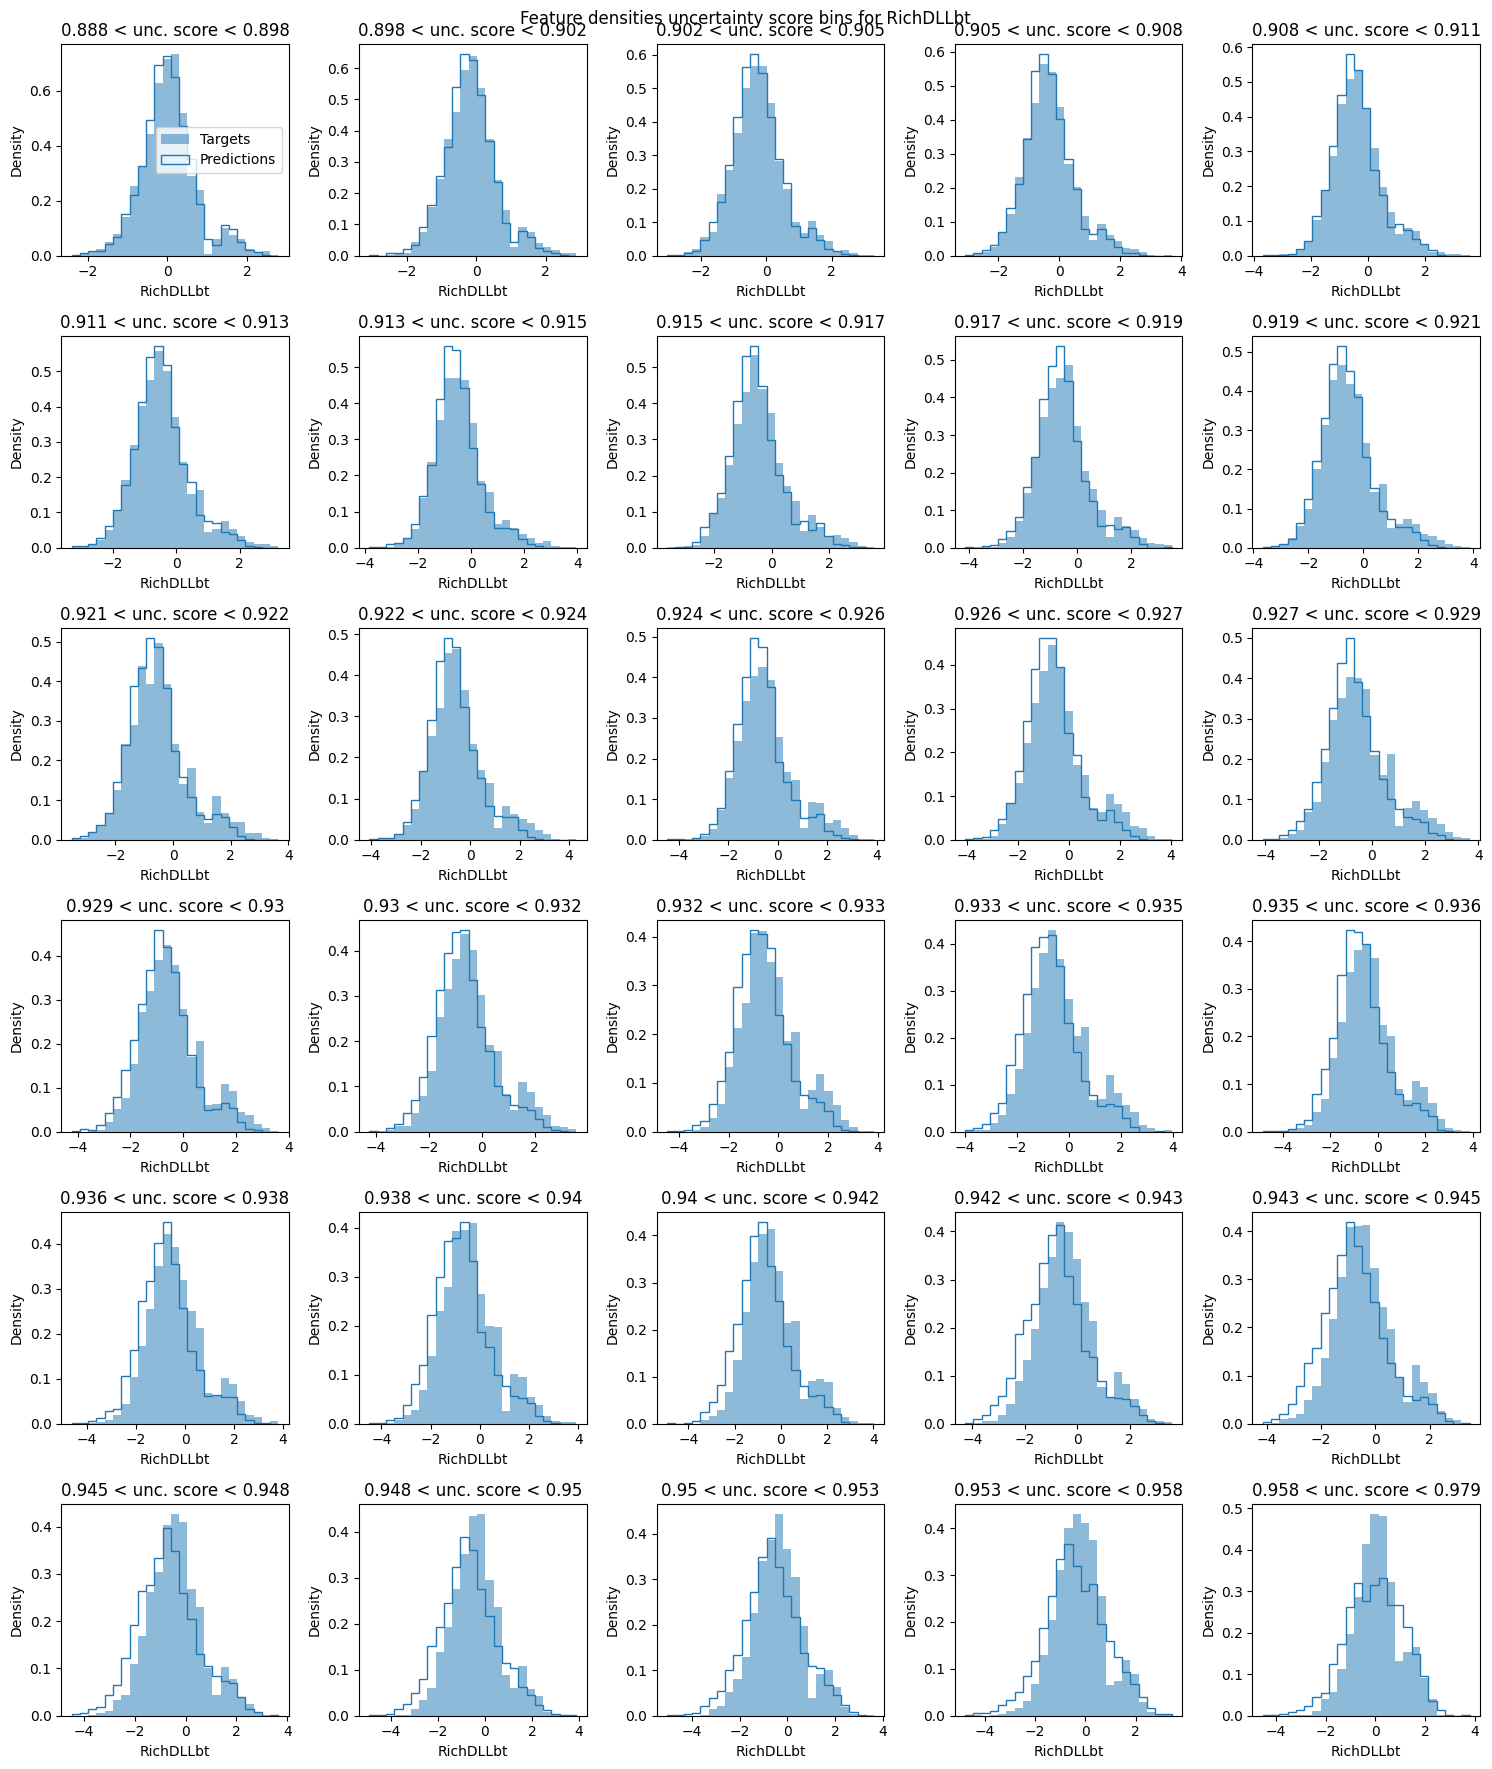

JS Distances:
0.07413385709604424, 0.06572012215525556, 0.0589087993435593, 0.06497926752551418, 0.06547026717720042, 0.07849829281099924, 0.08916811353950593, 0.09854710445619315, 0.09756630100355748, 0.09083125205735762, 0.10342289859575708, 0.10906042302408064, 0.1048697495116324, 0.11268115835545292, 0.12904995603050143, 0.11962127133723513, 0.12349403745107168, 0.13700713015508909, 0.13618306193489133, 0.12840616303157532, 0.1330226113026417, 0.14302400030880508, 0.14957914148122808, 0.14457862765885512, 0.14402706929357006, 0.1449145353141969, 0.14845239539970848, 0.1402971498448517, 0.1445094545218348, 0.15606557485062236
Correlation coefficient for RichDLLe: 0.9437450615738293
Correlation coefficient for RichDLLK: 0.935610502660067
Correlation coefficient for RichDLLmu: 0.928591320448187
Correlation coefficient for RichDLLp: 0.8151723477131098
Correlation coefficient for RichDLLbt: 0.9447686606036088


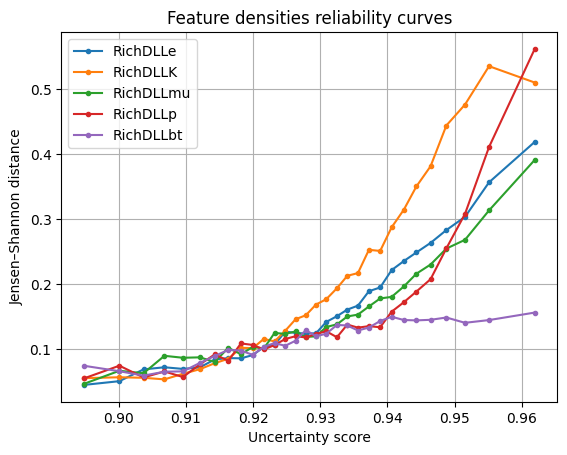

In [ ]:
all_fd_mean_unc_scores, all_fd_js_distances = [], []

for i in range(5):
  fd_mean_unc_scores, fd_js_distances = estimate_distances_and_plot_uncertainty_bins(
      y_sample, t_generated, fd_uncertainty, 'Feature densities', 'quantiles', particle_index=i, metric='JS', n_rows=6, n_cols=5)

  all_fd_mean_unc_scores += [fd_mean_unc_scores]
  all_fd_js_distances += [fd_js_distances]

plot_all_distances(all_fd_mean_unc_scores, all_fd_js_distances, 'Feature densities', metric='JS')

### FD using KS

<ipython-input-21-f34132092fec>:35: MatplotlibDeprecationWarning: Passing the range parameter of hist() positionally is deprecated since Matplotlib 3.9; the parameter will become keyword-only in 3.11.
  targets_hist = ax.hist(targets[indices], 25, hist_range, True, alpha=.5, label='Targets')[0]
<ipython-input-21-f34132092fec>:36: MatplotlibDeprecationWarning: Passing the range parameter of hist() positionally is deprecated since Matplotlib 3.9; the parameter will become keyword-only in 3.11.
  predictions_hist = ax.hist(


0.888 < unc. score < 0.905: Number of observations: 10000
0.905 < unc. score < 0.913: Number of observations: 10000
0.913 < unc. score < 0.919: Number of observations: 10000
0.919 < unc. score < 0.924: Number of observations: 10000
0.924 < unc. score < 0.929: Number of observations: 10000
0.929 < unc. score < 0.933: Number of observations: 10000
0.933 < unc. score < 0.938: Number of observations: 10000
0.938 < unc. score < 0.943: Number of observations: 10000
0.943 < unc. score < 0.95: Number of observations: 10000
0.95 < unc. score < 0.979: Number of observations: 9999


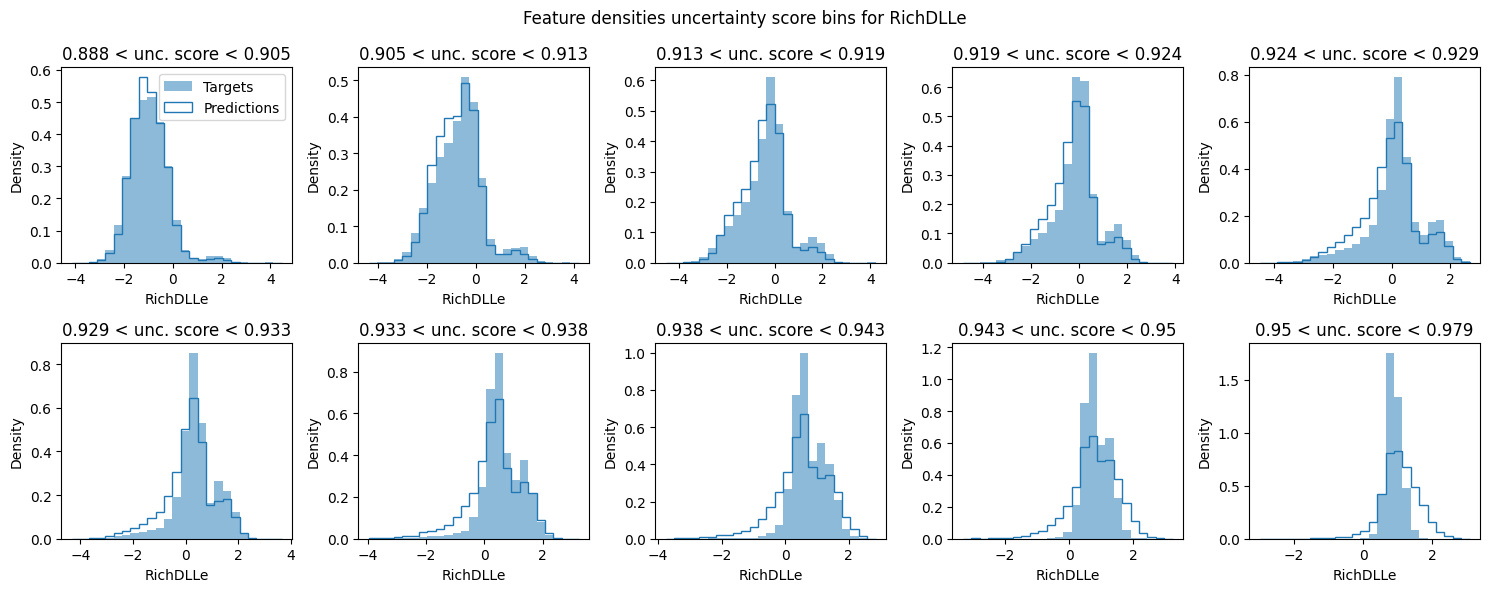

KS Distances:
0.0207, 0.0488, 0.082, 0.1104, 0.1433, 0.1585, 0.1716, 0.1808, 0.1588, 0.2859285928592859
0.888 < unc. score < 0.905: Number of observations: 10000
0.905 < unc. score < 0.913: Number of observations: 10000
0.913 < unc. score < 0.919: Number of observations: 10000
0.919 < unc. score < 0.924: Number of observations: 10000
0.924 < unc. score < 0.929: Number of observations: 10000
0.929 < unc. score < 0.933: Number of observations: 10000
0.933 < unc. score < 0.938: Number of observations: 10000
0.938 < unc. score < 0.943: Number of observations: 10000
0.943 < unc. score < 0.95: Number of observations: 10000
0.95 < unc. score < 0.979: Number of observations: 9999


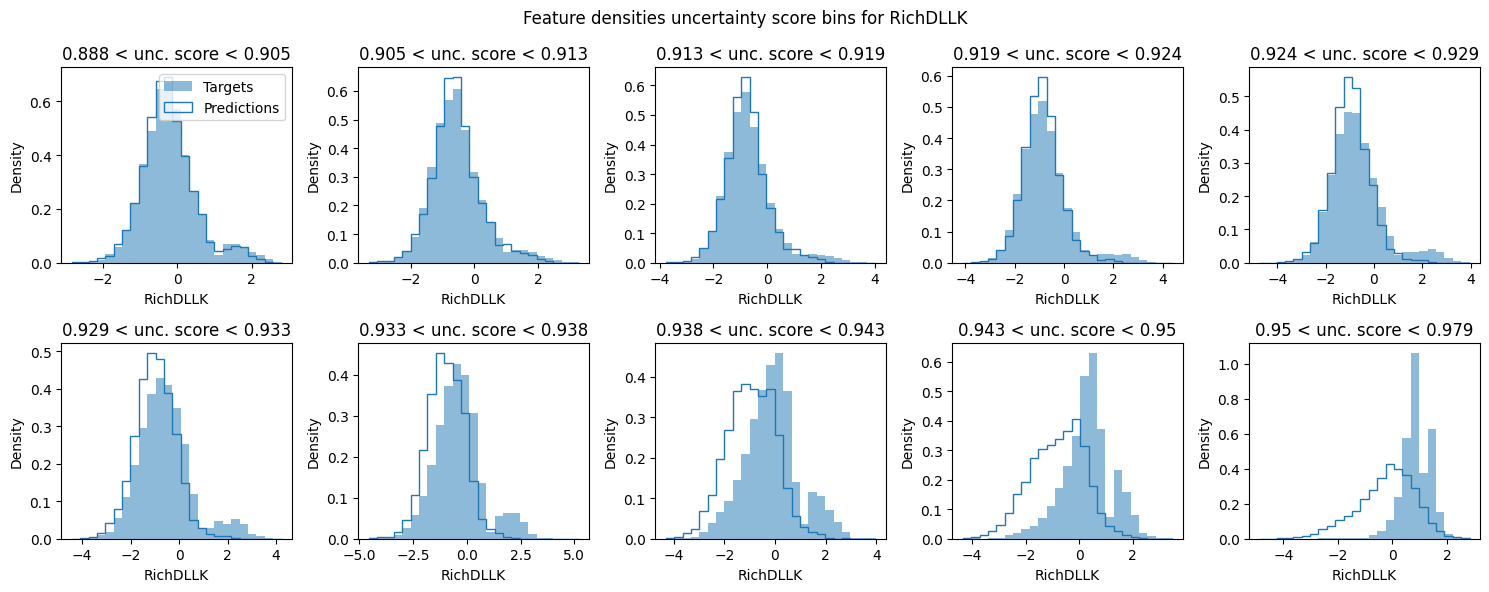

KS Distances:
0.027, 0.0228, 0.0439, 0.057, 0.1001, 0.164, 0.2353, 0.3131, 0.461, 0.5651565156515651
0.888 < unc. score < 0.905: Number of observations: 10000
0.905 < unc. score < 0.913: Number of observations: 10000
0.913 < unc. score < 0.919: Number of observations: 10000
0.919 < unc. score < 0.924: Number of observations: 10000
0.924 < unc. score < 0.929: Number of observations: 10000
0.929 < unc. score < 0.933: Number of observations: 10000
0.933 < unc. score < 0.938: Number of observations: 10000
0.938 < unc. score < 0.943: Number of observations: 10000
0.943 < unc. score < 0.95: Number of observations: 10000
0.95 < unc. score < 0.979: Number of observations: 9999


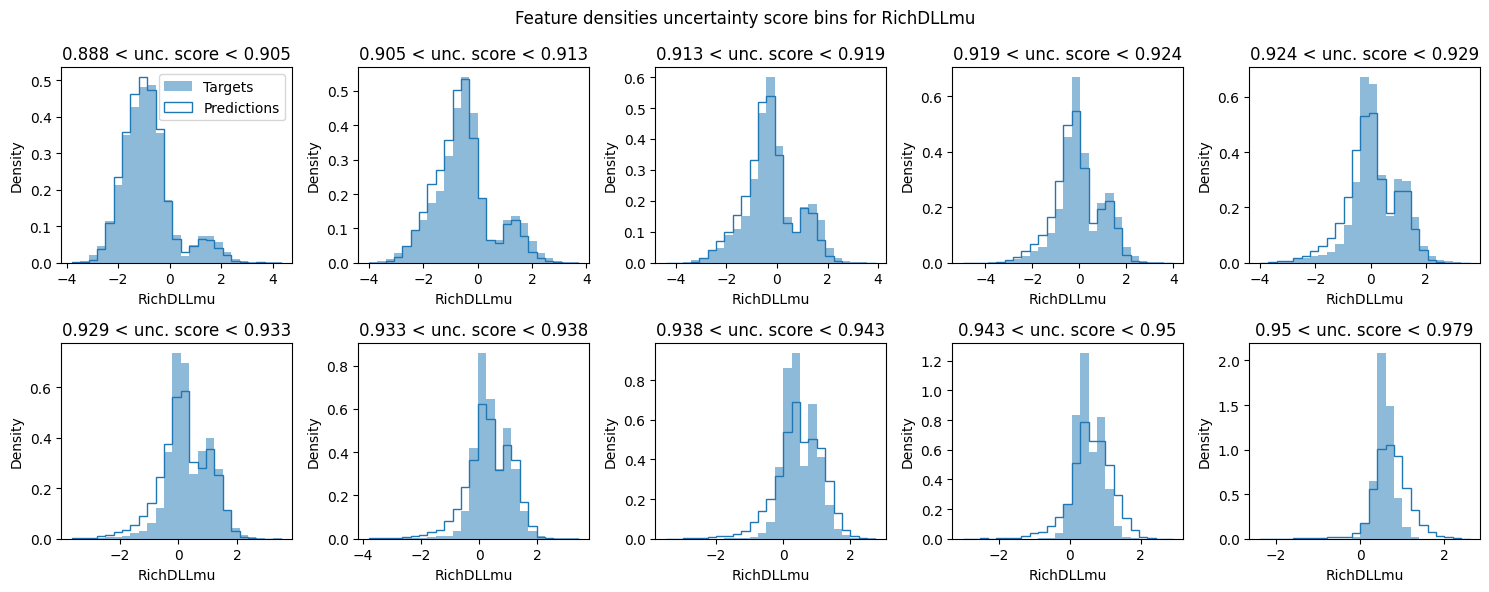

KS Distances:
0.03, 0.0702, 0.0846, 0.1076, 0.1286, 0.1182, 0.1131, 0.1051, 0.1446, 0.3031303130313031
0.888 < unc. score < 0.905: Number of observations: 10000
0.905 < unc. score < 0.913: Number of observations: 10000
0.913 < unc. score < 0.919: Number of observations: 10000
0.919 < unc. score < 0.924: Number of observations: 10000
0.924 < unc. score < 0.929: Number of observations: 10000
0.929 < unc. score < 0.933: Number of observations: 10000
0.933 < unc. score < 0.938: Number of observations: 10000
0.938 < unc. score < 0.943: Number of observations: 10000
0.943 < unc. score < 0.95: Number of observations: 10000
0.95 < unc. score < 0.979: Number of observations: 9999


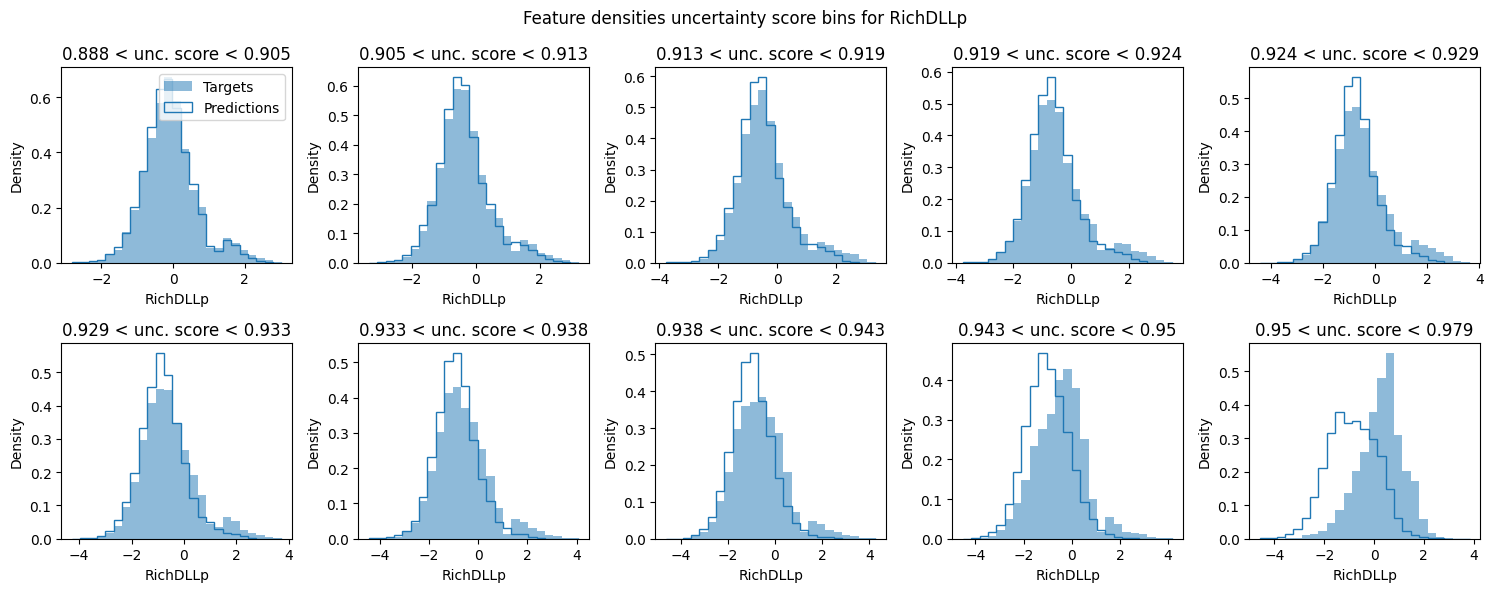

KS Distances:
0.0303, 0.04, 0.0718, 0.0673, 0.0871, 0.101, 0.1298, 0.1572, 0.2579, 0.46844684468446846
0.888 < unc. score < 0.905: Number of observations: 10000
0.905 < unc. score < 0.913: Number of observations: 10000
0.913 < unc. score < 0.919: Number of observations: 10000
0.919 < unc. score < 0.924: Number of observations: 10000
0.924 < unc. score < 0.929: Number of observations: 10000
0.929 < unc. score < 0.933: Number of observations: 10000
0.933 < unc. score < 0.938: Number of observations: 10000
0.938 < unc. score < 0.943: Number of observations: 10000
0.943 < unc. score < 0.95: Number of observations: 10000
0.95 < unc. score < 0.979: Number of observations: 9999


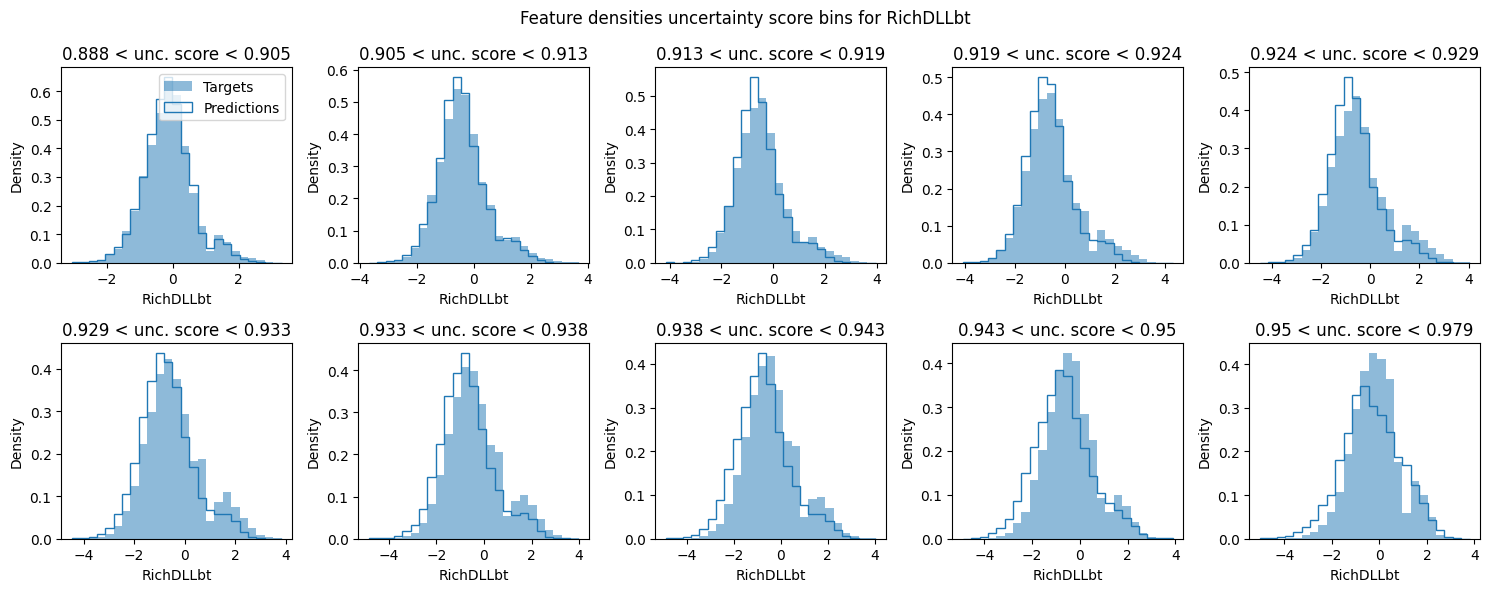

KS Distances:
0.0304, 0.0397, 0.0762, 0.0689, 0.0968, 0.1147, 0.1396, 0.1492, 0.1405, 0.11281128112811281
Correlation coefficient for RichDLLe: 0.9550064636873856
Correlation coefficient for RichDLLK: 0.9291471946789486
Correlation coefficient for RichDLLmu: 0.8336776528258693
Correlation coefficient for RichDLLp: 0.8606406397532859
Correlation coefficient for RichDLLbt: 0.864648801943924


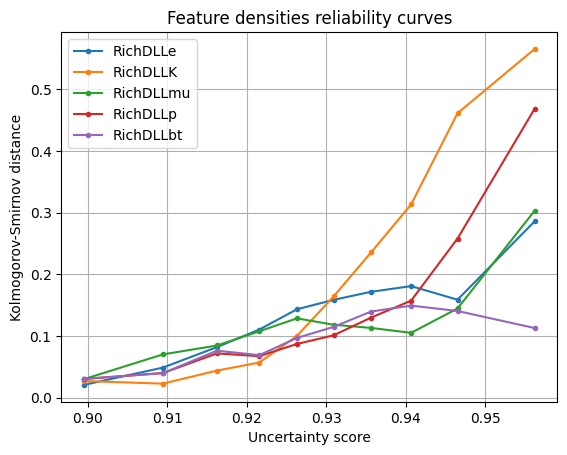

In [ ]:
all_fd_mean_unc_scores, all_fd_js_distances = [], []

for i in range(5):
  fd_mean_unc_scores, fd_js_distances = estimate_distances_and_plot_uncertainty_bins(
      y_sample, t_generated, fd_uncertainty, 'Feature densities', 'quantiles', particle_index=i, metric='KS')

  all_fd_mean_unc_scores += [fd_mean_unc_scores]
  all_fd_js_distances += [fd_js_distances]

plot_all_distances(all_fd_mean_unc_scores, all_fd_js_distances, 'Feature densities', metric='KS')

### MCD using JS

<ipython-input-9-f34132092fec>:35: MatplotlibDeprecationWarning: Passing the range parameter of hist() positionally is deprecated since Matplotlib 3.9; the parameter will become keyword-only in 3.11.
  targets_hist = ax.hist(targets[indices], 25, hist_range, True, alpha=.5, label='Targets')[0]
<ipython-input-9-f34132092fec>:36: MatplotlibDeprecationWarning: Passing the range parameter of hist() positionally is deprecated since Matplotlib 3.9; the parameter will become keyword-only in 3.11.
  predictions_hist = ax.hist(


0.251 < unc. score < 0.302: Number of observations: 3334
0.302 < unc. score < 0.321: Number of observations: 3333
0.321 < unc. score < 0.336: Number of observations: 3333
0.336 < unc. score < 0.349: Number of observations: 3334
0.349 < unc. score < 0.362: Number of observations: 3333
0.362 < unc. score < 0.375: Number of observations: 3333
0.375 < unc. score < 0.387: Number of observations: 3334
0.387 < unc. score < 0.399: Number of observations: 3333
0.399 < unc. score < 0.412: Number of observations: 3333
0.412 < unc. score < 0.425: Number of observations: 3333
0.425 < unc. score < 0.439: Number of observations: 3334
0.439 < unc. score < 0.453: Number of observations: 3333
0.453 < unc. score < 0.467: Number of observations: 3333
0.467 < unc. score < 0.481: Number of observations: 3334
0.481 < unc. score < 0.497: Number of observations: 3333
0.497 < unc. score < 0.514: Number of observations: 3333
0.514 < unc. score < 0.531: Number of observations: 3334
0.531 < unc. score < 0.55: Numb

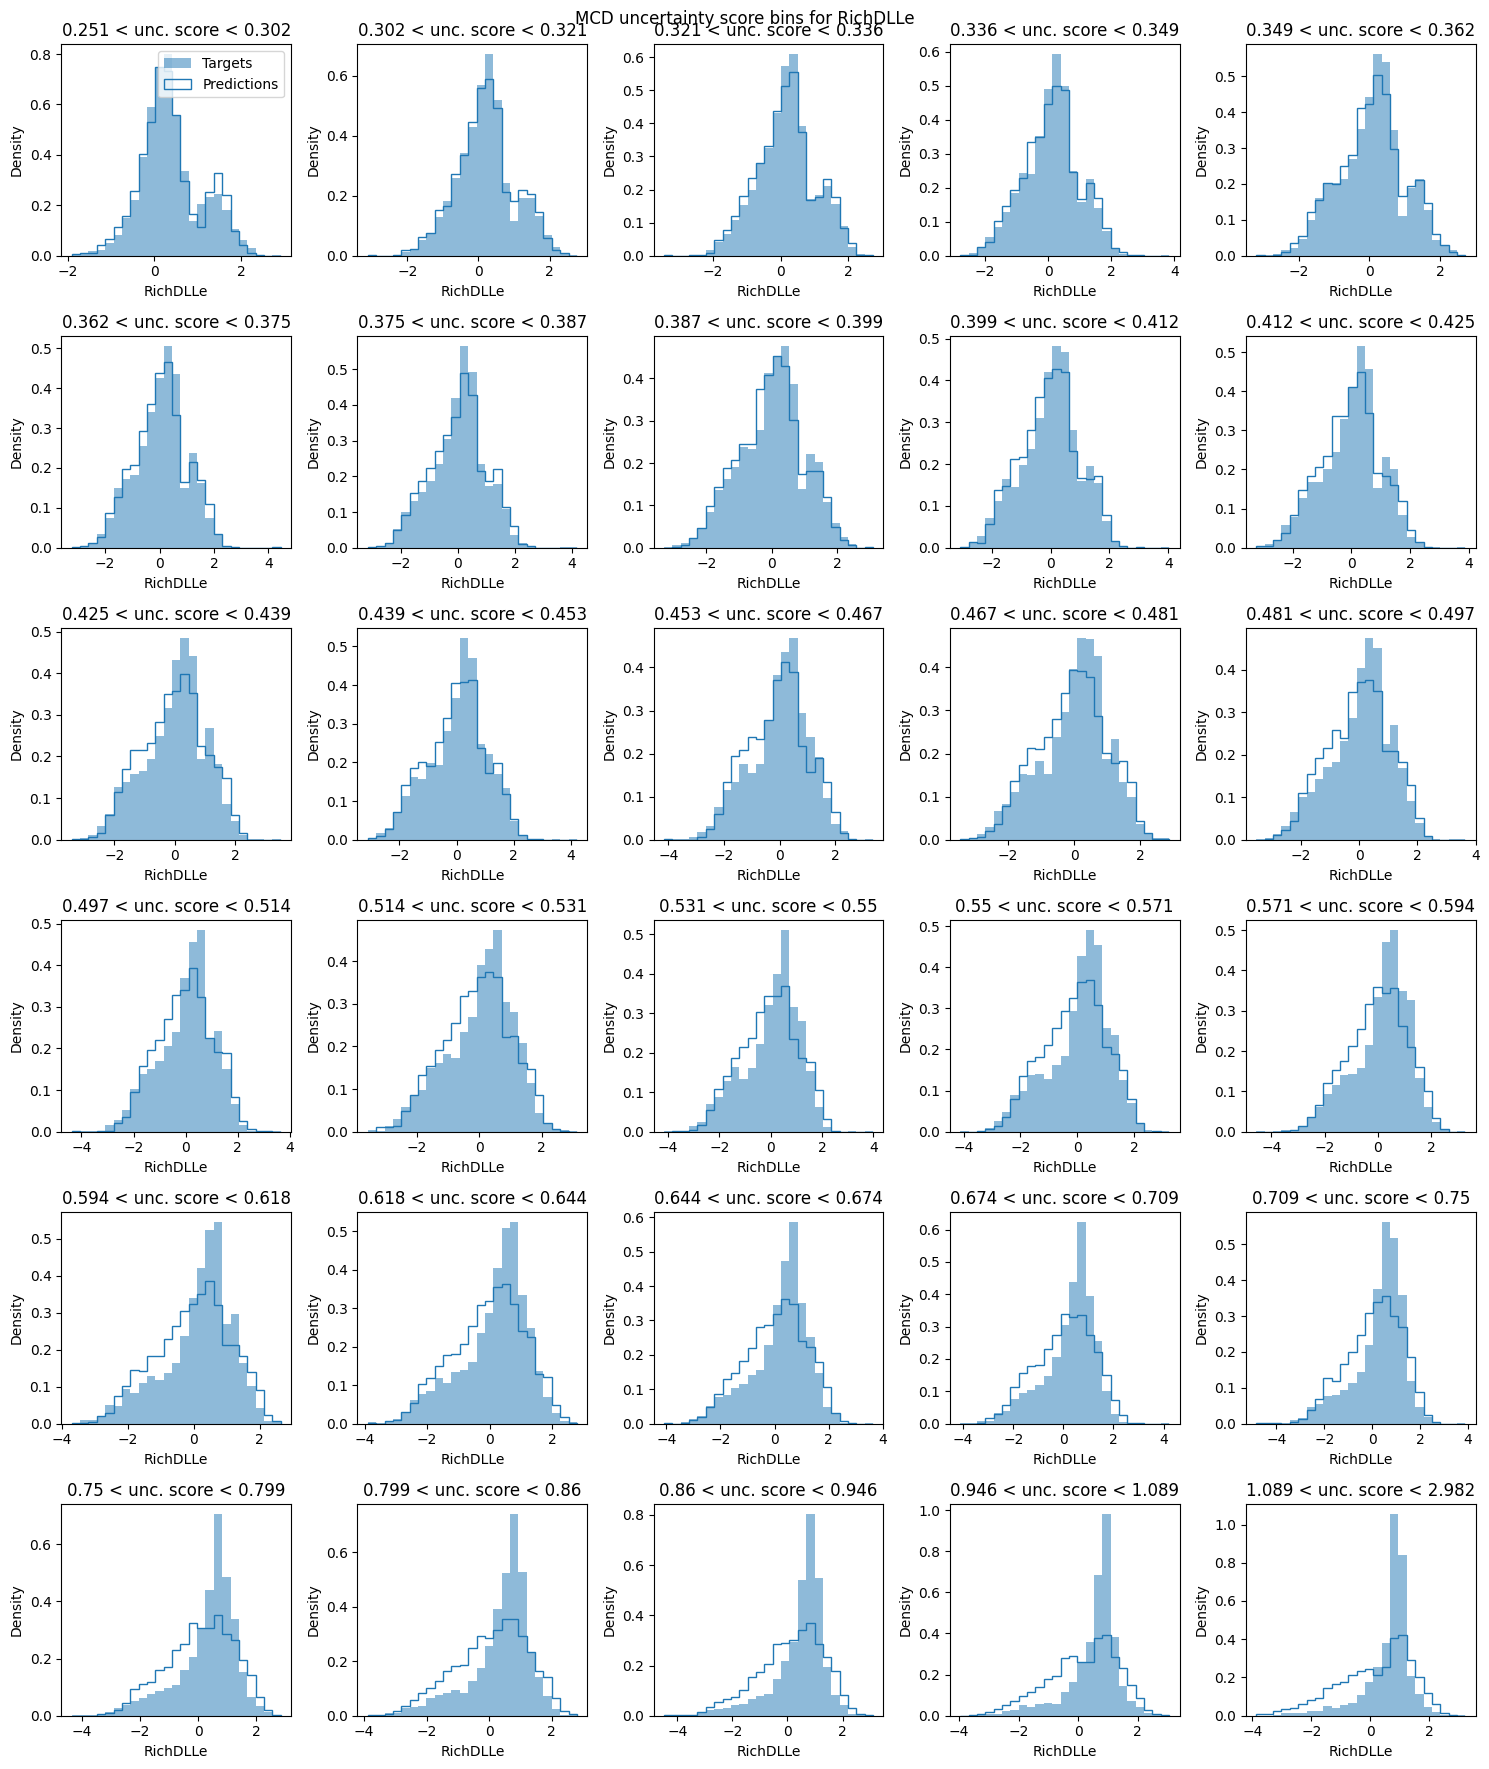

JS Distances:
0.06902559314392977, 0.04800430760783632, 0.03989687569322677, 0.05274866295202108, 0.0549832475474356, 0.05248927794129921, 0.05596466001113003, 0.05748570606848911, 0.061336176407118616, 0.07664690291189523, 0.08303988583824684, 0.06475540693616758, 0.09321032417653828, 0.08713170637266963, 0.08308457684834904, 0.0955135895254117, 0.0937942187030285, 0.10946068819657499, 0.10942787050535266, 0.11624390686354186, 0.12921154063521503, 0.12006915130087174, 0.13420965232270066, 0.1536050397004998, 0.152931211019975, 0.17615283692954212, 0.18774554874816385, 0.21496054638721374, 0.24229080822576163, 0.27444944154757794
0.053 < unc. score < 0.202: Number of observations: 3334
0.202 < unc. score < 0.232: Number of observations: 3333
0.232 < unc. score < 0.258: Number of observations: 3333
0.258 < unc. score < 0.284: Number of observations: 3334
0.284 < unc. score < 0.308: Number of observations: 3333
0.308 < unc. score < 0.331: Number of observations: 3333
0.331 < unc. score <

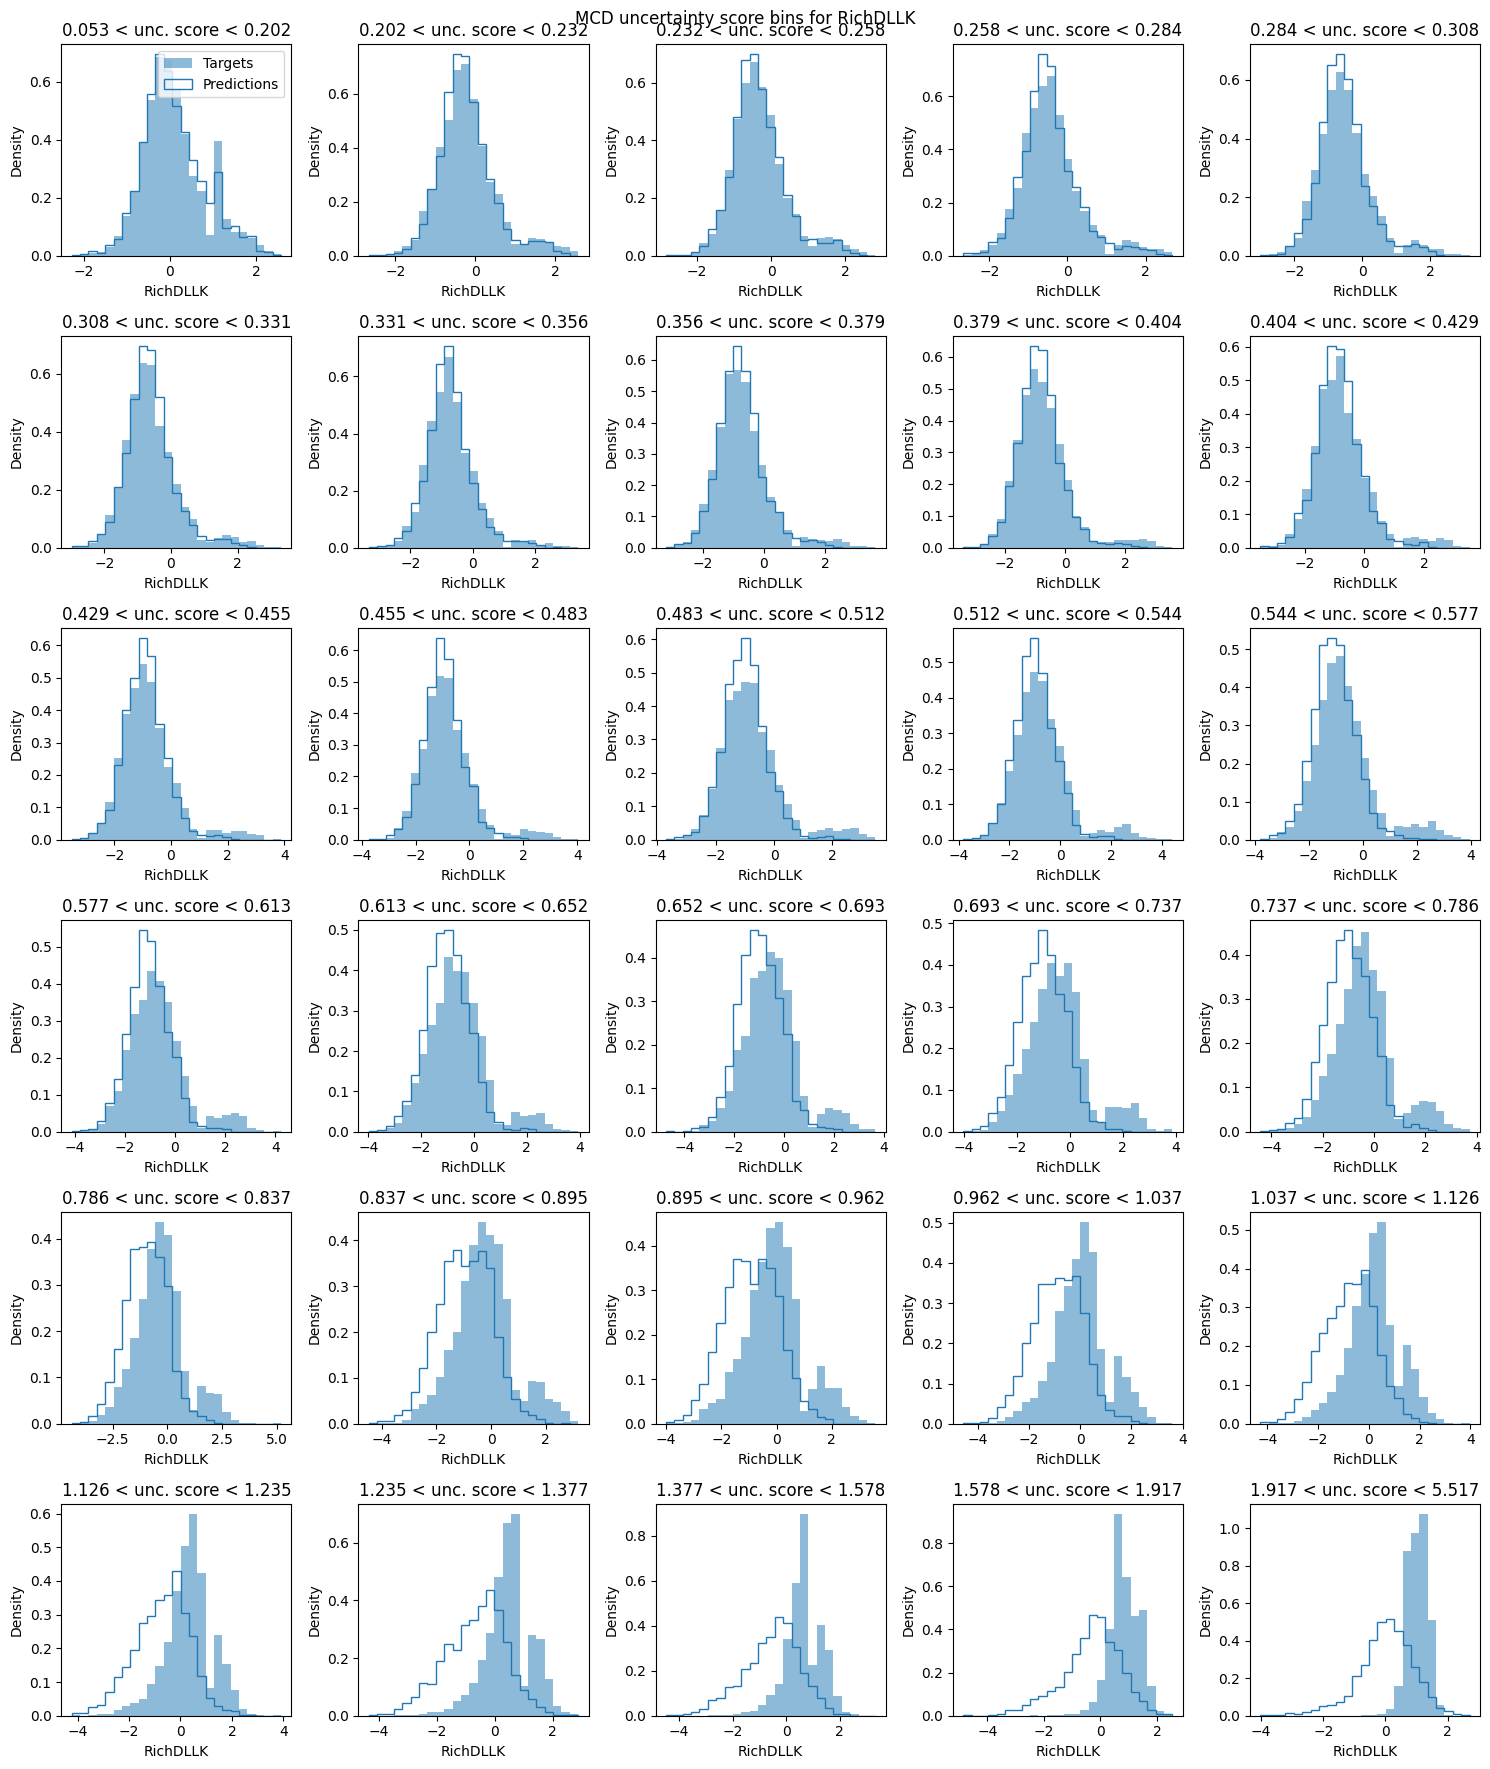

JS Distances:
0.07031401583593479, 0.06547548014972841, 0.05783109140838563, 0.07892740545400932, 0.08353957093670039, 0.07458518592912466, 0.08118702101949289, 0.08862580500205423, 0.09090483147331099, 0.11290206625044068, 0.11406870427189204, 0.1302946318034393, 0.13138014797208653, 0.1333695675083937, 0.16336159410997536, 0.16810119486315392, 0.17817731176353388, 0.19155668604234705, 0.2263584718649045, 0.22707708390867415, 0.23414116686829875, 0.25263418556482603, 0.2922399602923258, 0.3117931107373636, 0.33211215215976375, 0.36271501663318906, 0.4171924651384023, 0.45654939863744265, 0.4946861592392723, 0.5566575846987181
0.196 < unc. score < 0.236: Number of observations: 3334
0.236 < unc. score < 0.254: Number of observations: 3333
0.254 < unc. score < 0.269: Number of observations: 3333
0.269 < unc. score < 0.282: Number of observations: 3334
0.282 < unc. score < 0.295: Number of observations: 3333
0.295 < unc. score < 0.308: Number of observations: 3333
0.308 < unc. score < 0.

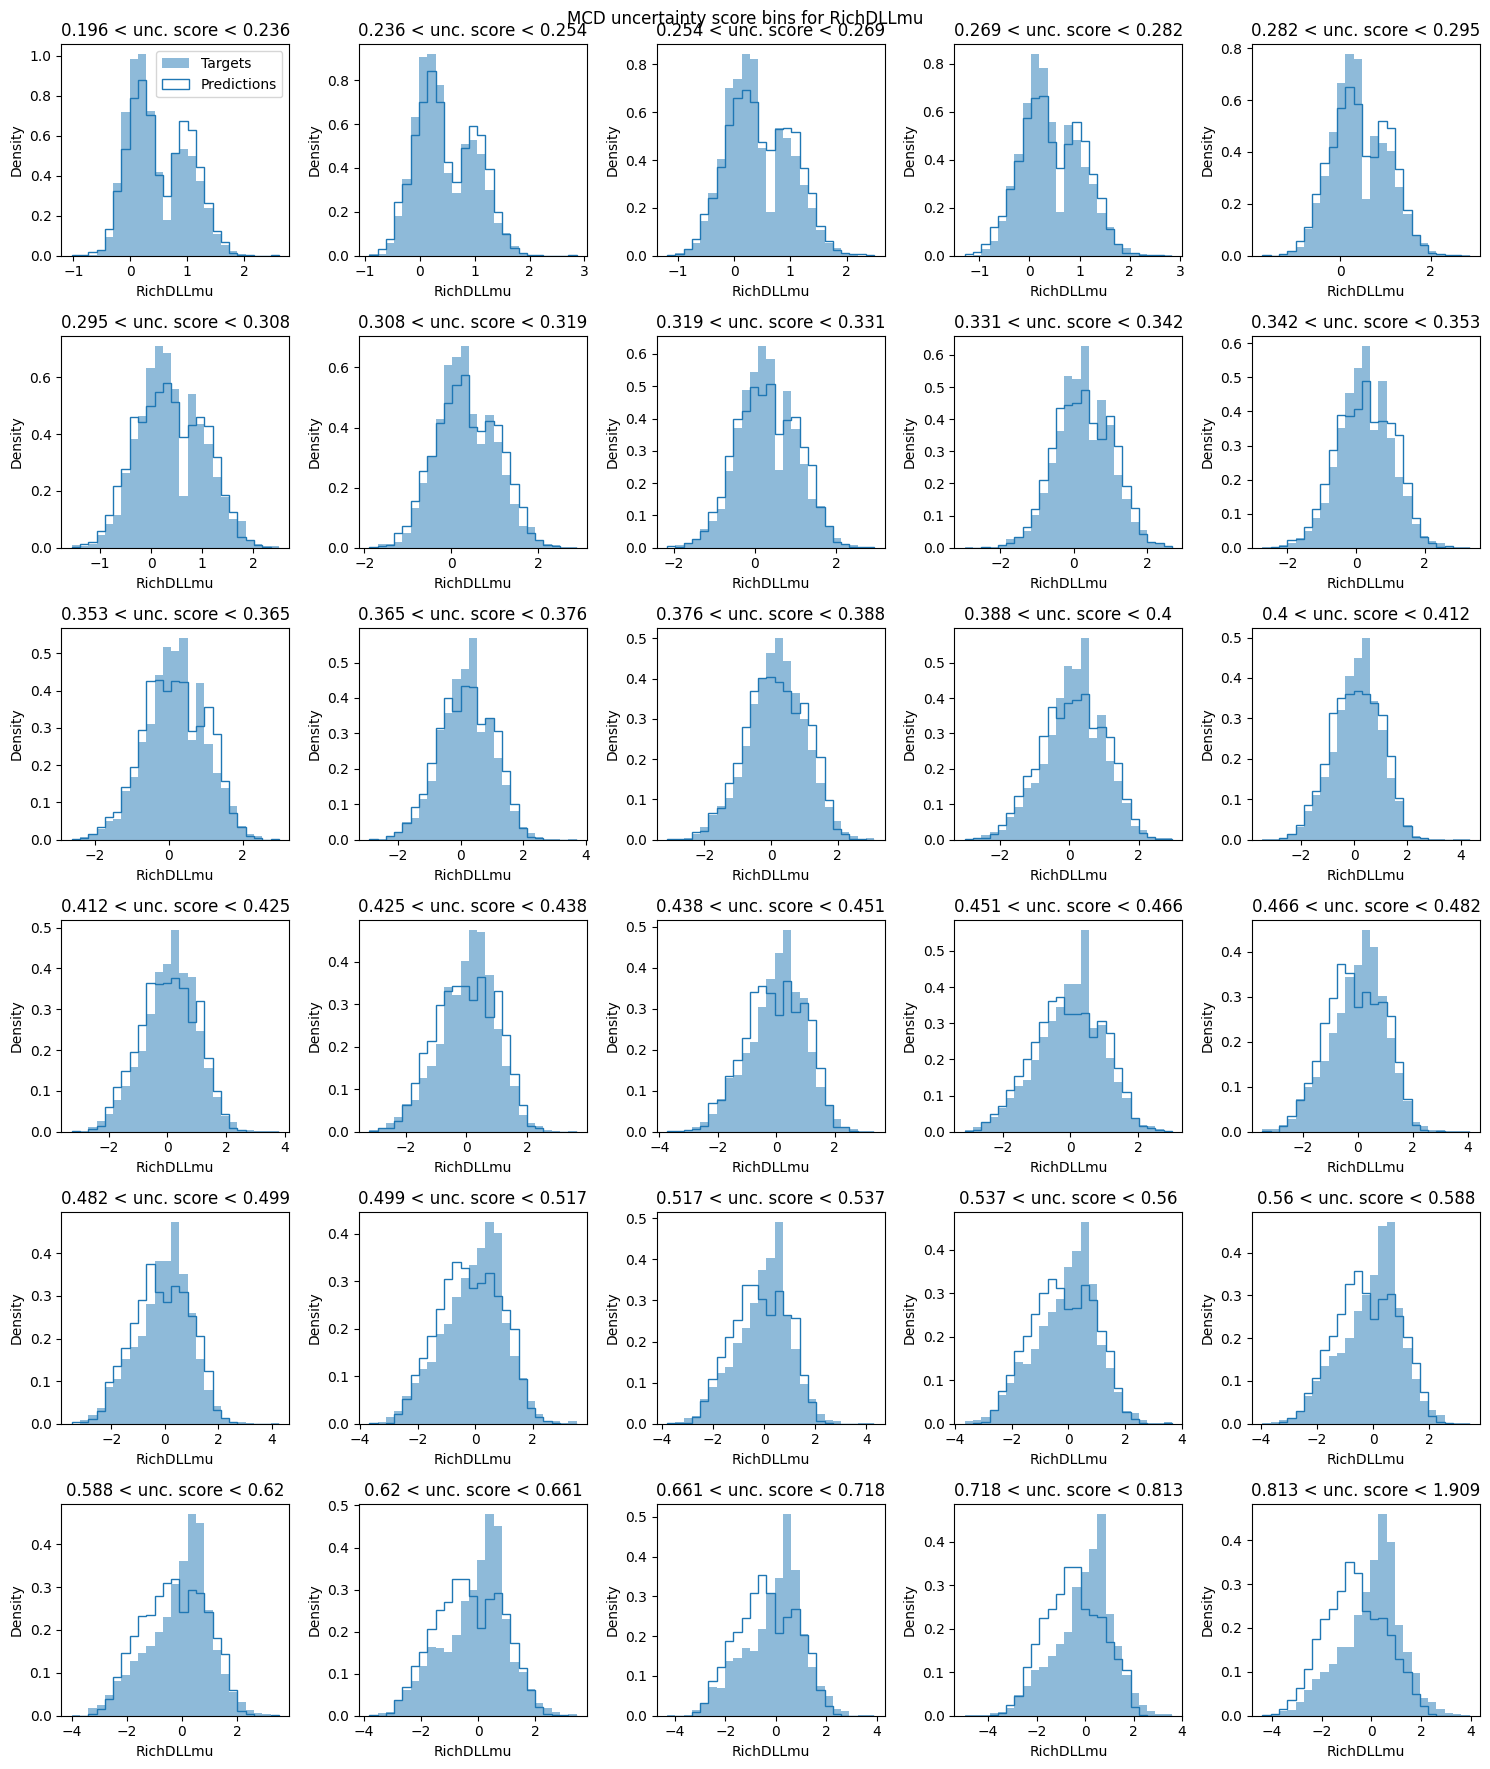

JS Distances:
0.07779436267049615, 0.06431839689723319, 0.09142552324085879, 0.09341364047505823, 0.081609181794819, 0.10020304075350502, 0.07403271861306683, 0.08237411158650586, 0.07841127286801569, 0.08781791263550805, 0.08574279739172716, 0.07274653934757129, 0.07415640181456894, 0.08454347960759916, 0.08348318180079216, 0.08897239640201919, 0.10846917675462381, 0.09994137727791726, 0.09001712064513463, 0.10680728780655112, 0.10245426750524565, 0.10467486789454082, 0.11991336729721928, 0.11026795612492857, 0.12502612829424609, 0.13423740990569066, 0.14383734942057383, 0.16158134537188662, 0.1823342721054469, 0.22292589491027956
0.048 < unc. score < 0.206: Number of observations: 3334
0.206 < unc. score < 0.235: Number of observations: 3333
0.235 < unc. score < 0.259: Number of observations: 3333
0.259 < unc. score < 0.281: Number of observations: 3334
0.281 < unc. score < 0.301: Number of observations: 3333
0.301 < unc. score < 0.32: Number of observations: 3333
0.32 < unc. score <

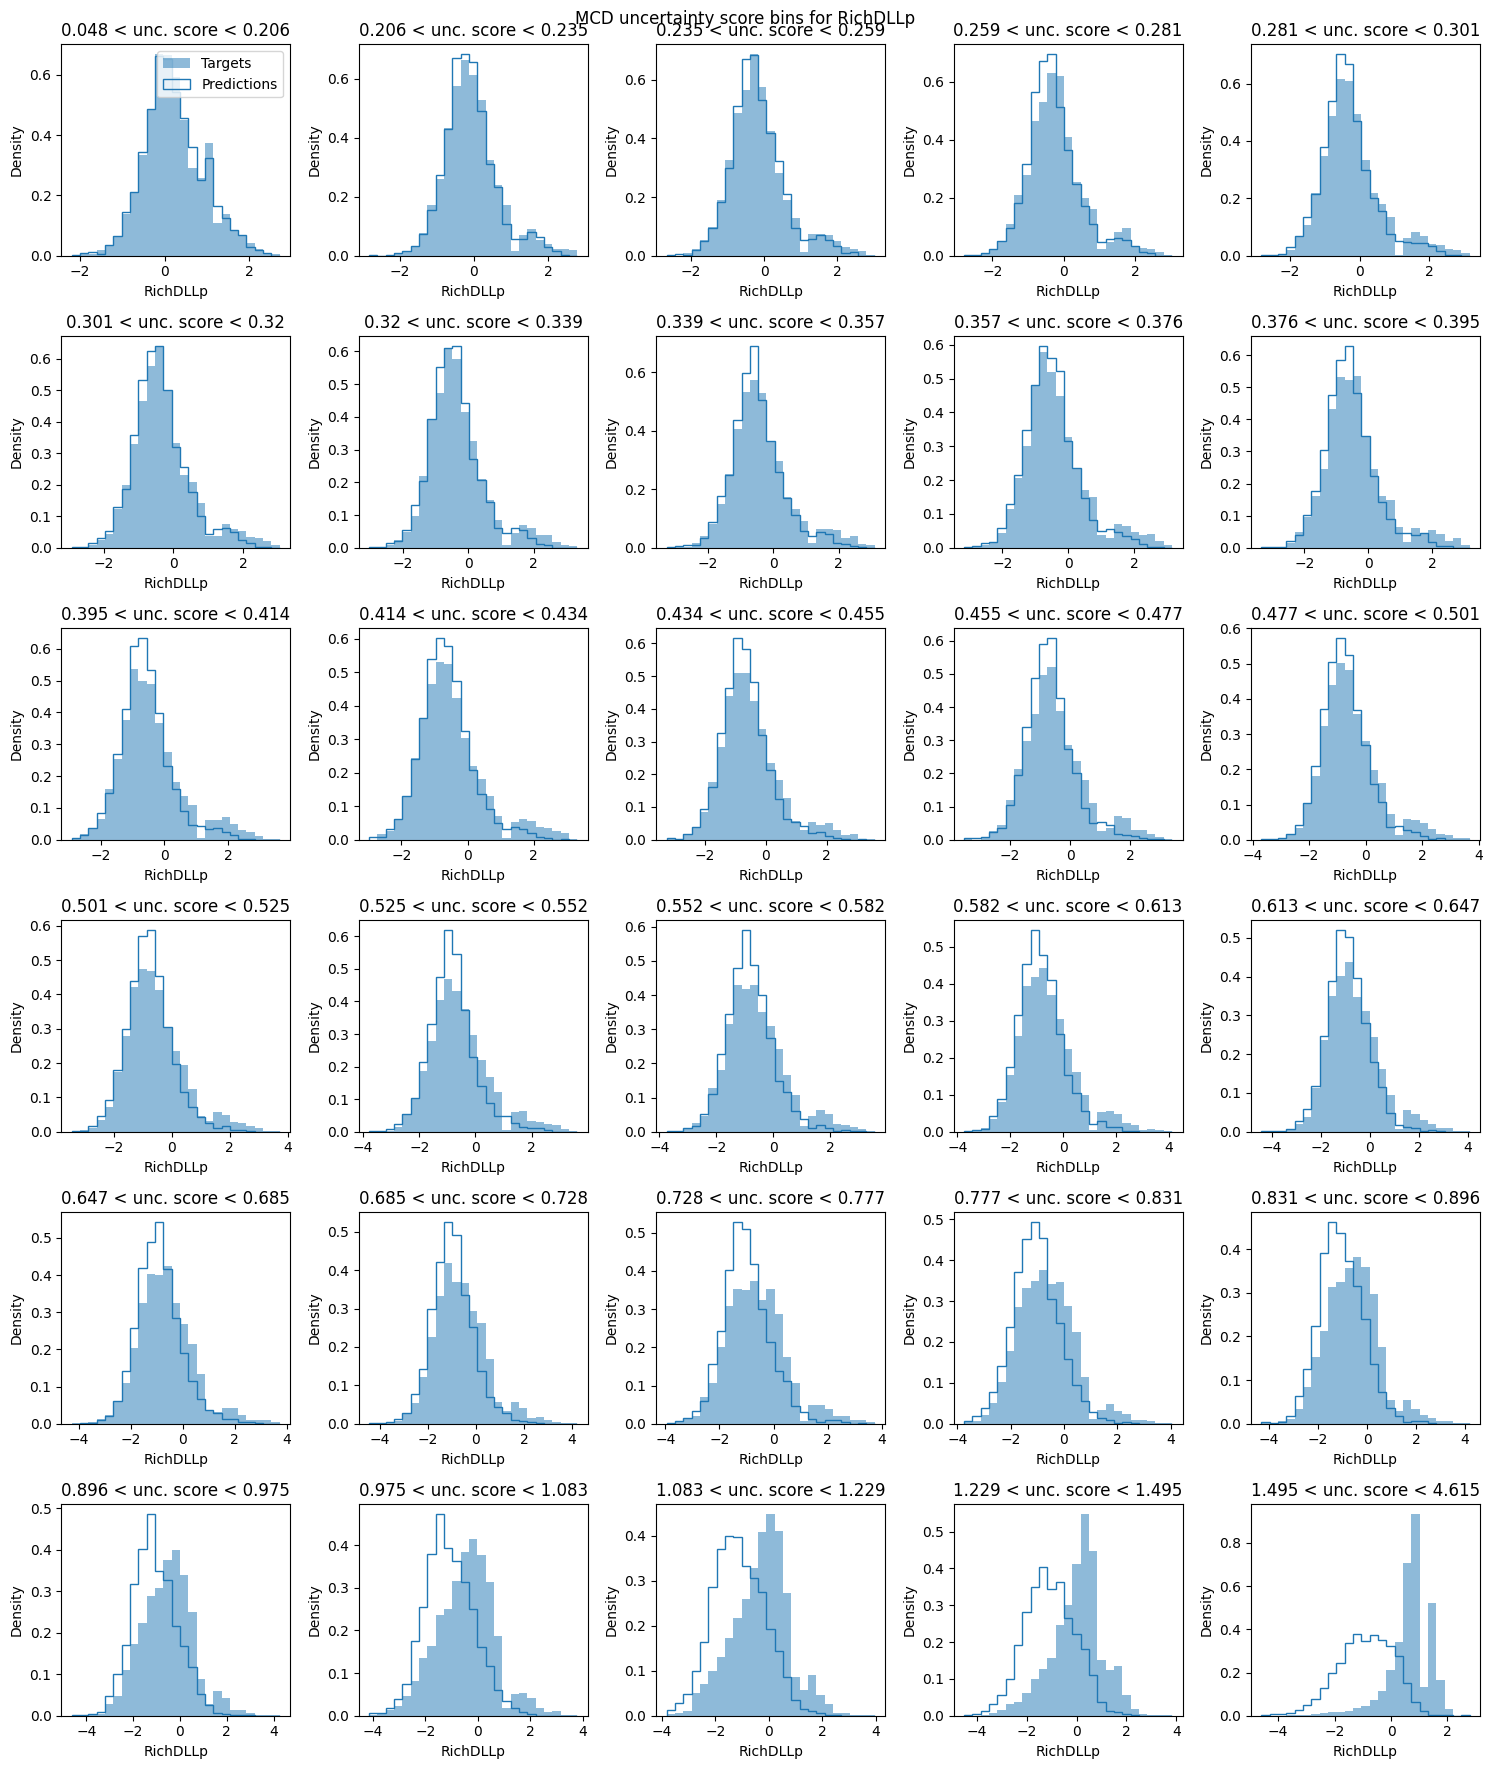

JS Distances:
0.05343828676179039, 0.07429460099128893, 0.07916435707572907, 0.08339548599305527, 0.10423180844540933, 0.08230512853393963, 0.09705608306077274, 0.0932210237623789, 0.10081481785921996, 0.10681805860632444, 0.127715849488722, 0.11130749244347031, 0.10745140224879471, 0.12528045899628262, 0.11538777306679068, 0.11479149533924007, 0.15100977615106037, 0.13171581285994455, 0.12798569536987955, 0.1272192294407962, 0.1272202621163802, 0.1504292845753672, 0.1695284829954323, 0.16488361796048978, 0.18156915198594756, 0.20662316694880478, 0.24361498877969526, 0.2840673132735672, 0.3664446620448013, 0.562543545569736
0.043 < unc. score < 0.213: Number of observations: 3334
0.213 < unc. score < 0.249: Number of observations: 3333
0.249 < unc. score < 0.279: Number of observations: 3333
0.279 < unc. score < 0.306: Number of observations: 3334
0.306 < unc. score < 0.332: Number of observations: 3333
0.332 < unc. score < 0.355: Number of observations: 3333
0.355 < unc. score < 0.379

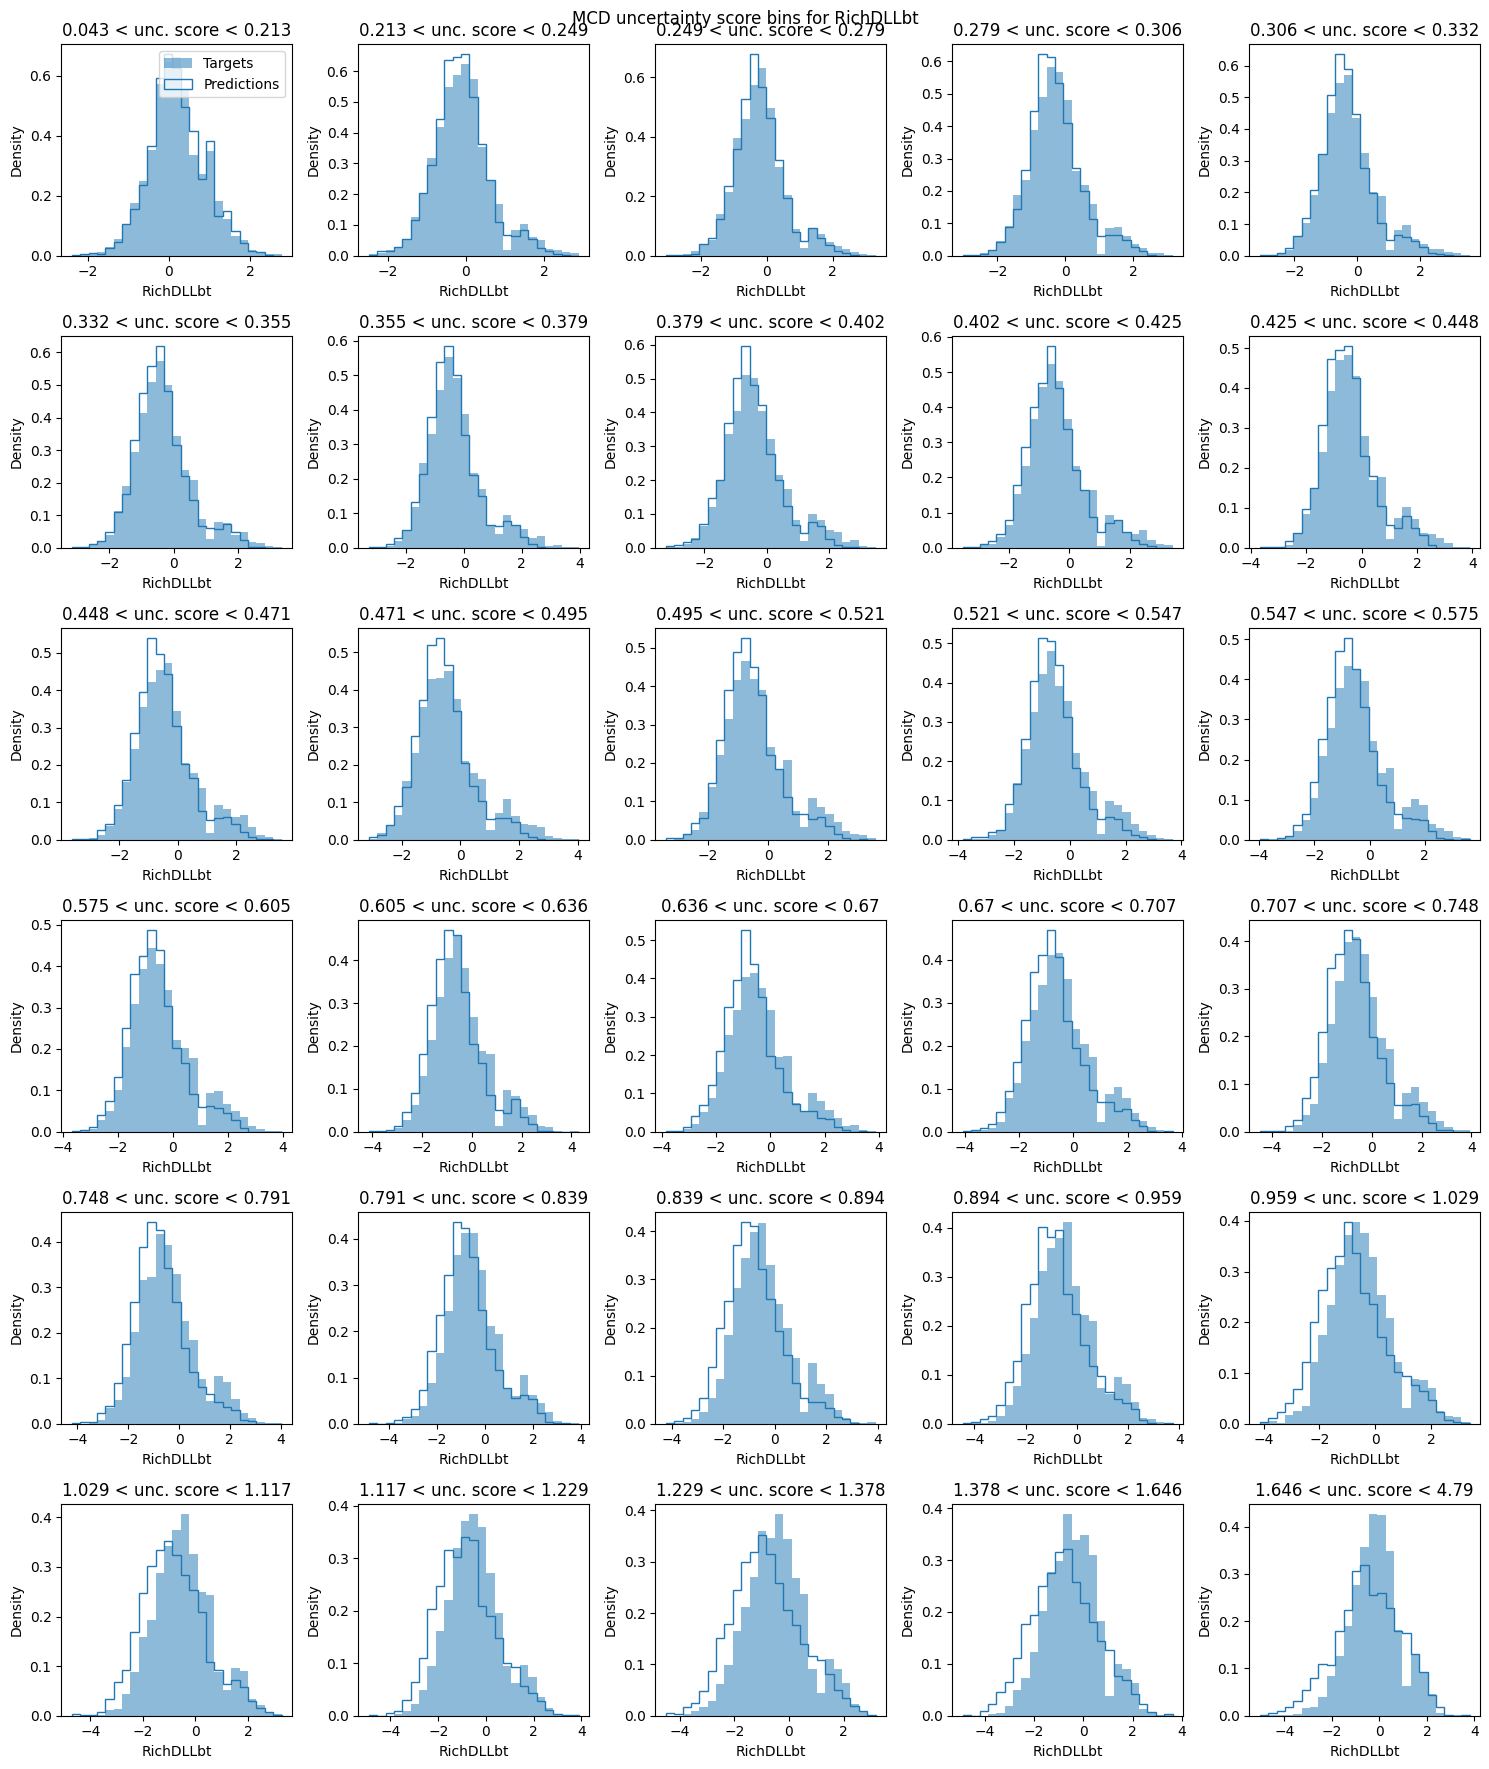

JS Distances:
0.05140651472099297, 0.0745812375973561, 0.07045966276463268, 0.09334019359091694, 0.08844815460917153, 0.07649933318343966, 0.08623894137621126, 0.09697623210330737, 0.10578359362595564, 0.10549685279496249, 0.10463021784301968, 0.1111952776393032, 0.11098002307406854, 0.11330989237127426, 0.11959862974048784, 0.11529895516596966, 0.12491021227625959, 0.12702520370754541, 0.11685329571365392, 0.1329373693003832, 0.12356935821933125, 0.11809922936183262, 0.1449535842198165, 0.13423001929284584, 0.1463365555305883, 0.14318965421380317, 0.14429965491730162, 0.161453100901384, 0.17001295432696562, 0.17674196226978037
Correlation coefficient for RichDLLe: 0.9836790805756518
Correlation coefficient for RichDLLK: 0.9783469236918808
Correlation coefficient for RichDLLmu: 0.9329834801993142
Correlation coefficient for RichDLLp: 0.9664337890868671
Correlation coefficient for RichDLLbt: 0.9167463986264613


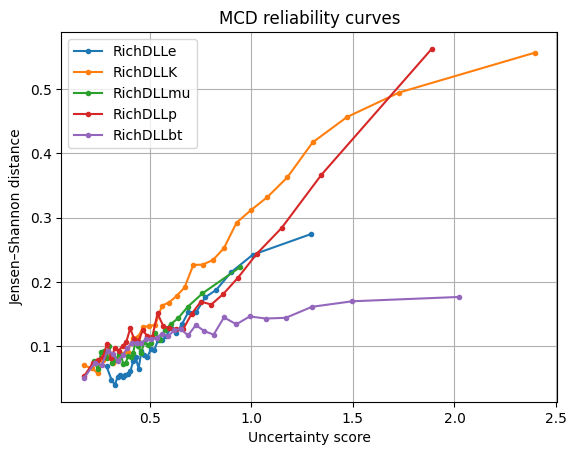

In [ ]:
all_mcd_mean_unc_scores, all_mcd_js_distances = [], []

for i in range(5):
  mcd_mean_unc_scores, mcd_js_distances = estimate_distances_and_plot_uncertainty_bins(
      y_sample, t_generated, mcd_uncertainty, uncertainty_type='MCD', bin_type='quantiles', particle_index=i, metric='JS', n_rows=6, n_cols=5)
  all_mcd_mean_unc_scores += [mcd_mean_unc_scores]
  all_mcd_js_distances += [mcd_js_distances]

plot_all_distances(all_mcd_mean_unc_scores, all_mcd_js_distances, 'MCD', metric='JS')

### MCD using KS

<ipython-input-21-f34132092fec>:35: MatplotlibDeprecationWarning: Passing the range parameter of hist() positionally is deprecated since Matplotlib 3.9; the parameter will become keyword-only in 3.11.
  targets_hist = ax.hist(targets[indices], 25, hist_range, True, alpha=.5, label='Targets')[0]
<ipython-input-21-f34132092fec>:36: MatplotlibDeprecationWarning: Passing the range parameter of hist() positionally is deprecated since Matplotlib 3.9; the parameter will become keyword-only in 3.11.
  predictions_hist = ax.hist(


0.251 < unc. score < 0.336: Number of observations: 10000
0.336 < unc. score < 0.375: Number of observations: 10000
0.375 < unc. score < 0.412: Number of observations: 10000
0.412 < unc. score < 0.453: Number of observations: 10000
0.453 < unc. score < 0.497: Number of observations: 10000
0.497 < unc. score < 0.55: Number of observations: 10000
0.55 < unc. score < 0.618: Number of observations: 10000
0.618 < unc. score < 0.709: Number of observations: 10000
0.709 < unc. score < 0.86: Number of observations: 10000
0.86 < unc. score < 2.982: Number of observations: 9999


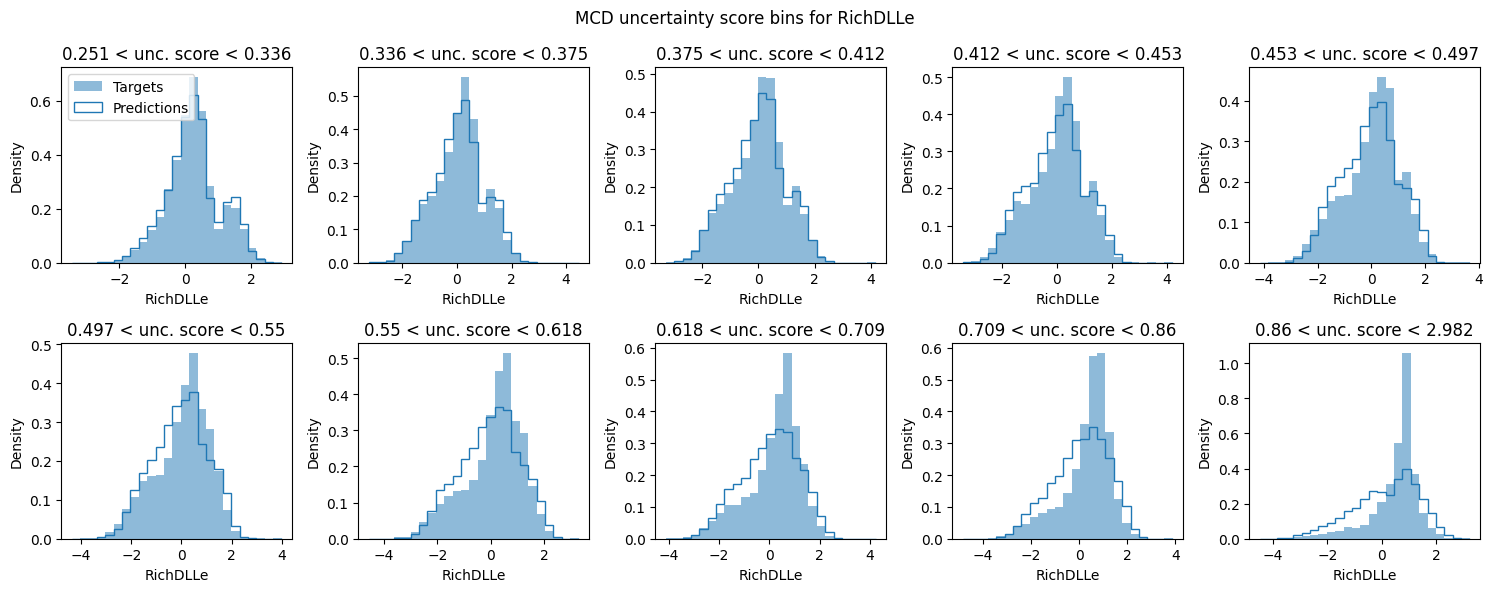

KS Distances:
0.0204, 0.0335, 0.0448, 0.0596, 0.0721, 0.0837, 0.1215, 0.1336, 0.1783, 0.24092409240924093
0.053 < unc. score < 0.258: Number of observations: 10000
0.258 < unc. score < 0.331: Number of observations: 10000
0.331 < unc. score < 0.404: Number of observations: 10000
0.404 < unc. score < 0.483: Number of observations: 10000
0.483 < unc. score < 0.577: Number of observations: 10000
0.577 < unc. score < 0.693: Number of observations: 10000
0.693 < unc. score < 0.837: Number of observations: 10000
0.837 < unc. score < 1.037: Number of observations: 10000
1.037 < unc. score < 1.377: Number of observations: 10000
1.377 < unc. score < 5.517: Number of observations: 9999


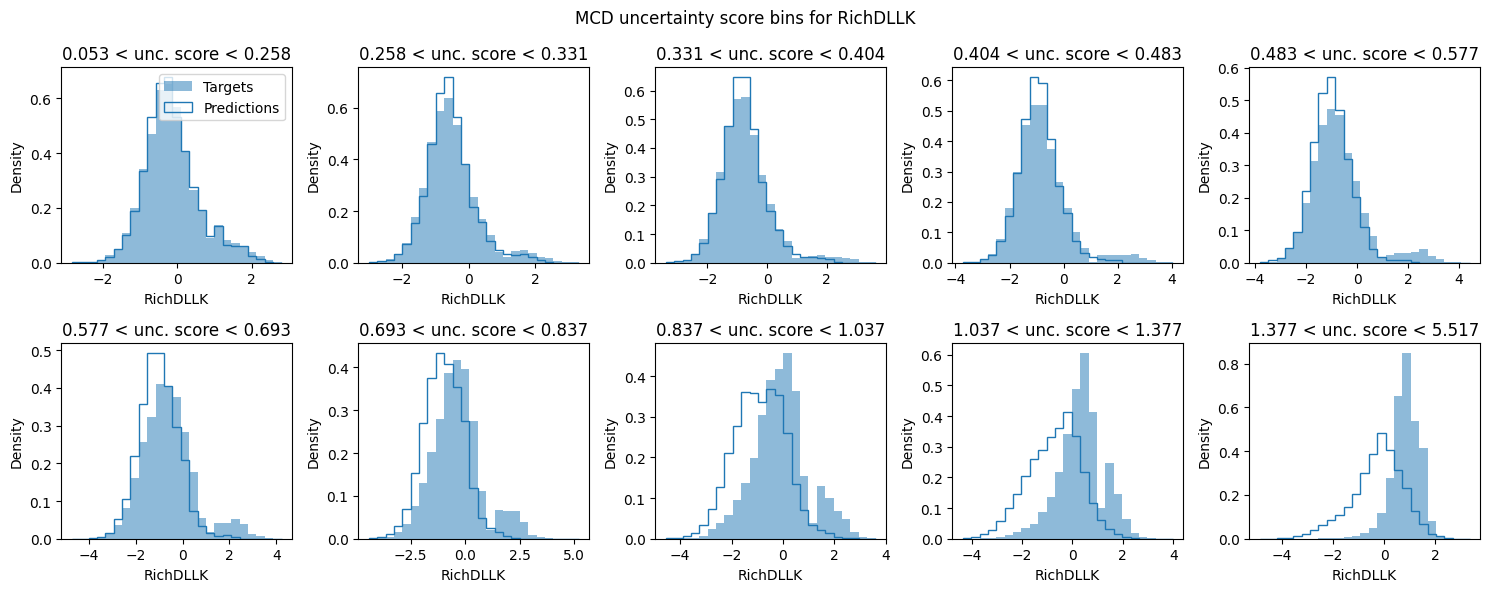

KS Distances:
0.0235, 0.0343, 0.0374, 0.0608, 0.1099, 0.1721, 0.2488, 0.3082, 0.4367, 0.5845584558455845
0.196 < unc. score < 0.269: Number of observations: 10000
0.269 < unc. score < 0.308: Number of observations: 10000
0.308 < unc. score < 0.342: Number of observations: 10000
0.342 < unc. score < 0.376: Number of observations: 10000
0.376 < unc. score < 0.412: Number of observations: 10000
0.412 < unc. score < 0.451: Number of observations: 10000
0.451 < unc. score < 0.499: Number of observations: 10000
0.499 < unc. score < 0.56: Number of observations: 10000
0.56 < unc. score < 0.661: Number of observations: 10000
0.661 < unc. score < 1.909: Number of observations: 9999


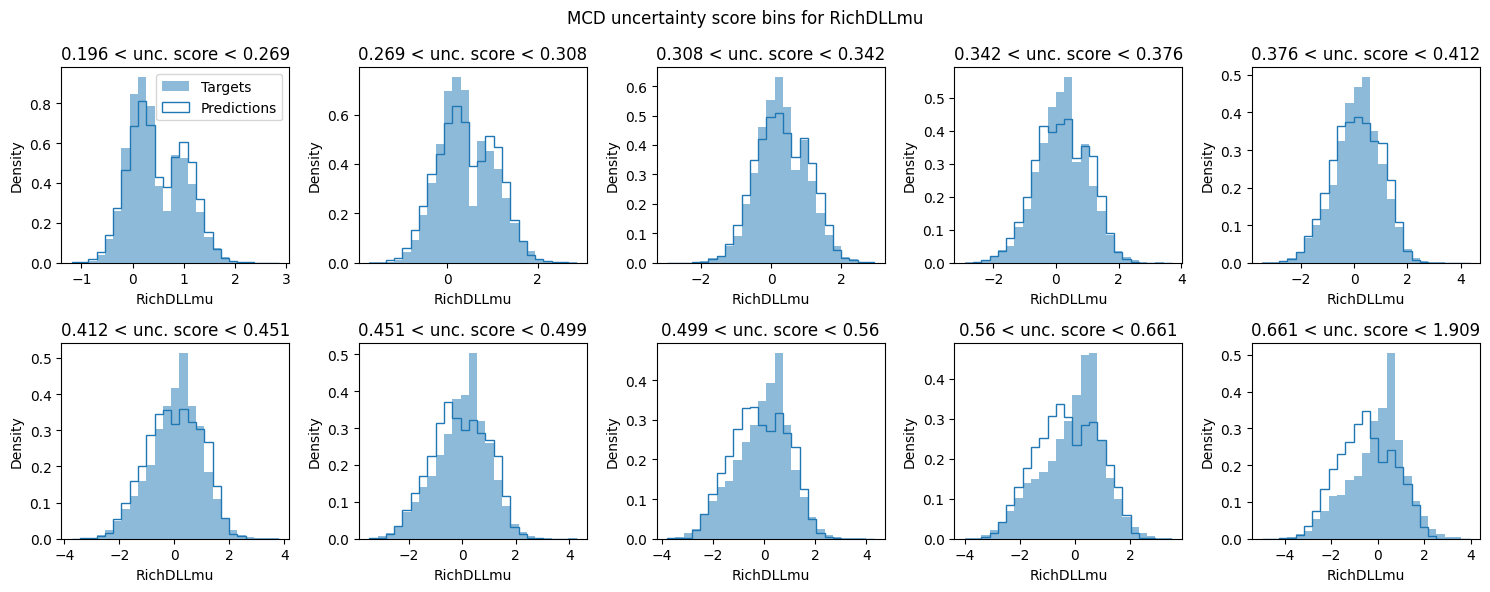

KS Distances:
0.0741, 0.0541, 0.0485, 0.0455, 0.0558, 0.0723, 0.0892, 0.1014, 0.1384, 0.22832283228322833
0.048 < unc. score < 0.259: Number of observations: 10000
0.259 < unc. score < 0.32: Number of observations: 10000
0.32 < unc. score < 0.376: Number of observations: 10000
0.376 < unc. score < 0.434: Number of observations: 10000
0.434 < unc. score < 0.501: Number of observations: 10000
0.501 < unc. score < 0.582: Number of observations: 10000
0.582 < unc. score < 0.685: Number of observations: 10000
0.685 < unc. score < 0.831: Number of observations: 10000
0.831 < unc. score < 1.083: Number of observations: 10000
1.083 < unc. score < 4.615: Number of observations: 9999


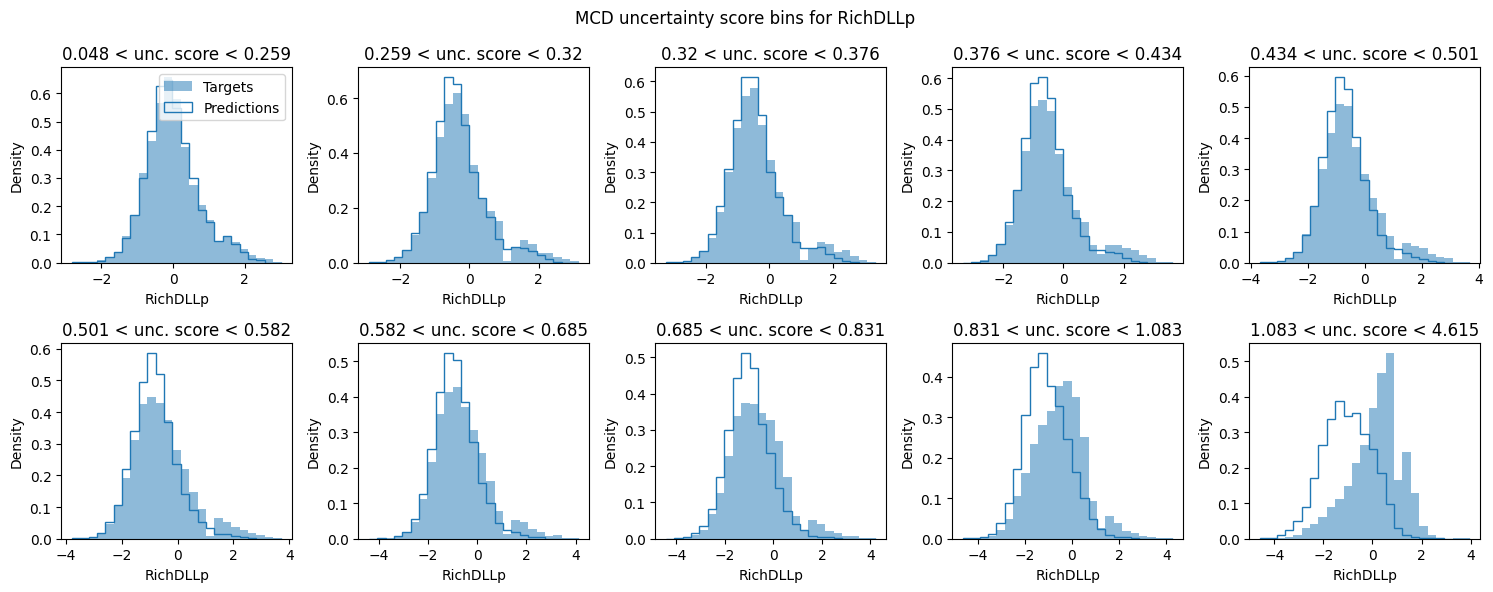

KS Distances:
0.0241, 0.0598, 0.0573, 0.0742, 0.0868, 0.1147, 0.1161, 0.1709, 0.2504, 0.46844684468446846
0.043 < unc. score < 0.279: Number of observations: 10000
0.279 < unc. score < 0.355: Number of observations: 10000
0.355 < unc. score < 0.425: Number of observations: 10000
0.425 < unc. score < 0.495: Number of observations: 10000
0.495 < unc. score < 0.575: Number of observations: 10000
0.575 < unc. score < 0.67: Number of observations: 10000
0.67 < unc. score < 0.791: Number of observations: 10000
0.791 < unc. score < 0.959: Number of observations: 10000
0.959 < unc. score < 1.229: Number of observations: 10000
1.229 < unc. score < 4.79: Number of observations: 9999


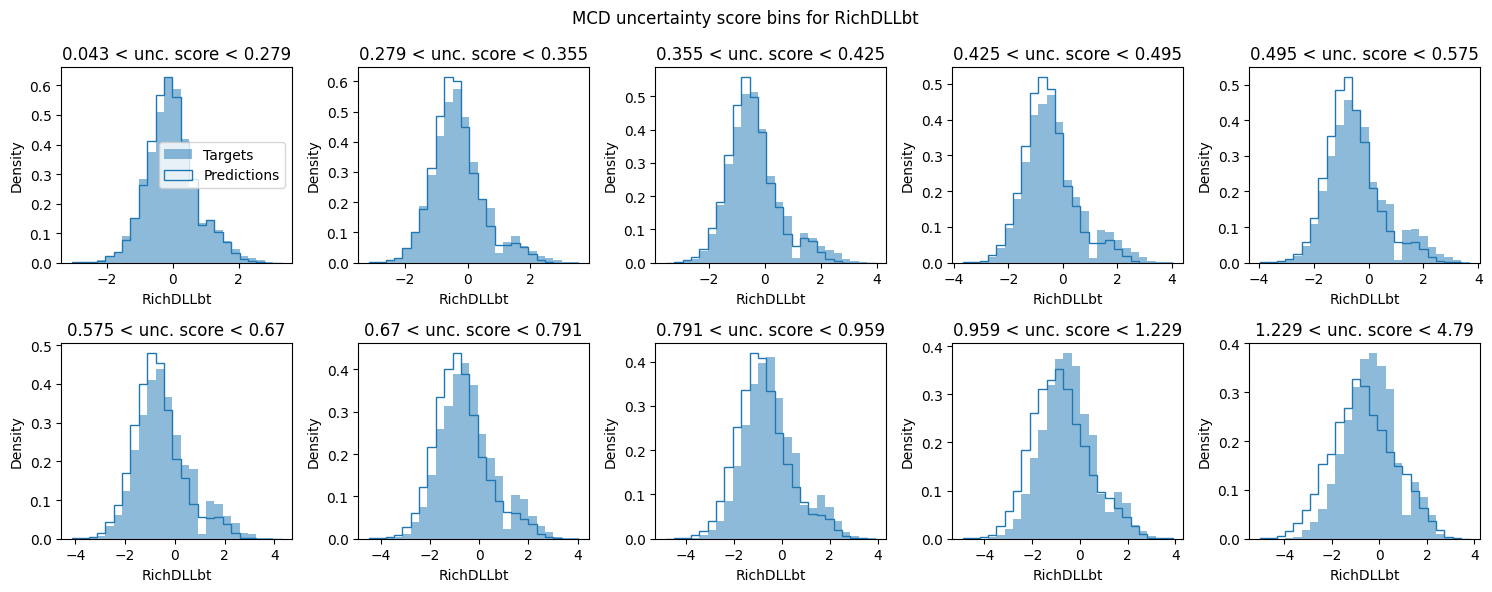

KS Distances:
0.0232, 0.0565, 0.0601, 0.0789, 0.0952, 0.1147, 0.1302, 0.1447, 0.1449, 0.14521452145214522
Correlation coefficient for RichDLLe: 0.9928180408346711
Correlation coefficient for RichDLLK: 0.984047732300206
Correlation coefficient for RichDLLmu: 0.9205889936637557
Correlation coefficient for RichDLLp: 0.9877580833063699
Correlation coefficient for RichDLLbt: 0.8396364149025835


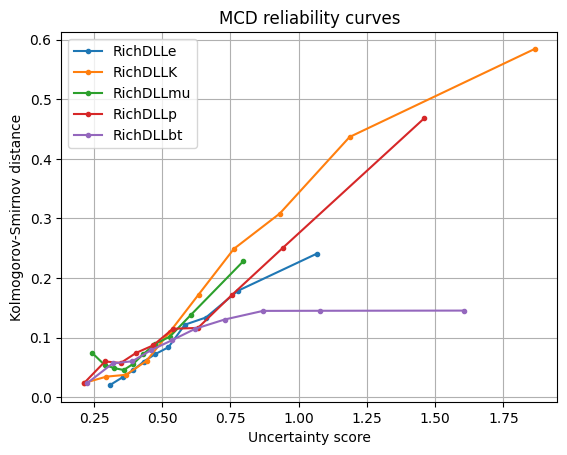

In [ ]:
all_mcd_mean_unc_scores, all_mcd_js_distances = [], []

for i in range(5):
  mcd_mean_unc_scores, mcd_js_distances = estimate_distances_and_plot_uncertainty_bins(
      y_sample, t_generated, mcd_uncertainty, uncertainty_type='MCD', bin_type='quantiles', particle_index=i, metric='KS')
  all_mcd_mean_unc_scores += [mcd_mean_unc_scores]
  all_mcd_js_distances += [mcd_js_distances]

plot_all_distances(all_mcd_mean_unc_scores, all_mcd_js_distances, 'MCD', metric='KS')

## Uncertainty heatmaps

### FD heatmaps

In [ ]:
def uncertainty_scatter_plot_fd(x_real, uncertainties):
  momentum = x_real[:, 0]
  eta = x_real[:, 1]

  plt.title('Feature densities heatmap')
  plt.scatter(momentum, eta, .1, uncertainties, cmap='inferno')
  plt.colorbar(label='Uncertainty score')
  plt.xlabel('Momentum')
  plt.ylabel('Eta')
  plt.show()

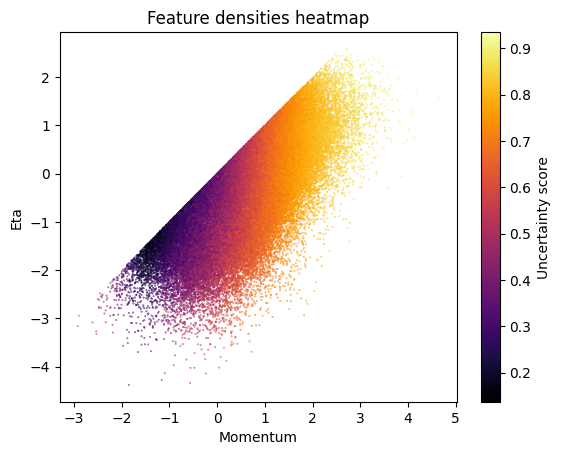

In [ ]:
uncertainty_scatter_plot_fd(x_sample, fd_uncertainty_normalized)

In [ ]:
def uncertainty_hist2d_fd(x_real, uncertainties, n_bins=100):
  uncertainties = np.array(uncertainties)

  momentum = x_real[:, 0]
  eta = x_real[:, 1]

  momentum_edges, eta_edges = np.histogram2d(momentum, eta, n_bins)[1:]
  momentum_indices = np.digitize(momentum, momentum_edges)
  eta_indices = np.digitize(eta, eta_edges)

  heatmap = []

  for i in range(1, n_bins + 1):
    row = []
    for j in range(1, n_bins + 1):
      row += [uncertainties[(momentum_indices == j) & (eta_indices == i)].mean()]
    heatmap += [row]

  plt.title('Feature densities heatmap')
  plt.imshow(heatmap, 'inferno')
  plt.gca().invert_yaxis()
  plt.colorbar(label='Uncertainty score')
  plt.xlabel('Momentum')
  plt.ylabel('Eta')
  plt.show()

<ipython-input-54-97c69ed682c3>:16: RuntimeWarning: Mean of empty slice.
  row += [uncertainties[(momentum_indices == j) & (eta_indices == i)].mean()]
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


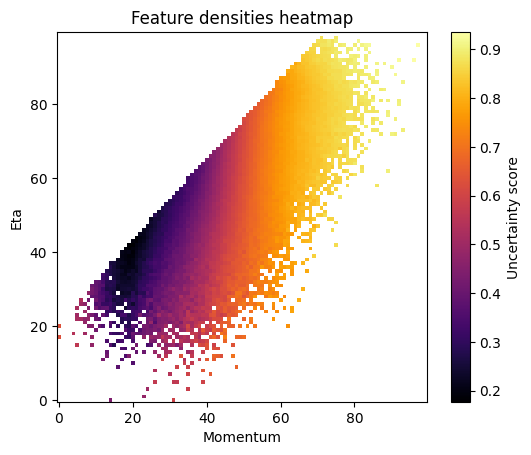

In [ ]:
uncertainty_hist2d_fd(x_sample, fd_uncertainty_normalized)

In [ ]:
from scipy.stats import binned_statistic_2d
import matplotlib as mpl

mpl.rcParams['font.family'] = 'serif'

def uncertainty_binned2d_fd(x_real, uncertainties, n_bins=5, bin_size=50):
    momentum = x_real[:, 0]
    eta = x_real[:, 1]
    num_tracks = x_real[:, 2]

    bin_edges = np.quantile(num_tracks, np.linspace(0, 1, n_bins + 1))
    bin_indices = np.digitize(num_tracks, bin_edges, right=True) - 1

    fig, axes = plt.subplots(1, n_bins, figsize=(19.2, 3.6))
    plt.subplots_adjust(hspace=0.3, wspace=0.3)

    for i in range(n_bins):
        mask = bin_indices == i

        x_data = momentum[mask]
        y_data = eta[mask]
        u_data = uncertainties[mask]

        x_bins = np.logspace(np.log10(x_data.min()), np.log10(x_data.max()), bin_size)
        y_bins = np.linspace(y_data.min(), y_data.max(), bin_size)

        bin_means, x_edges, y_edges, _ = binned_statistic_2d(
            x_data, y_data, u_data, statistic='mean', bins=[x_bins, y_bins]
        )

        ax = axes[i]
        ax.set_title(f'Tracks [{bin_edges[i]:.2f}, {bin_edges[i + 1]:.2f}]')
        mesh = ax.pcolormesh(x_edges, y_edges, bin_means.T, cmap='inferno')
        ax.set_xscale('log')
        ax.set_xlabel('Momentum')
        ax.set_ylabel('Eta')

        ticks = np.linspace(np.nanmin(bin_means), np.nanmax(bin_means), 5)
        plt.colorbar(mesh, ticks=ticks, label='Uncertainty score')

    plt.suptitle('Features Densities Heatmap for Different Track Ranges')
    plt.tight_layout()
    plt.savefig("Features_densities_heatmap_for_different_track_ranges.svg", format="svg")
    plt.show()


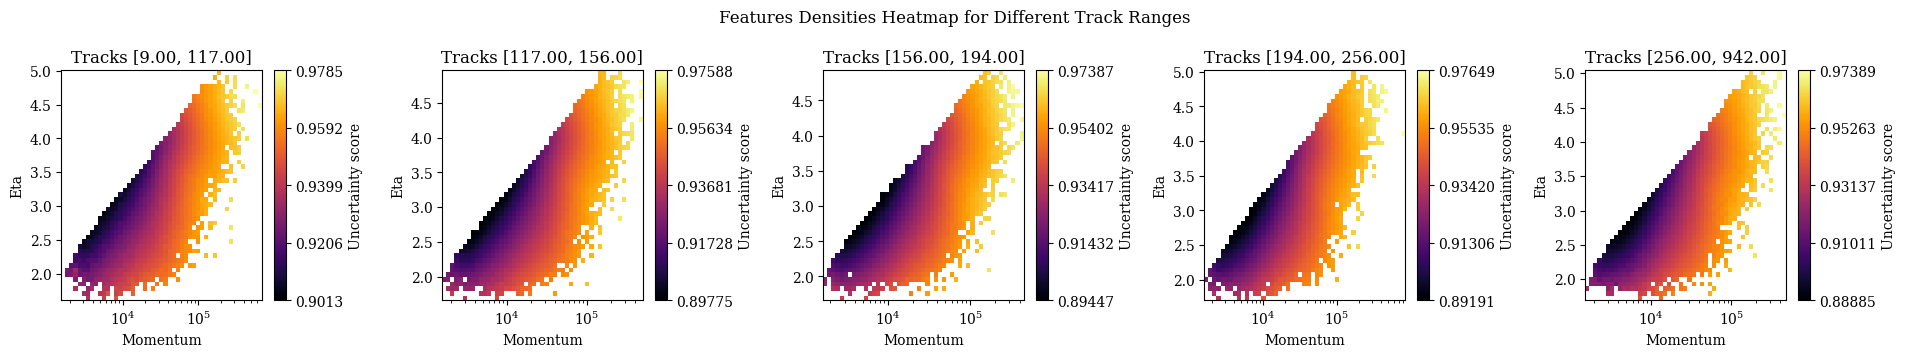

In [ ]:
uncertainty_binned2d_fd(x_sample_orig, fd_uncertainty)

### MCD heatmaps

In [ ]:
def uncertainty_scatter_plot_mcd(x_real, uncertainties):
  momentum = x_real[:, 0]
  eta = x_real[:, 1]

  fig, axes = plt.subplots(2, 3, figsize=(11, 6))

  for i, ax in enumerate(axes.flatten()[:-1]):
    ax.set_title(DLL_COLUMNS[i])
    scatter = ax.scatter(momentum, eta, .1, uncertainties[:, i], cmap='inferno')
    plt.colorbar(scatter, label='Uncertainty score')
    ax.set_xlabel('Momentum')
    ax.set_ylabel('Eta')

  plt.suptitle('MCD heatmaps')
  axes[-1, -1].axis(False)
  plt.tight_layout()
  plt.show()

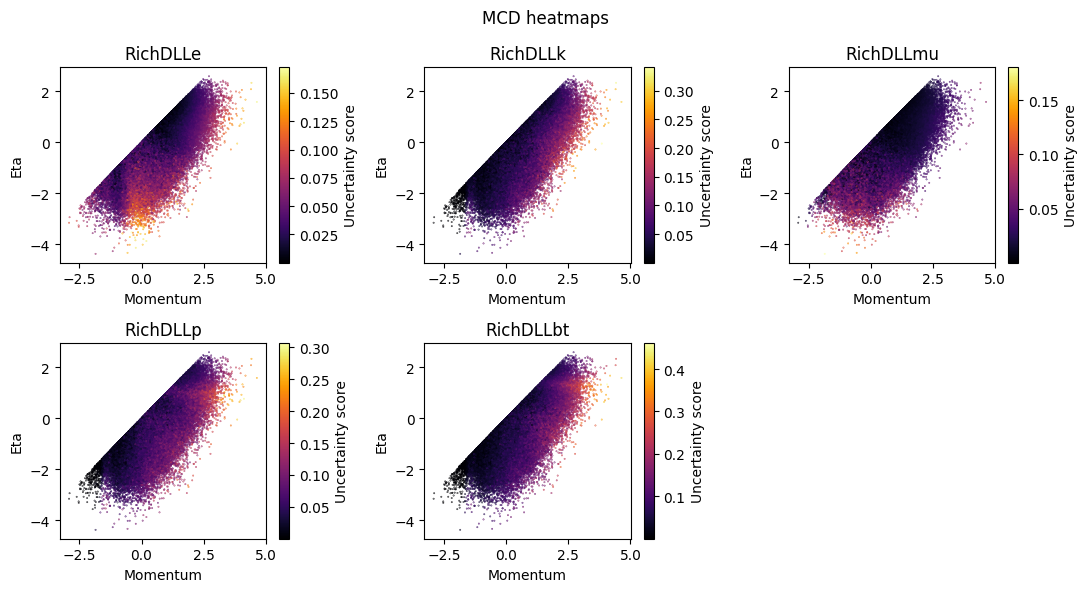

In [ ]:
uncertainty_scatter_plot_mcd(x_sample, mcd_final_uncertainty)

In [ ]:
def uncertainty_hist2d_mcd(x_real, uncertainties, n_bins=100):
  uncertainties = np.array(uncertainties)

  momentum = x_real[:, 0]
  eta = x_real[:, 1]

  fig, axes = plt.subplots(2, 3, figsize=(11, 6))

  for ax_index, ax in enumerate(axes.flatten()[:-1]):
    momentum_edges, eta_edges = np.histogram2d(momentum, eta, n_bins)[1:]
    momentum_indices = np.digitize(momentum, momentum_edges)
    eta_indices = np.digitize(eta, eta_edges)

    heatmap = []

    for i in range(1, n_bins + 1):
      row = []
      for j in range(1, n_bins + 1):
        row += [uncertainties[(momentum_indices == j) & (eta_indices == i), ax_index].mean()]
      heatmap += [row]

    ax.set_title(DLL_COLUMNS[ax_index])
    image = ax.imshow(heatmap, 'inferno')
    ax.invert_yaxis()
    plt.colorbar(image, label='Uncertainty score')
    ax.set_xlabel('Momentum')
    ax.set_ylabel('Eta')

  plt.suptitle('MCD heatmaps')
  axes[-1, -1].axis(False)
  plt.tight_layout()
  plt.show()

<ipython-input-59-e99db391306d>:19: RuntimeWarning: Mean of empty slice.
  row += [uncertainties[(momentum_indices == j) & (eta_indices == i), ax_index].mean()]
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)


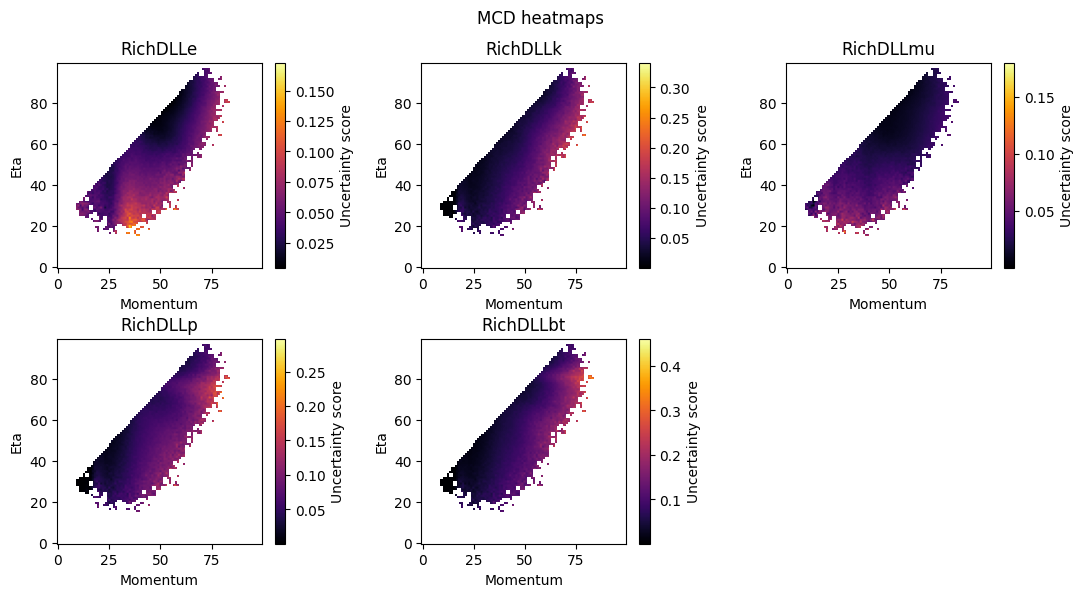

In [ ]:
uncertainty_hist2d_mcd(x_sample, mcd_final_uncertainty)

In [ ]:
from scipy.stats import binned_statistic_2d
import matplotlib as mpl

mpl.rcParams['font.family'] = 'serif'

def uncertainty_binned2d_mcd(
    x_real, uncertainties, particle_idx, top_q=None, norm=None, cmap=None,
    n_bins=5, bin_size=50,
    ):
    momentum = x_real[:, 0]
    eta = x_real[:, 1]
    num_tracks = x_real[:, 2]

    bin_edges = np.quantile(num_tracks, np.linspace(0, 1, n_bins + 1))
    bin_indices = np.digitize(num_tracks, bin_edges, right=True) - 1

    fig, axes = plt.subplots(1, 5, figsize=(19.2, 3.6))

    for i in range(n_bins):
        bin_mask = bin_indices == i
        x_data = momentum[bin_mask]
        y_data = eta[bin_mask]
        u_data = uncertainties[bin_mask, particle_idx]

        x_bins = np.logspace(np.log10(x_data.min()), np.log10(x_data.max()), bin_size)
        y_bins = np.linspace(y_data.min(), y_data.max(), bin_size)

        bin_means, x_edges, y_edges, _ = binned_statistic_2d(
            x_data, y_data, u_data, statistic='mean', bins=[x_bins, y_bins]
        )

        vmax = np.quantile(bin_means[bin_means == bin_means], top_q) if top_q else None

        ax = axes[i]
        ax.set_title(f'Tracks [{bin_edges[i]:.2f}, {bin_edges[i + 1]:.2f}]')
        mesh = ax.pcolormesh(x_edges, y_edges, bin_means.T, vmax=vmax, norm=norm, cmap=cmap)
        ax.set_xscale('log')
        ax.set_xlabel('Momentum(MeV/c)')
        ax.set_ylabel('Eta')

        if norm:
          ticks = None
        else:
          ticks = np.linspace(np.nanmin(bin_means), vmax or np.nanmax(bin_means), 5)

        extend = 'max' if vmax else None

        plt.colorbar(mesh, label='Uncertainty score', ticks=ticks, extend=extend)

    plt.suptitle(f'MCD Heatmap for Different Track Ranges for particle {DLL_COLUMNS[particle_idx]}')
    plt.tight_layout()
    plt.savefig(f'MCD_Heatmap_for_Different_Track_Ranges_for_particle_{DLL_COLUMNS[particle_idx]}.svg', format="svg")
    plt.show()

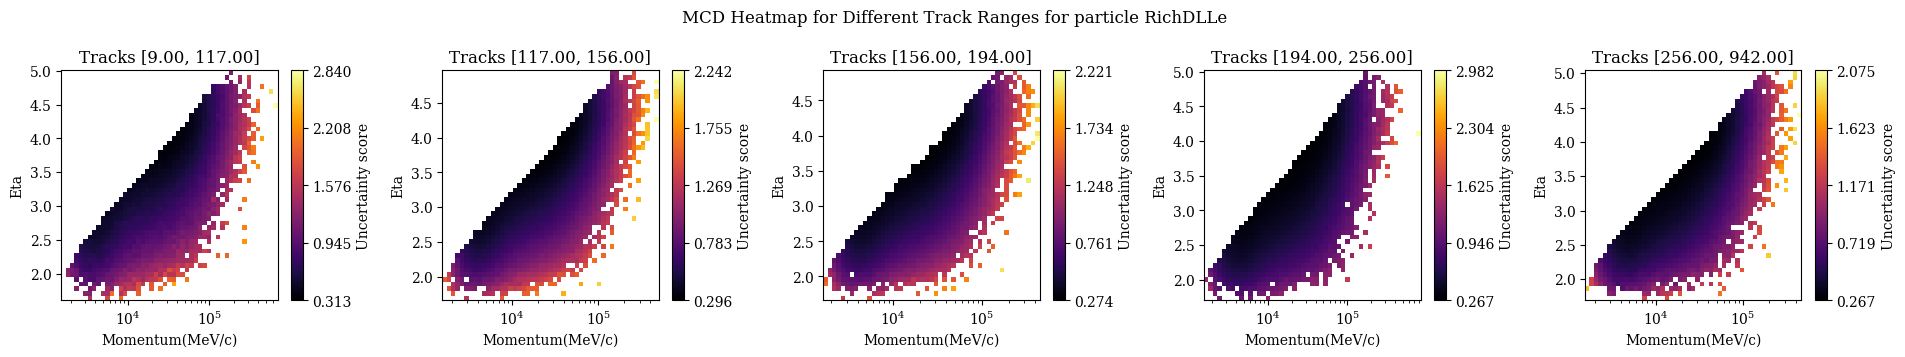

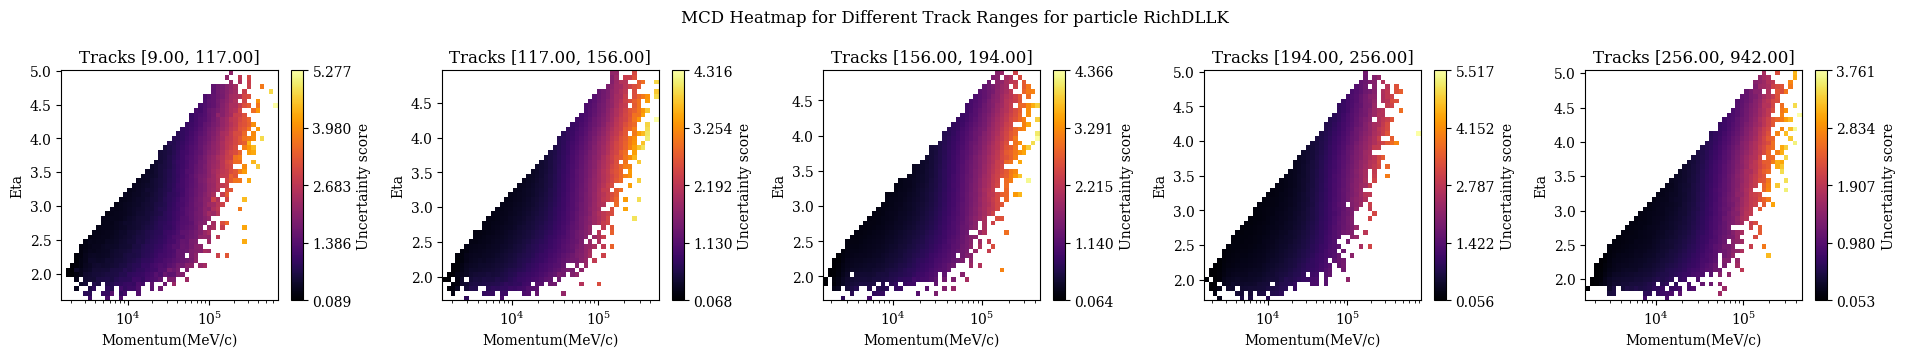

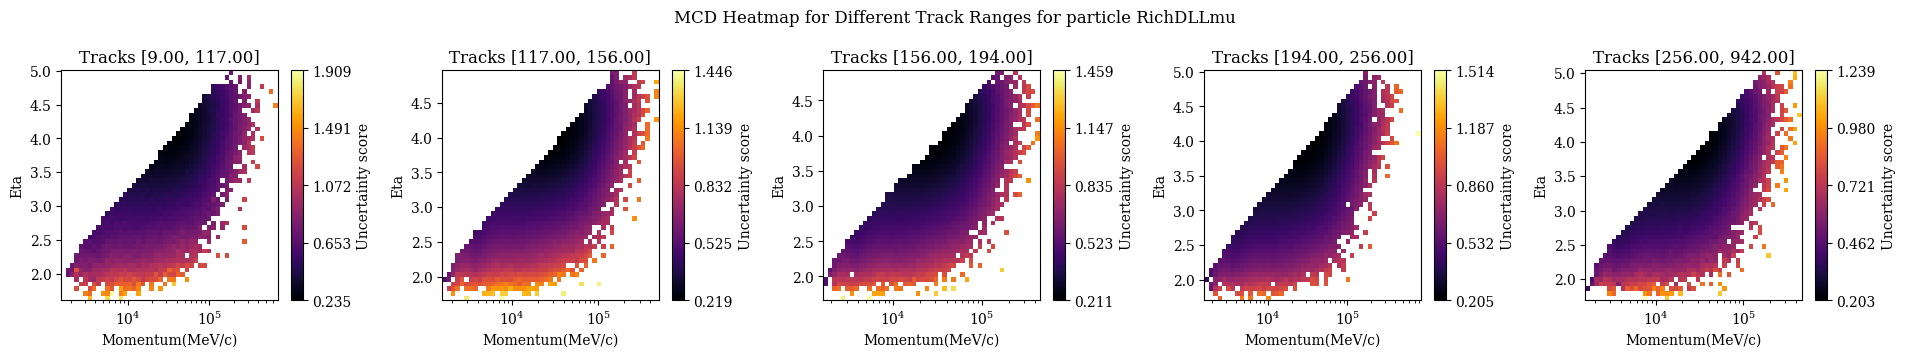

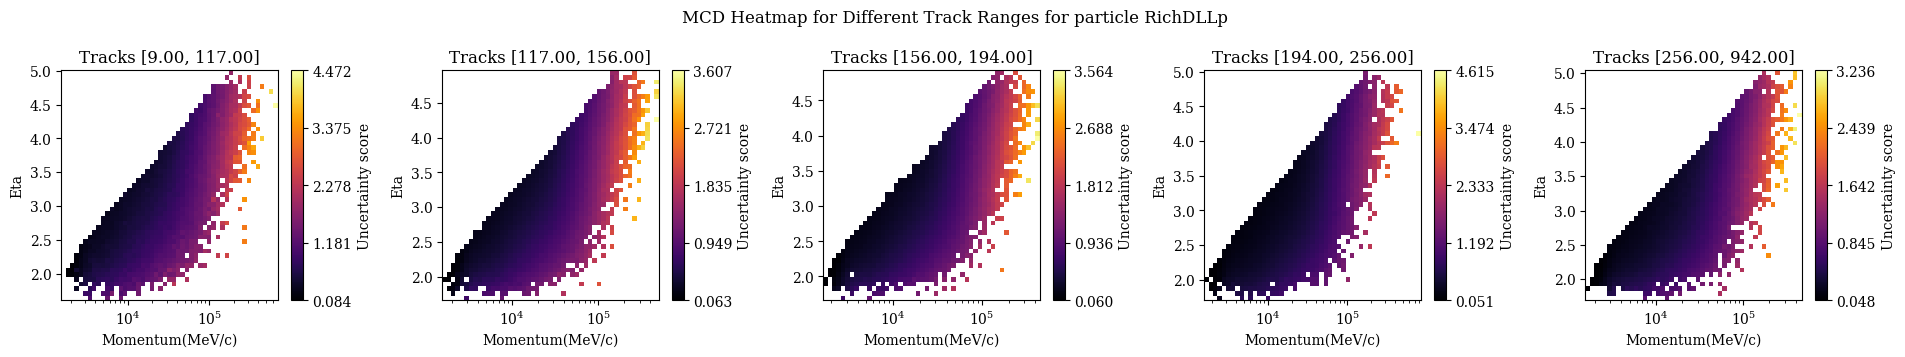

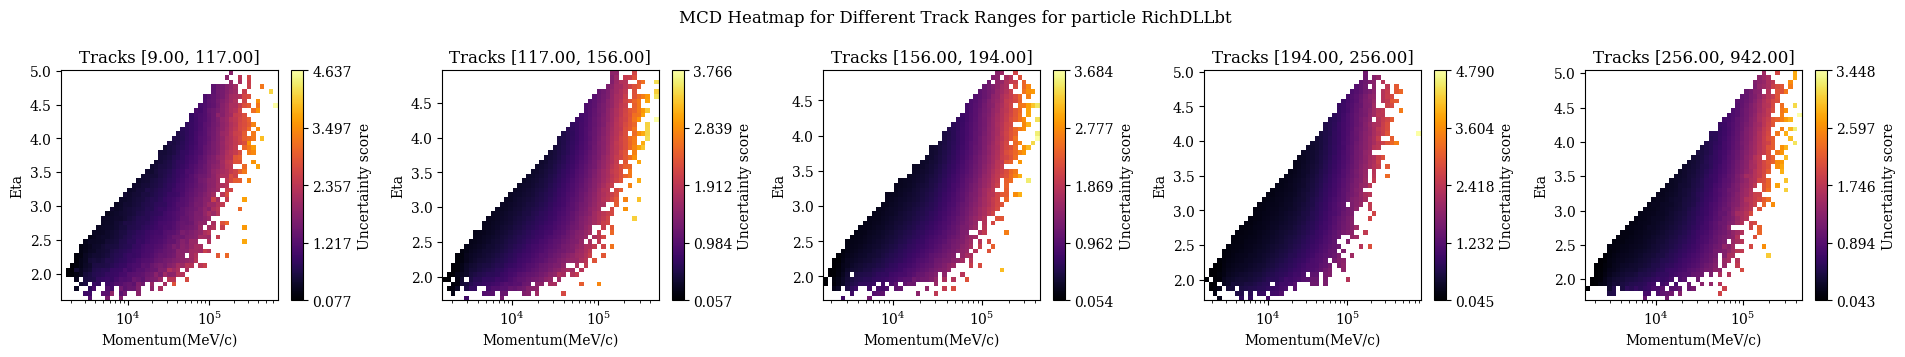

In [ ]:
for i in range(5):
  uncertainty_scores = mcd_uncertainty[:, i]
  top_q = None # 0.9
  norm = None # 'log'
  cmap = 'inferno' # 'tab10'
  uncertainty_binned2d_mcd(x_sample_orig, mcd_uncertainty, i, top_q, norm, cmap)

# Efficiency plots

In [ ]:
def select_threshold(feature, quantile=0.1):
    return np.quantile(feature, quantile)

def efficiency_bins(targets, threshold, particle_index):
    def compute_efficiency(y):
        return (y > threshold).mean()

    def compute_error(y):
        err = (y < threshold).sum() * (y > threshold).sum() / y.size**3
        return np.sqrt(err)

    efficiencies = []
    errors = []

    for target in targets:
        eff = compute_efficiency(target[:, particle_index])
        err = compute_error(target[:, particle_index])

        efficiencies.append(eff)
        errors.append(err)

    return efficiencies, errors

def compute_bin_indices(data, n_bins):
  bin_edges = np.linspace(data.min(), data.max(), n_bins + 1)
  indices = np.digitize(data, bin_edges)
  return indices

def plot_efficiencies(y_sample, t_generated, uncertainties, quantiles, n_bins=10, dll_columns=DLL_COLUMNS):
  y_sample = np.array(y_sample)
  t_generated = np.array(t_generated)
  uncertainties = np.array(uncertainties)

  fig, axes = plt.subplots(2, 3, figsize=(9, 6))

  indices = compute_bin_indices(uncertainties, n_bins)

  bins_targets = [t_generated[indices == i] for i in range(1, n_bins + 1)]
  bins_likelihoods = [uncertainties[indices == i].mean() for i in range(1, n_bins + 1)]

  for idx, ax in zip(range(5), axes.flatten()):
      for quantile in quantiles:
          threshold = select_threshold(y_sample[:, idx], quantile)
          eff, err = efficiency_bins(bins_targets, threshold, idx)

          plot = ax.plot(bins_likelihoods, eff, '.-', label=f'Quantile = {int(quantile * 100)}%')
          ax.errorbar(bins_likelihoods, eff, err, color=plot[0].get_color())

      ax.set_title(dll_columns[idx])
      ax.set_axisbelow(True)
      ax.grid()
      ax.set_xlabel("Bin likelihood")
      ax.set_ylabel("Efficiency")

  axes[-1, -1].axis(False)
  handles, labels = ax.get_legend_handles_labels()
  plt.legend(handles, labels, loc='upper left')

  plt.tight_layout()
  plt.show()

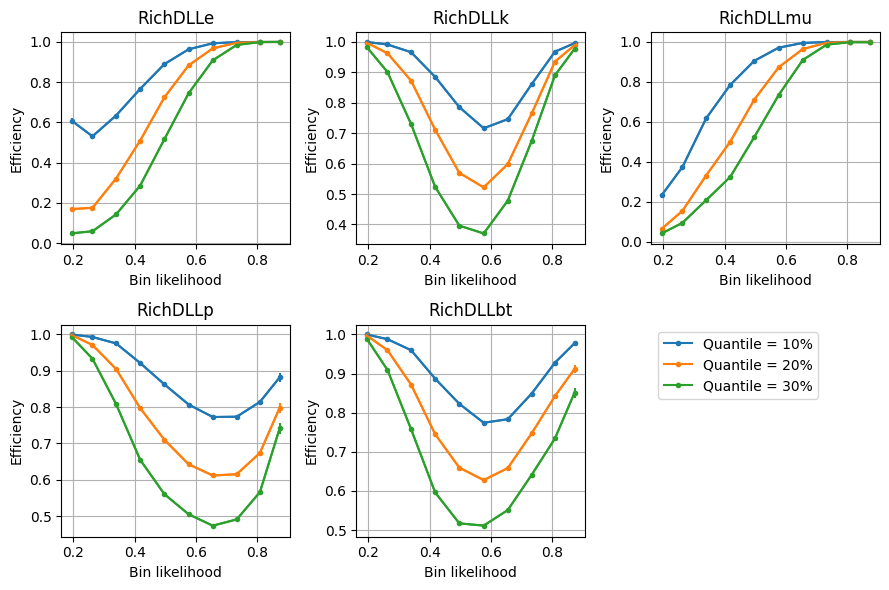

In [ ]:
plot_efficiencies(y_sample, t_generated, fd_uncertainty_normalized, [.1, .2, .3])

##Plot Efficiencies by particle

In [ ]:
def plot_efficiencies_by_particle(y_sample, t_generated, uncertainties, quantiles, uncertainty_type="MCD", particle_idx=0, n_bins=10, dll_columns=DLL_COLUMNS):
    y_sample = np.array(y_sample)
    t_generated = np.array(t_generated)
    uncertainties = np.array(uncertainties)

    fig, axes = plt.subplots(2, 3, figsize=(9, 6))

    colors = plt.colormaps['tab10']

    if uncertainty_type == "MCD":
        uncertainties_column = uncertainties[:, particle_idx]
    else:
        uncertainties_column = uncertainties


    bin_edges = np.quantile(uncertainties_column, np.linspace(0, 1, n_bins + 1))
    indices = np.digitize(uncertainties_column, bin_edges, right=True)

    bins_targets = [t_generated[indices == i] for i in range(1, n_bins + 1)]
    bins_real = [y_sample[indices == i] for i in range(1, n_bins + 1)]
    bins_likelihoods = [uncertainties_column[indices == i].mean() for i in range(1, n_bins + 1)]

    for idx, ax in zip(range(len(quantiles)), axes.flatten()):
        quantile = quantiles[idx]
        threshold = select_threshold(y_sample[:, particle_idx], quantile)

        eff_gen, err_gen = efficiency_bins(bins_targets, threshold, particle_idx)
        eff_real, err_real = efficiency_bins(bins_real, threshold, particle_idx)



        ax.plot(bins_likelihoods, eff_gen, '.-', color=colors(0), label='Generated')

        ax.fill_between(bins_likelihoods, np.array(eff_gen) - np.array(err_gen),
                        np.array(eff_gen) + np.array(err_gen), color=colors(0), alpha=0.3)

        ax.plot(bins_likelihoods, eff_real, '.-', color=colors(20), label='Real')

        ax.fill_between(bins_likelihoods, np.array(eff_real) - np.array(err_real),
                        np.array(eff_real) + np.array(err_real), color=colors(20), alpha=0.3)

        ax.set_title(f'Threshold {int(quantile * 100)}%')
        ax.set_axisbelow(True)
        ax.grid()
        ax.set_xlabel("Uncertainty Score")
        ax.set_ylabel("Efficiency")
        ax.set_ylim(0, 1.10)

    axes[-1, -1].axis(False)

    handles, labels = ax.get_legend_handles_labels()
    fig.legend(handles, labels, loc='upper left', bbox_to_anchor=(0.73, 0.45), fontsize='small')

    plt.suptitle(f'{uncertainty_type} efficiencies plot for {dll_columns[particle_idx]}')

    plt.tight_layout()
    plt.show()

### Plot FD efficiencies

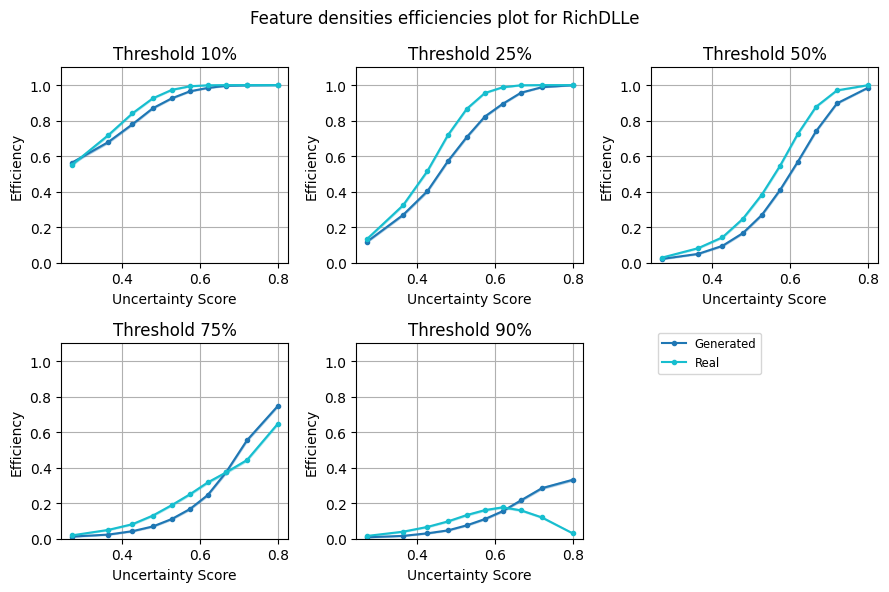

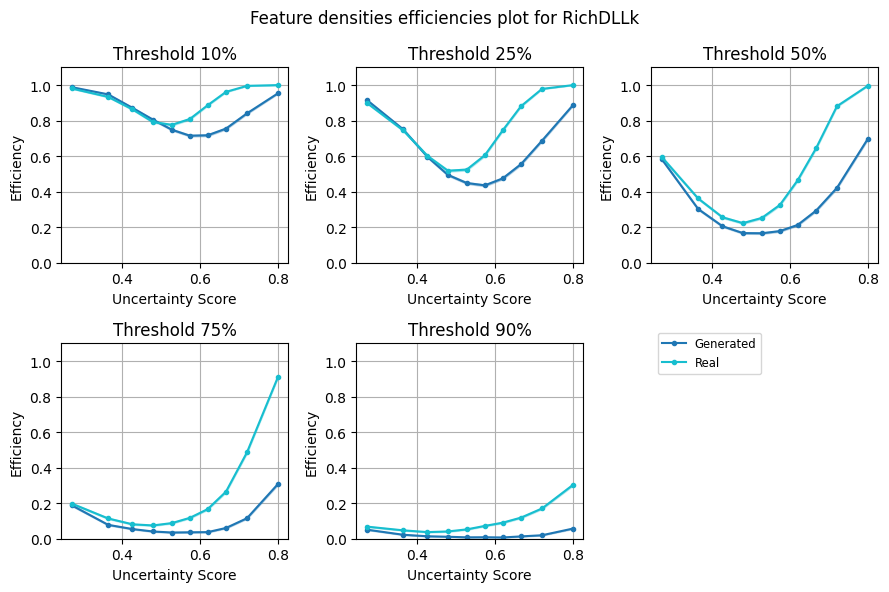

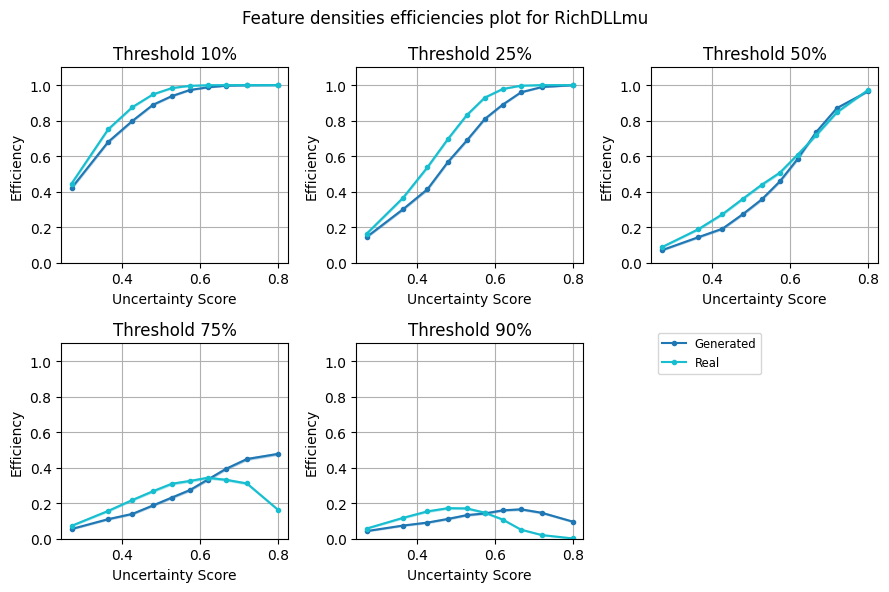

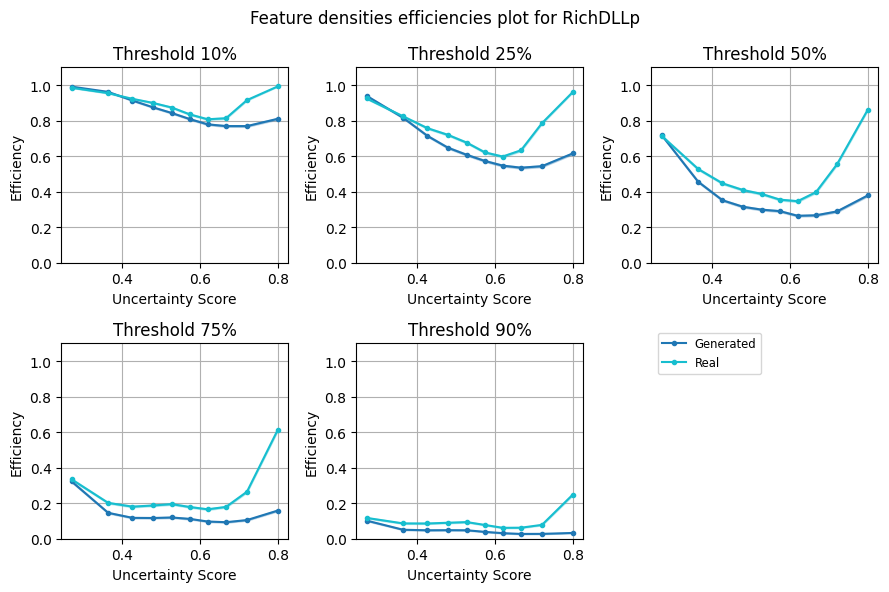

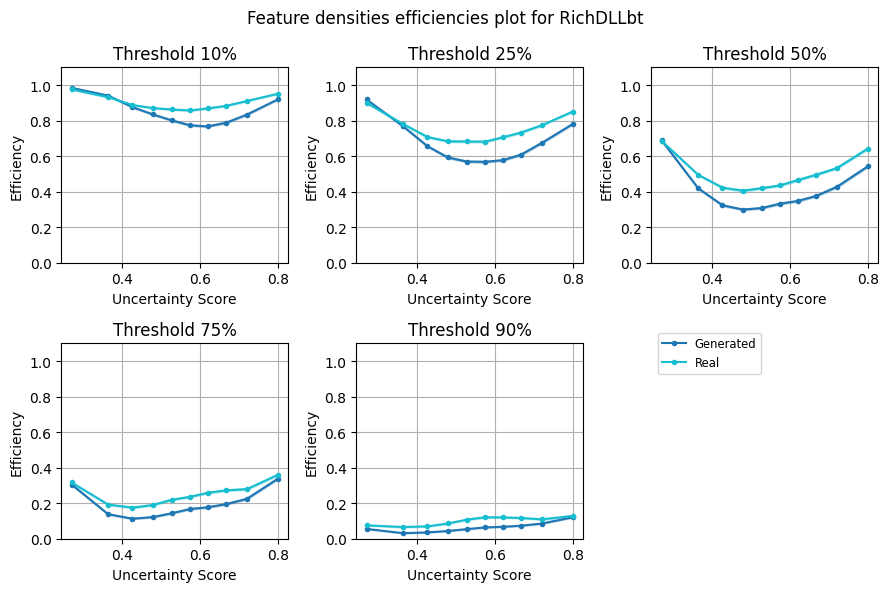

In [ ]:
for i in range(5):
  plot_efficiencies_by_particle(y_sample, t_generated, fd_uncertainty_normalized, [.1, .25, .5, .75, .9], "Feature densities", i)

### Plot MCD efficiencies

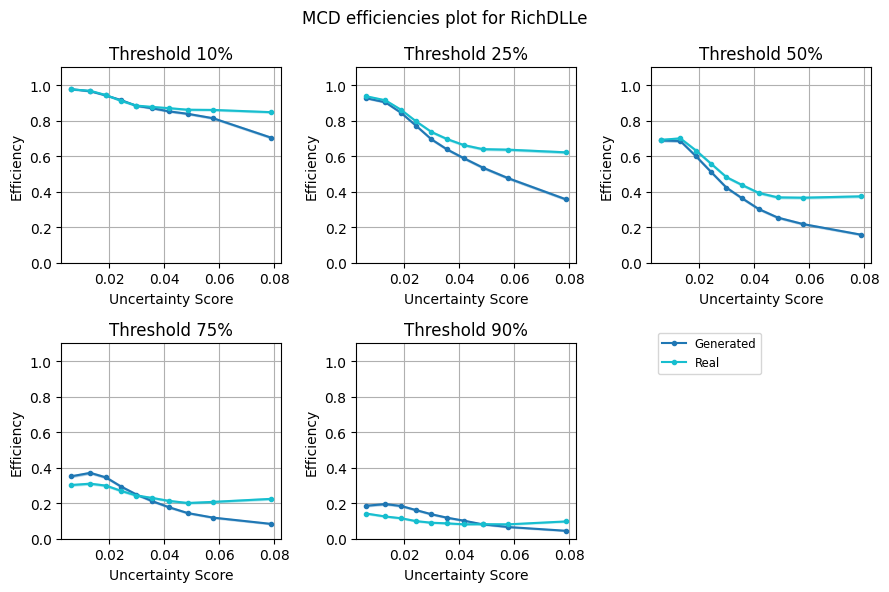

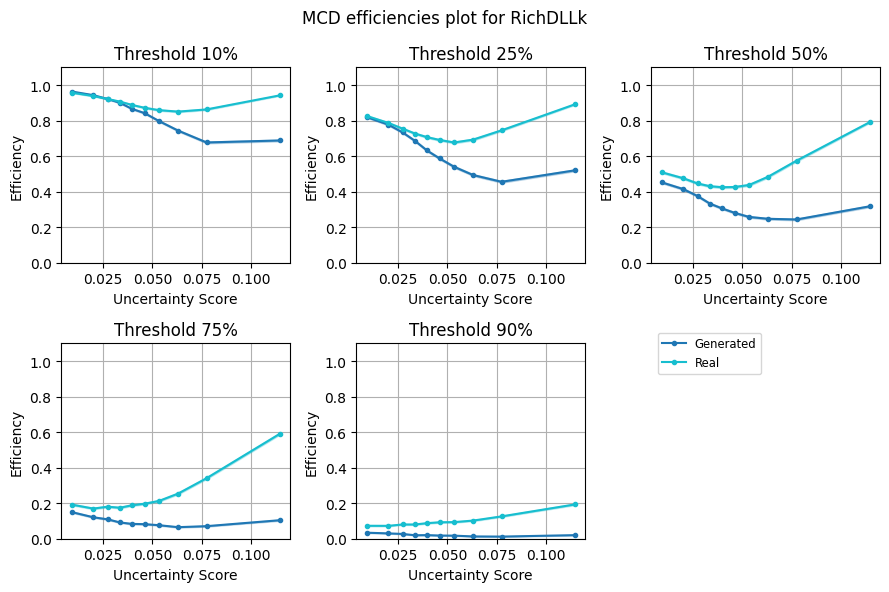

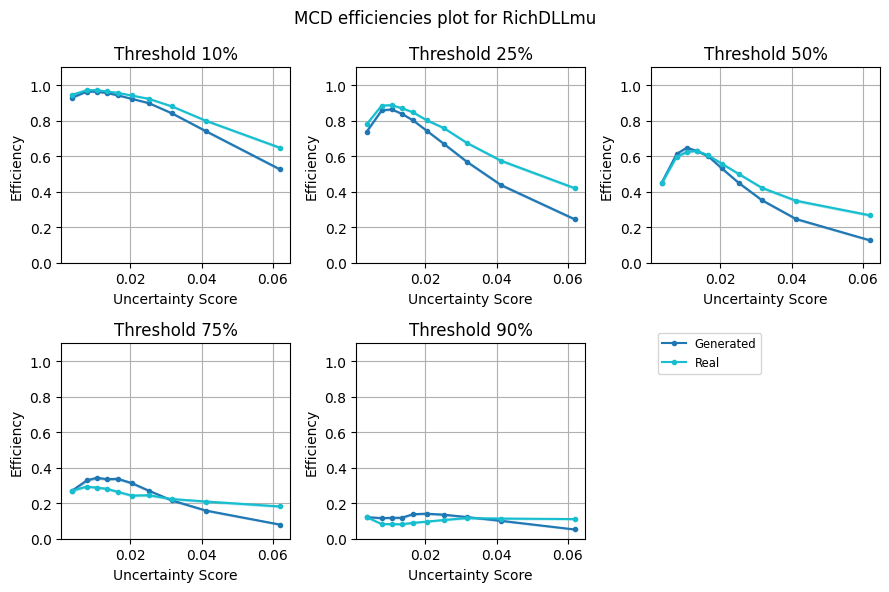

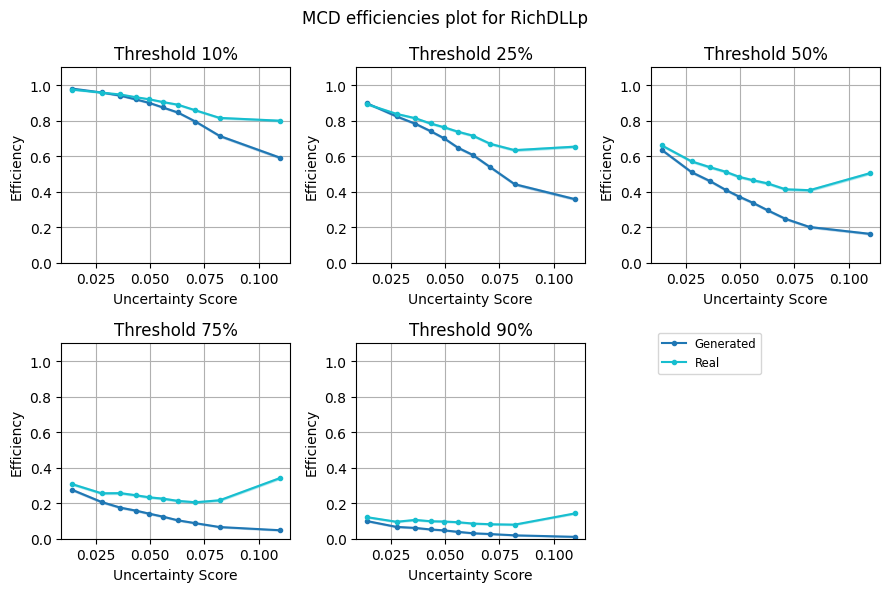

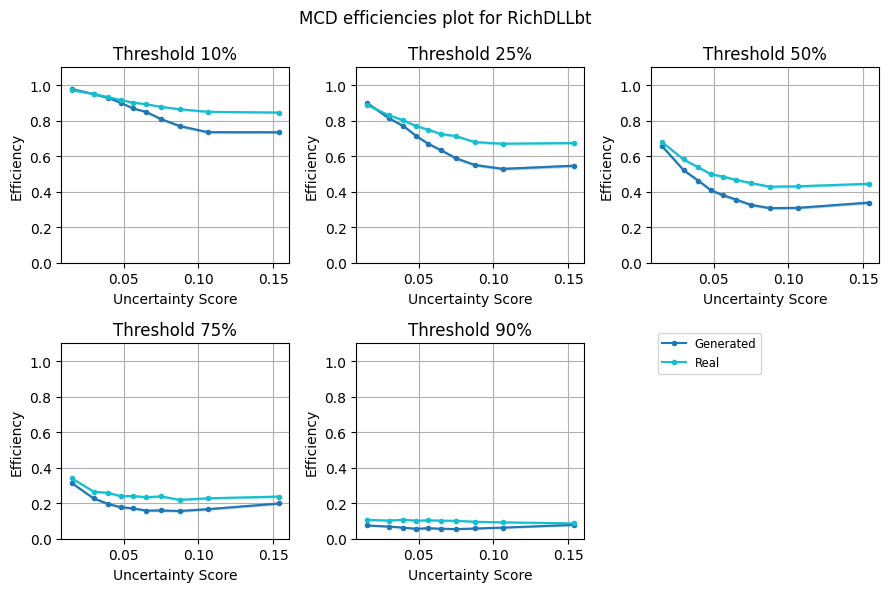

In [ ]:
for i in range(5):
  plot_efficiencies_by_particle(y_sample, t_generated, mcd_final_uncertainty, [.1, .25, .5, .75, .9], "MCD", i)

# Archived

#### FD with integration method


In [ ]:
fd_uncertainty_integration, _ = fd_evaluate_model(model, x_sample, known_embeddings=train_embeddings, n_fit_samples=100,
                                                  likelihood_method='integration')

print('Feature Densities using INTEGRATION uncertainty score for x_sample:')
fd_uncertainty_integration

In [ ]:
# Save FD uncertainties with integration
np.save(output_dir + f'{PARTICLE}_fd_uncertainty_integration.npy', fd_uncertainty_integration)

In [ ]:
all_fd_bin_edges, all_fd_js_distances = [], []

for i in range(5):
  fd_bin_edges, fd_js_distances = estimate_distances_and_plot_uncertainty_bins(
      y_sample, t_generated, fd_uncertainty_integration, 'Feature densities', particle_index = i, n_rows = 3, n_cols = 3)

  all_fd_bin_edges += [fd_bin_edges]
  all_fd_js_distances += [fd_js_distances]

In [ ]:
plot_all_distances(all_fd_bin_edges, all_fd_js_distances, 'Feature densities')

#### MCD / Linear bins

In [ ]:
all_mcd_bin_edges, all_mcd_js_distances = [], []


for i in range(5):
  mcd_bin_edges, mcd_js_distances = estimate_distances_and_plot_uncertainty_bins(
      y_sample, t_generated, mcd_uncertainty, uncertainty_type = 'MCD', particle_index = i)
  all_mcd_bin_edges += [mcd_bin_edges]
  all_mcd_js_distances += [mcd_js_distances]

In [ ]:
plot_all_distances(all_mcd_bin_edges, all_mcd_js_distances, 'MCD')

#### FD / Linear bins

In [ ]:
all_fd_bin_edges, all_fd_js_distances = [], []

for i in range(5):
  fd_bin_edges, fd_js_distances = estimate_distances_and_plot_uncertainty_bins(
      y_sample, t_generated, fd_uncertainty_normalized, 'Feature densities', particle_index = i)

  all_fd_bin_edges += [fd_bin_edges]
  all_fd_js_distances += [fd_js_distances]

In [ ]:
plot_all_distances(all_fd_bin_edges, all_fd_js_distances, 'Feature densities')